Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 14

In [1]:
num_days_R_prediction=14

In [2]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [3]:
%%R
max_days_prediction<-num_days_R_prediction

In [4]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=8 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=15 => 06/02
## DROP_N=45 => 08/03
## DROP_N=75 => 07/04
## DROP_N=145 => 15/06
## DROP_N=175 => 15/07
#
drop_n_dataset_days=175
#

### Load Data from Github - John Hopkins Institute 

In [5]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [6]:
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
241                           NaN                Thailand  15.870032   
242                           NaN             Timor-Leste  -8.874217   
243                           NaN                    Togo   8.619500   
244                           NaN     Trinidad and Tobago  10.691800   
245                           NaN                 Tunisia  33.886917   
246                           NaN                  Turkey  38.963700   
247                           NaN           United States  40.000000   
248                           NaN                  Uganda   1.373333   
249                           NaN                 Ukraine  48.379400   
250                           NaN    United Arab Emirates  23.424076   
251                      Anguilla          United Kingdom  18.220600   
252                       Bermuda          United Kingdom  32.307800   
253        British Virgin Islands          United Kingdom  18.420700   
254                Cayman Islands          United Kingdom  19.313300   
255               Channel Islands          United Kingdom  49.372300   
256   Falkland Islands (Malvinas)          United Kingdom -51.796300   
257                     Gibraltar          United Kingdom  36.140800   
258                   Isle of Man          United Kingdom  54.236100   
259                    Montserrat          United Kingdom  16.742498   
260      Turks and Caicos Islands          United Kingdom  21.694000   
261                           NaN          United Kingdom  55.378100   
262                           NaN                 Uruguay -32.522800   
263                           NaN              Uzbekistan  41.377491   
264                           NaN                 Vanuatu -

## Get Population

In [7]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [8]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
247                           NaN                Thailand  15.870032   
248                           NaN             Timor-Leste  -8.874217   
249                           NaN                    Togo   8.619500   
250                           NaN     Trinidad and Tobago  10.691800   
251                           NaN                 Tunisia  33.886917   
252                           NaN                  Turkey  38.963700   
253                           NaN           United States  40.000000   
254                           NaN                  Uganda   1.373333   
255                           NaN                 Ukraine  48.379400   
256                           NaN    United Arab Emirates  23.424076   
257                      Anguilla          United Kingdom  18.220600   
258                       Bermuda          United Kingdom  32.307800   
259        British Virgin Islands          United Kingdom  18.420700   
260                Cayman Islands          United Kingdom  19.313300   
261               Channel Islands          United Kingdom  49.372300   
262   Falkland Islands (Malvinas)          United Kingdom -51.796300   
263                     Gibraltar          United Kingdom  36.140800   
264                   Isle of Man          United Kingdom  54.236100   
265                    Montserrat          United Kingdom  16.742498   
266      Turks and Caicos Islands          United Kingdom  21.694000   
267                           NaN          United Kingdom  55.378100   
268                           NaN                 Uruguay -32.522800   
269                           NaN              Uzbekistan  41.377491   
270                           NaN                 Vanuatu -

In [9]:
# merge region death
death.iloc[185:195,:]

Province/State Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN      Mauritius -20.348404   57.552152        0        0   
186            NaN         Mexico  23.634500 -102.552800        0        0   
187            NaN        Moldova  47.411600   28.369900        0        0   
188            NaN         Monaco  43.733300    7.416700        0        0   
189            NaN       Mongolia  46.862500  103.846700        0        0   
190            NaN     Montenegro  42.708678   19.374390        0        0   
191            NaN        Morocco  31.791700   -7.092600        0        0   
192            NaN     Mozambique -18.665695   35.529562        0        0   
193            NaN        Namibia -22.957600   18.490400        0        0   
194            NaN          Nepal  28.166700   84.250000        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  12/25/20  12/26/20  12/27/20  \
185        0        0        0        0  ...        10        10        10   
186        0        0        0        0  ...    121837    122026    122426   
187        0        0        0        0  ...      2871      2883      2891   
188        0        0        0        0  ...         3         3         3   
189        0        0        0        0  ...         0         0         0   
190        0        0        0        0  ...       652       658       666   
191        0        0        0        0  ...      7170      7204      7240   
192        0        0        0        0  ...       156       159       161   
193        0        0        0        0  ...       187       187       191   
194        0        0        0        0  ...      1816      1819      1825   

     12/28/20  12/29/20  12/30/20  12/31/20  1/1/21   Population   \
185        10        10        10        10      10           NaN   
186    122855    123845    124897    125807  126507   128,640,794   
187      2909      2934      2960      2985    3004     4,035,942   
188         3         3         3         3       3        39,183   
189         0         1         1         1       1           NaN   
190       675       677       681       682     684       622 500   
191      7272      7314      7355      7388    7425    36,817,128   
192       162       162       165       166     167    31,542,919   
193       193       195       196       205     208     2,540,905   
194      1832      1840      1847      1856    1864    29,300,000   

             region  
185   Mauritius_nan  
186      Mexico_nan  
187     Moldova_nan  
188      Monaco_nan  
189    Mongolia_nan  
190  Montenegro_nan  
191     Morocco_nan  
192  Mozambique_nan  
193     Namibia_nan  
194       Nepal_nan  

[10 rows x 352 columns]

In [10]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat        Long  \
175                               NaN     Mozambique -18.665700   35.529600   
176                               NaN        Namibia -22.957600   18.490400   
177                               NaN          Nepal  28.166700   84.250000   
178                             Aruba    Netherlands  12.521100  -69.968300   
179  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   
180                           Curacao    Netherlands  12.169600  -68.990000   
181                      Sint Maarten    Netherlands  18.042500  -63.054800   
182                               NaN    Netherlands  52.132600    5.291300   
183                               NaN    New Zealand -40.900600  174.886000   
184                               NaN      Nicaragua  12.865416  -85.207229   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  12/25/20  \
175        0        0        0        0        0        0  ...     16015   
176        0        0        0        0        0        0  ...     17602   
177        0        0        0        0        0        0  ...    248292   
178        0        0        0        0        0        0  ...      5058   
179        0        0        0        0        0        0  ...       174   
180        0        0        0        0        0        0  ...      2463   
181        0        0        0        0        0        0  ...      1238   
182        0        0        0        0        0        0  ...         0   
183        0        0        0        0        0        0  ...      2054   
184        0        0        0        0        0        0  ...      4225   

     12/26/20  12/27/20  12/28/20  12/29/20  12/30/20  12/31/20  1/1/21  \
175     16109     16119     16178     16439     16589     16663   16680   
176     17851     18039     18277     18743     19655     20076   20727   
177    249132    249863    250581    251312    251912    252359  253107   
178      5076      5092      5110      5118      5132      5149    5179   
179       174       174       174       174       178       180     180   
180      2486      2529      2568      2657      2759      2925    2950   
181      1238      1238      1298      1308      1320      1331    1342   
182         0         0         0         0         0         0       0   
183      2069      2069      2077      2077      2082      2082    2082   
184      4225      4225      4225      4225      4225      4225    4225   

      Population                                         region  
175    31,542,919                                Mozambique_nan  
176     2,540,905                                   Namibia_nan  
177    29,300,000                                     Nepal_nan  
178           NaN                             Netherlands_Aruba  
179           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  
180       158,665                           Netherlands_Curacao  
181           NaN                      Netherlands_Sint Maarten  
182    17,180,000                               Netherlands_nan  
183     4,813,844                               New Zealand_nan  
184     6,649,701                                 Nicaragua_nan  

[10 rows x 352 columns]

In [11]:
confirmed.iloc[185:195,:]

Province/State Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN      Mauritius -20.348404   57.552152        0        0   
186            NaN         Mexico  23.634500 -102.552800        0        0   
187            NaN        Moldova  47.411600   28.369900        0        0   
188            NaN         Monaco  43.733300    7.416700        0        0   
189            NaN       Mongolia  46.862500  103.846700        0        0   
190            NaN     Montenegro  42.708678   19.374390        0        0   
191            NaN        Morocco  31.791700   -7.092600        0        0   
192            NaN     Mozambique -18.665695   35.529562        0        0   
193            NaN        Namibia -22.957600   18.490400        0        0   
194            NaN          Nepal  28.166700   84.250000        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  12/25/20  12/26/20  12/27/20  \
185        0        0        0        0  ...       527       527       527   
186        0        0        0        0  ...   1372243   1377217   1383434   
187        0        0        0        0  ...    140250    140996    141355   
188        0        0        0        0  ...       789       797       797   
189        0        0        0        0  ...      1082      1121      1137   
190        0        0        0        0  ...     45945     46327     46694   
191        0        0        0        0  ...    428193    430562    432079   
192        0        0        0        0  ...     18108     18162     18265   
193        0        0        0        0  ...     21262     21398     21923   
194        0        1        1        1  ...    257200    257700    258181   

     12/28/20  12/29/20  12/30/20  12/31/20   1/1/21   Population   \
185       527       527       527       527      527           NaN   
186   1389430   1401529   1413935   1426094  1437185   128,640,794   
187    141924    142851    143841    144818   145258     4,035,942   
188       801       827       853       875      885        39,183   
189      1175      1195      1215      1220     1242           NaN   
190     46969     47404     47782     48247    48589       622 500   
191    433029    435189    437332    439193   440970    36,817,128   
192     18310     18372     18485     18642    18794    31,542,919   
193     22287     22851     23333     23941    24545     2,540,905   
194    258840    259548    260059    260593   261019    29,300,000   

             region  
185   Mauritius_nan  
186      Mexico_nan  
187     Moldova_nan  
188      Monaco_nan  
189    Mongolia_nan  
190  Montenegro_nan  
191     Morocco_nan  
192  Mozambique_nan  
193     Namibia_nan  
194       Nepal_nan  

[10 rows x 352 columns]

In [12]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                       Saint Lucia  13.909400  -60.978900   
221            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   
222            NaN                             Samoa -13.759000 -172.104600   
223            NaN                        San Marino  43.942400   12.457800   
224            NaN             Sao Tome and Principe   0.186400    6.613100   
225            NaN                      Saudi Arabia  23.885942   45.079162   
226            NaN                           Senegal  14.497400  -14.452400   
227            NaN                            Serbia  44.016500   21.005900   
228            NaN                        Seychelles  -4.679600   55.492000   
229            NaN                      Sierra Leone   8.460555  -11.779889   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  12/25/20  \
220        0        0        0        0        0        0  ...       305   
221        0        0        0        0        0        0  ...       108   
222        0        0        0        0        0        0  ...         2   
223        0        0        0        0        0        0  ...      2231   
224        0        0        0        0        0        0  ...      1014   
225        0        0        0        0        0        0  ...    361903   
226        0        0        0        0        0        0  ...     18369   
227        0        0        0        0        0        0  ...    320167   
228        0        0        0        0        0        0  ...       205   
229        0        0        0        0        0        0  ...      2549   

     12/26/20  12/27/20  12/28/20  12/29/20  12/30/20  12/31/20  1/1/21  \
220       305       305       331       331       340       353     353   
221       109       109       109       113       115       121     121   
222         2         2         2         2         2         2       2   
223      2231      2231      2275      2333      2384      2428    2428   
224      1014      1014      1014      1014      1014      1014    1022   
225    362066    362220    362339    362488    362601    362741  362878   
226     18523     18609     18728     18806     18945     19140   19364   
227    323367    326060    328619    331755    334991    337923  339997   
228       205       205       217       217       256       275     275   
229      2549      2560      2560      2569      2583      2611    2635   

      Population                                 region  
220           NaN                       Saint Lucia_nan  
221           NaN  Saint Vincent and the Grenadines_nan  
222           NaN                             Samoa_nan  
223        33,916                        San Marino_nan  
224           NaN             Sao Tome and Principe_nan  
225    34,695,447                      Saudi Arabia_nan  
226    16,743,927                           Senegal_nan  
227     8,744,671                            Serbia_nan  
228           NaN                        Seychelles_nan  
229           NaN                      Sierra Leone_nan  

[10 rows x 352 columns]

## Create Time Series + Plots

In [13]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [14]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [15]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

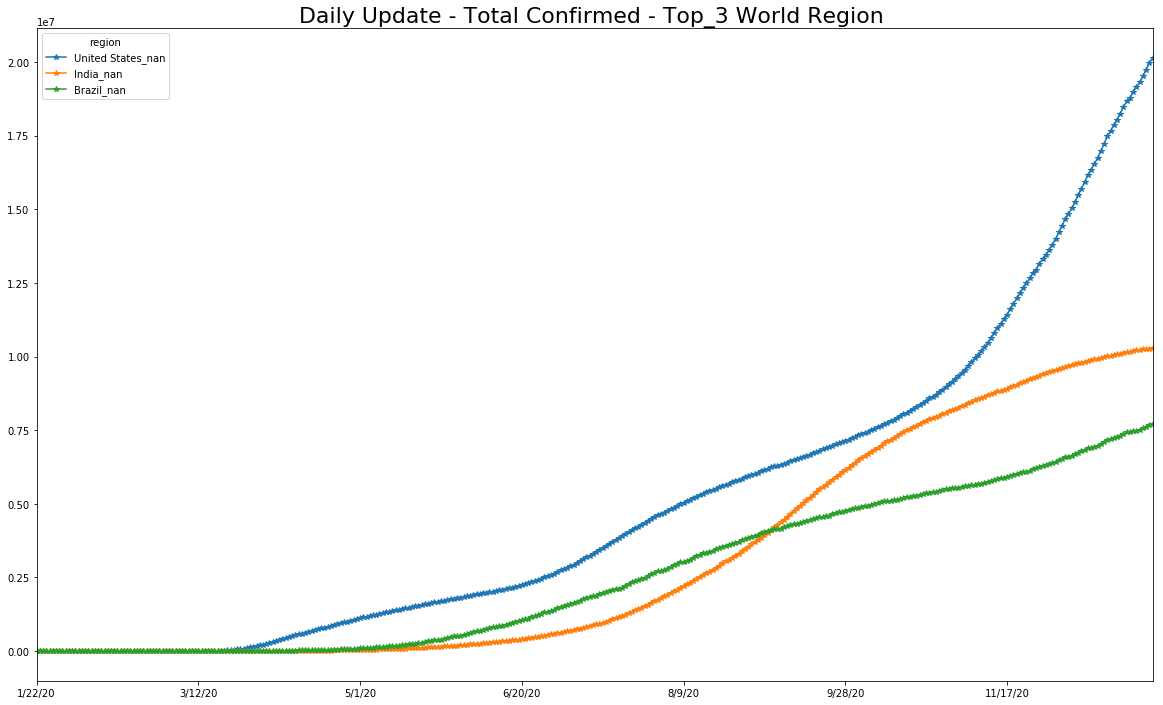

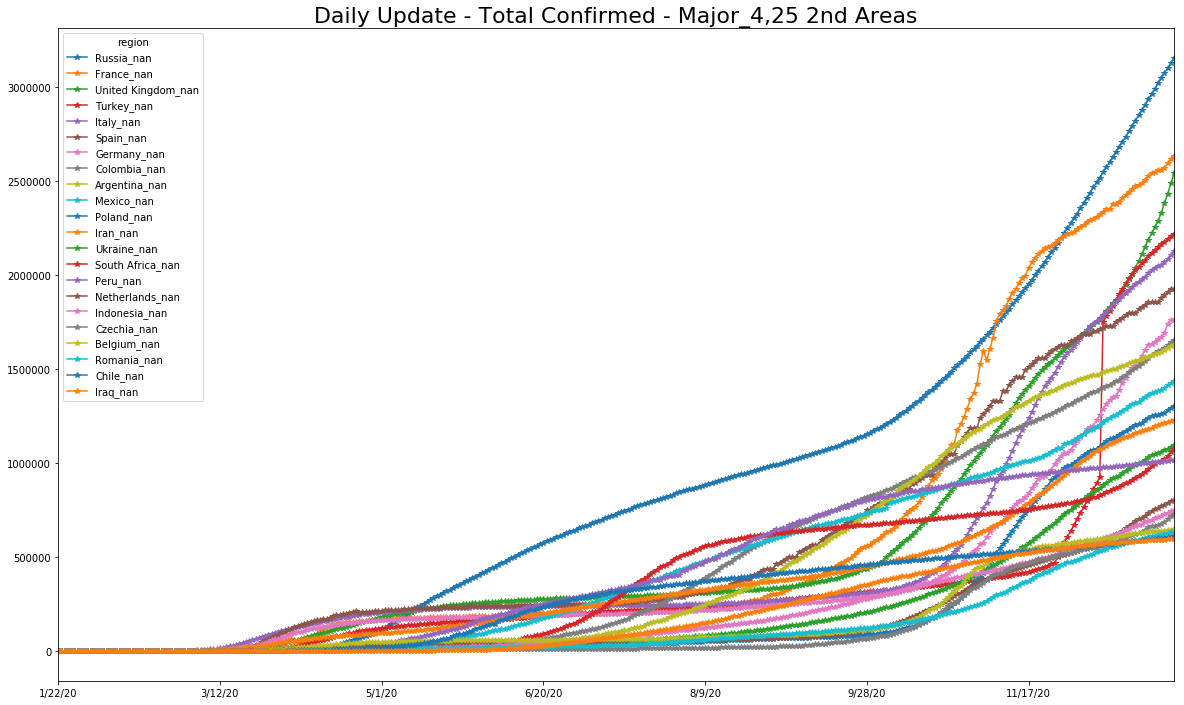

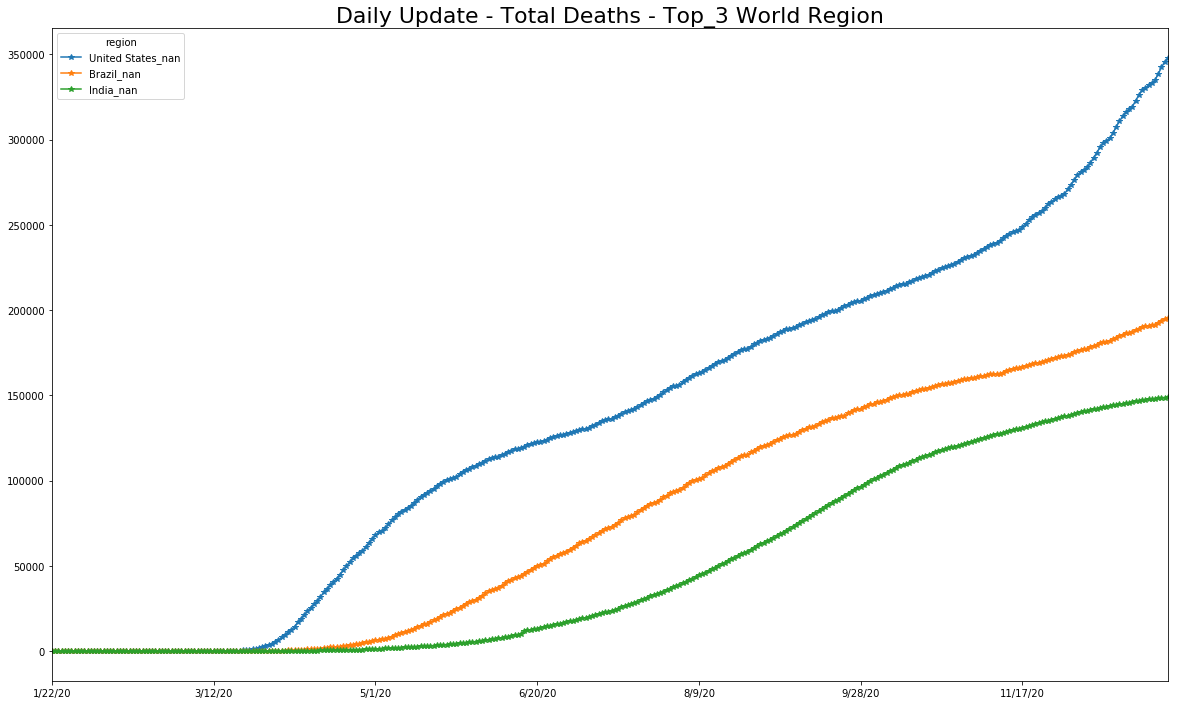

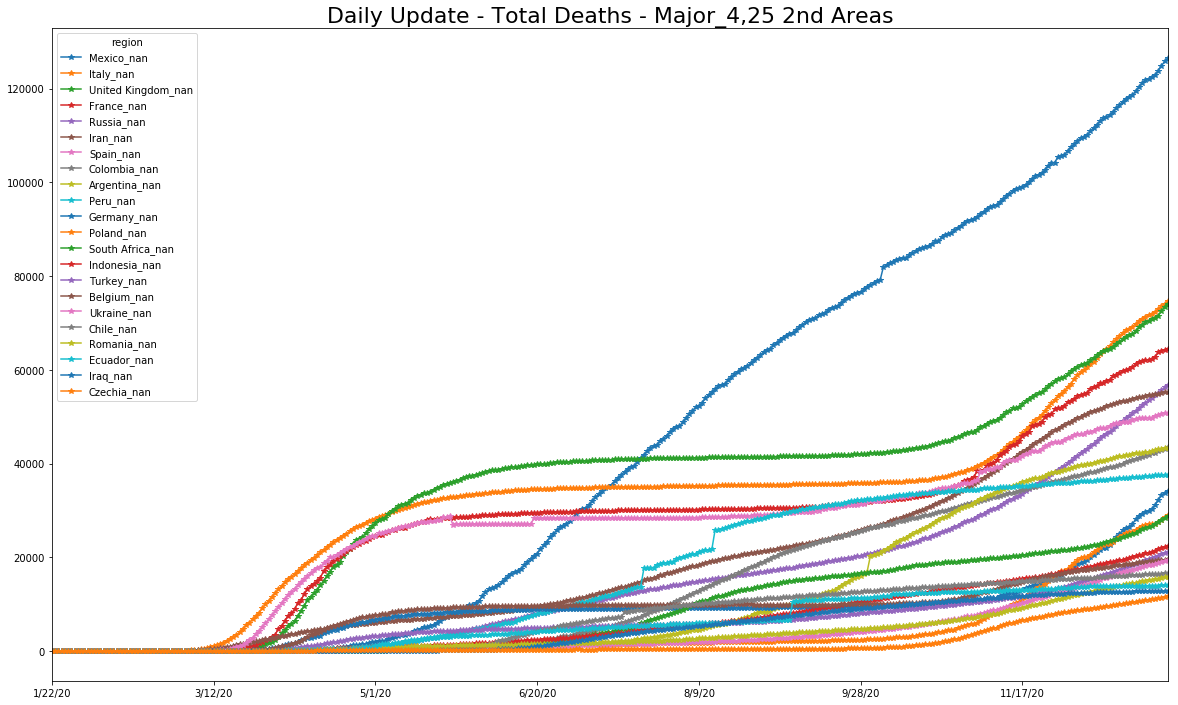

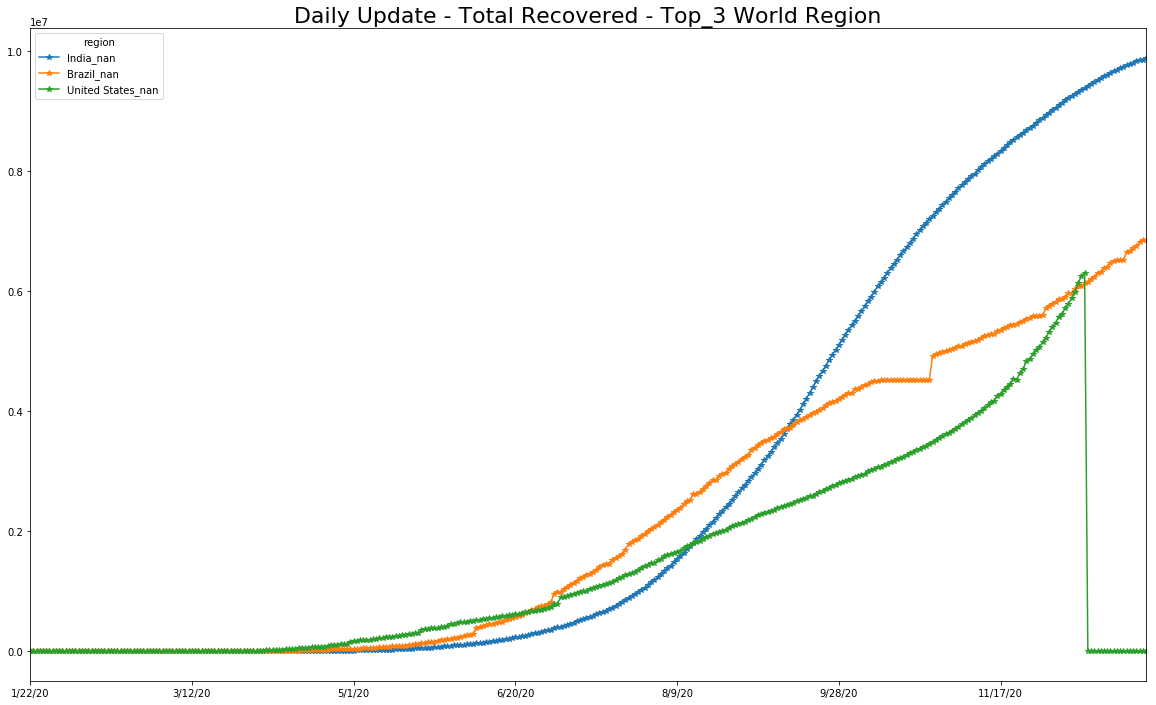

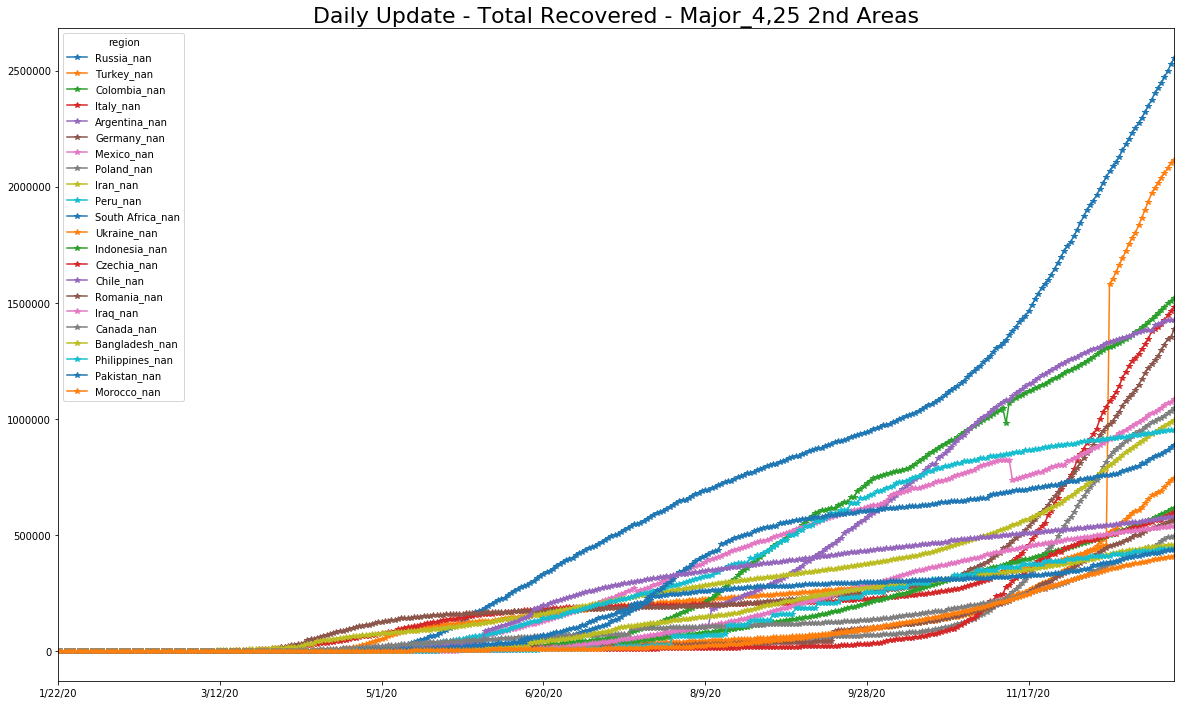

In [16]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [17]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [18]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [19]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2021/01/02


In [20]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [21]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [22]:
# Joao - FIX - Improve Performance 
## DROP_N=15
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [23]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
7/15/20            34984         3752        20770          862         576   
7/16/20            35060         3851        21355          877         607   
7/17/20            35219         3906        21948          880         638   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
7/15/20                       74         111146        33005   
7/16/20                       74         114783        33559   
7/17/20                       76         119301        34001   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
7/15/20                                     113                       3527   
7/16/20                                     113                       3535   
7/17/20                                     113                       3550   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
7/15/20  ...            3495012         1009           14581            0   
7/16/20  ...            3571721         1026           15066            0   
7/17/20  ...            3643660         1037           15607            0   

region   Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
7/15/20          10428          381                    7064       1526   
7/16/20          10854          381                    7412       1552   
7/17/20          11191          382                    7764       1576   

region   Zambia_nan  Zimbabwe_nan  
7/15/20        1895          1089  
7/16/20        1895          1362  
7/17/20        2810          1420  

[3 rows x 271 columns]

In [24]:
ts[-4:]

region    Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
12/29/20            51350        57146        98988         7919       17371   
12/30/20            51405        57727        99311         7983       17433   
12/31/20            51526        58316        99610         8049       17553   
1/1/21              51526        58316        99897         8117       17568   

region    Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
12/29/20                      158        1602163       158296   
12/30/20                      158        1613928       158878   
12/31/20                      159        1625514       159409   
1/1/21                        159        1629594       159738   

region    Australia_Australian Capital Territory  Australia_New South Wales  \
12/29/20                                     118                       4906   
12/30/20                                     118                       4923   
12/31/20                                     118                       4928   
1/1/21                                       118                       4947   

region    ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
12/29/20  ...           19511426        17962           76907            1   
12/30/20  ...           19740772        18480           76985            1   
12/31/20  ...           19968087        19119           77060            1   
1/1/21    ...           20128693        19753           77182            1   

region    Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
12/29/20         112861         1454                  135459       2096   
12/30/20         113121         1456                  136736       2097   
12/31/20         113558         1465                  138004       2099   
1/1/21           113884         1474                  139223       2101   

region    Zambia_nan  Zimbabwe_nan  
12/29/20       20177         13325  
12/30/20       20462         13625  
12/31/20       20725         13867  
1/1/21         20997         14084  

[4 rows x 271 columns]

In [25]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [26]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [27]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [28]:
p=%R pred_all

In [29]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [30]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [31]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [32]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [33]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [34]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [35]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [36]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2020-07-16  Afghanistan_nan      35060             0             0   
2     2020-07-17  Afghanistan_nan      35219            76             0   
3     2020-07-18  Afghanistan_nan      35279           159             0   
4     2020-07-19  Afghanistan_nan      35453            60           295   
5     2020-07-20  Afghanistan_nan      35493           174           393   
6     2020-07-21  Afghanistan_nan      35605            40           274   
7     2020-07-22  Afghanistan_nan      35717           112           326   
8     2020-07-23  Afghanistan_nan      35918           112           264   
9     2020-07-24  Afghanistan_nan      35978           201           425   
10    2020-07-25  Afghanistan_nan      36026            60           373   
11    2020-07-26  Afghanistan_nan      36147            48           309   
12    2020-07-27  Afghanistan_nan      36253           121           229   
13    2020-07-28  Afghanistan_nan      36358           106           275   
14    2020-07-29  Afghanistan_nan      36463           105           332   
15    2020-07-30  Afghanistan_nan      36532           105           316   
16    2020-07-31  Afghanistan_nan      36665            69           279   
17    2020-08-01  Afghanistan_nan      36700           133           307   
18    2020-08-02  Afghanistan_nan      36701            35           237   
19    2020-08-03  Afghanistan_nan      36737             1           169   
20    2020-08-04  Afghanistan_nan      36773            36            72   
21    2020-08-05  Afghanistan_nan      36820            36            73   
22    2020-08-06  Afghanistan_nan      36928            47           119   
23    2020-08-07  Afghanistan_nan      37006           108           191   
24    2020-08-08  Afghanistan_nan      37046            78           233   
25    2020-08-09  Afghanistan_nan      37083            40           226   
26    2020-08-10  Afghanistan_nan      37153            37           155   
27    2020-08-11  Afghanistan_nan      37260            70           147   
28    2020-08-12  Afghanistan_nan      37336           107           214   
29    2020-08-13  Afghanistan_nan      37422            76           253   
30    2020-08-14  Afghanistan_nan      37497            86           269   
...          ...              ...        ...           ...           ...   
47614 2020-12-04     Zimbabwe_nan      10547           295           474   
47615 2020-12-05     Zimbabwe_nan      10617           123           418   
47616 2020-12-06     Zimbabwe_nan      10718            70           488   
47617 2020-12-07     Zimbabwe_nan      10839           101           294   
47618 2020-12-08     Zimbabwe_nan      10912           121           292   
47619 2020-12-09     Zimbabwe_nan      11007            73           295   
47620 2020-12-10     Zimbabwe_nan      11081            95           289   
47621 2020-12-11     Zimbabwe_nan      11162            74           242   
47622 2020-12-12     Zimbabwe_nan      11219            81           250   
47623 2020-12-13     Zimbabwe_nan      11246            57           212   
47624 2020-12-14     Zimbabwe_nan      11358            27           165   
47625 2020-12-15     Zimbabwe_nan      11522           112           196   
47626 2020-12-16     Zimbabwe_nan      11749           164           303   
47627 2020-12-17     Zimbabwe_nan      11866           227           503   
47628 2020-12-18     Zimbabwe_nan      12047           117           508   
47629 2020-12-19     Zimbabwe_nan      12151           181           525   
47630 2020-12-20     Zimbabwe_nan      12325           104           402   
47631 2020-12-21     Zimbabwe_nan      12422           174           459   
47632 2020-12-22     Zimbabwe_nan      12544            97           375   
47633 2020-12-23     Zimbabwe_nan      12656           122           393   
47634 2020-12-24     Zimbabwe_nan      12786           112  

In [37]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [38]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
47643 2021-01-02  Zimbabwe_nan          0           217           759   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
47643          1204         101.564938         105.696135         109.347904   

       last_day  kalman_prediction  population  infected_rate  min  max  
47643     14084            14193.0    14862924       0.000009  NaN  NaN

In [39]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
47643 2021-01-02  Zimbabwe_nan          0           217           759   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
47643          1204         101.564938         105.696135         109.347904   

       last_day  kalman_prediction  population  infected_rate  min  max  
47643     14084            14193.0    14862924       0.000009  NaN  NaN

In [40]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=ratiod['infected_rate']*1000
ratiod['delta : new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : new_cases per 1M hab']=ratiod['delta : new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
46609  2020-12-31  Zimbabwe_nan      13867           300           548   
46610  2021-01-01  Zimbabwe_nan      14084           242           719   
46611  2021-01-02  Zimbabwe_nan          0           217           759   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
46609           969         102.251482         104.190640         107.656527   
46610          1081         101.776220         105.468588         108.454638   
46611          1204         101.564938         105.696135         109.347904   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
46609                13625  ...    14862924       0.000009  NaN  NaN   
46610                13867  ...    14862924       0.000009  NaN  NaN   
46611                14084  ...    14862924       0.000009  NaN  NaN   

       population_percentage : infected_rate confirmed  \
46609                                         0.000917   
46610                                         0.000933   
46611                                         0.000948   

       population_percentage : factor 9/10 infected_rate confirmed  \
46609                                           0.009168             
46610                                           0.009331             
46611                                           0.009477             

       delta : new_cases  delta : new_cases per 1M hab  \
46609               22.0                      1.480193   
46610               55.0                      3.700483   
46611              109.0                      7.333685   

       delta : roling 7day AVG  \
46609               138.428571   
46610               154.428571   
46611               172.000000   

       delta : aprox 14-day case notification rate per 100k hab  
46609                                          13.039157         
46610                                          14.546263         
46611                                          16.201388         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse            mae
261  United States_nan  2.417027e+12  1.554679e+06  139947.163743


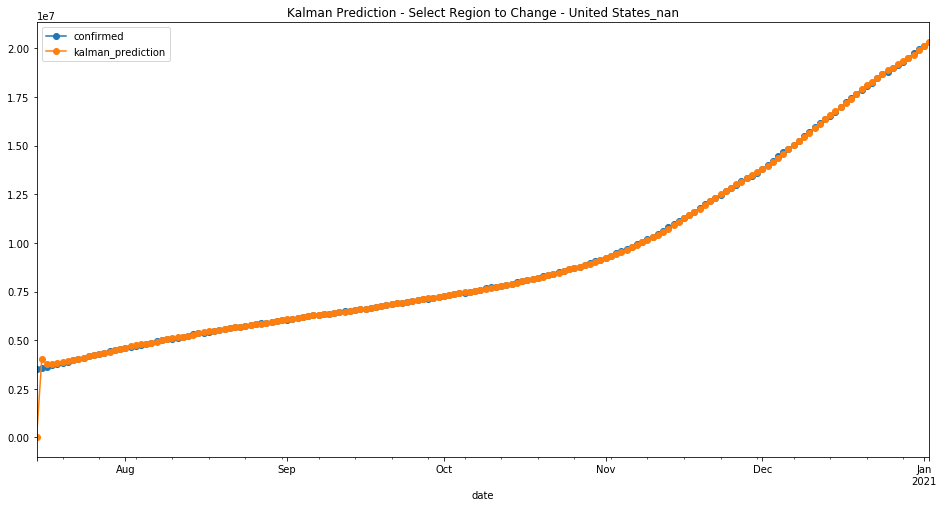

In [41]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse           rmse           mae
211  Russia_nan  5.928477e+10  243484.640202  20759.578947


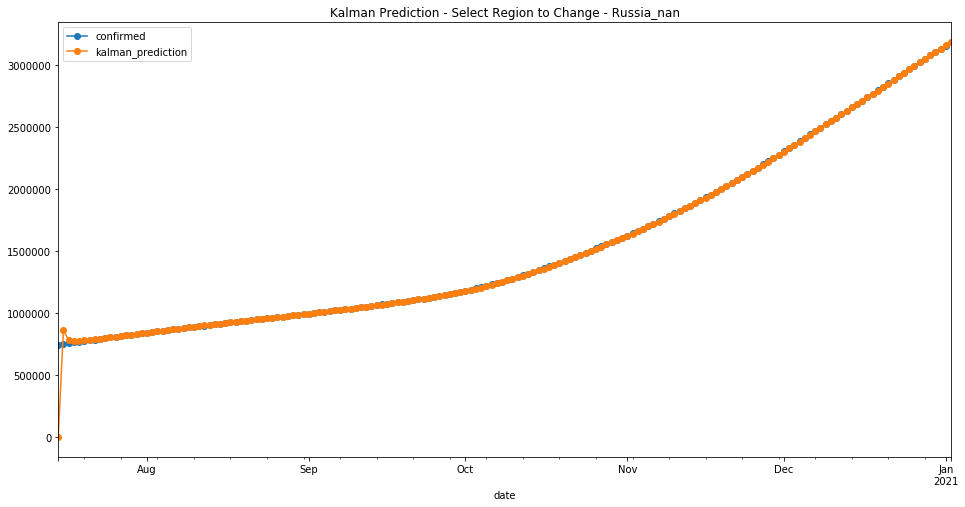

In [42]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse           rmse           mae
30  Brazil_nan  3.511018e+11  592538.440801  62950.994152


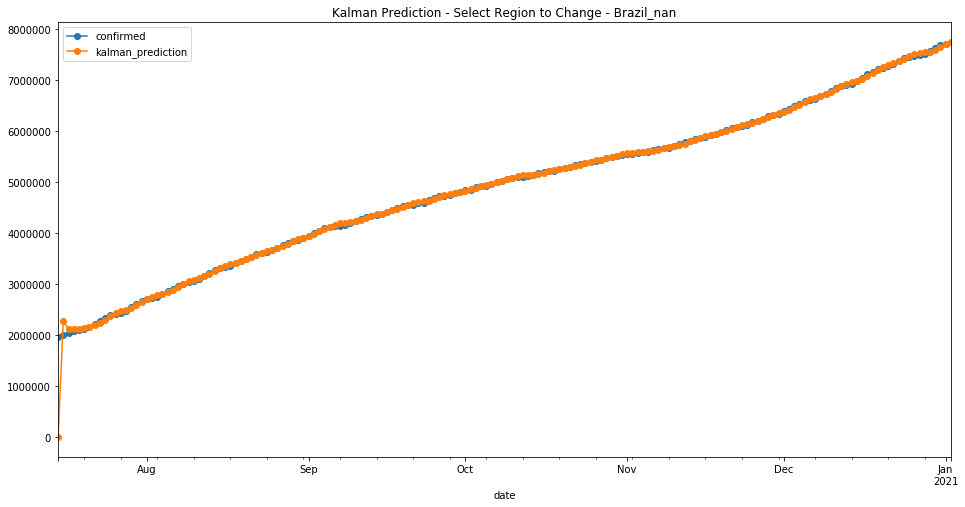

In [43]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse           rmse           mae
260  United Kingdom_nan  3.897008e+10  197408.415381  18783.181287


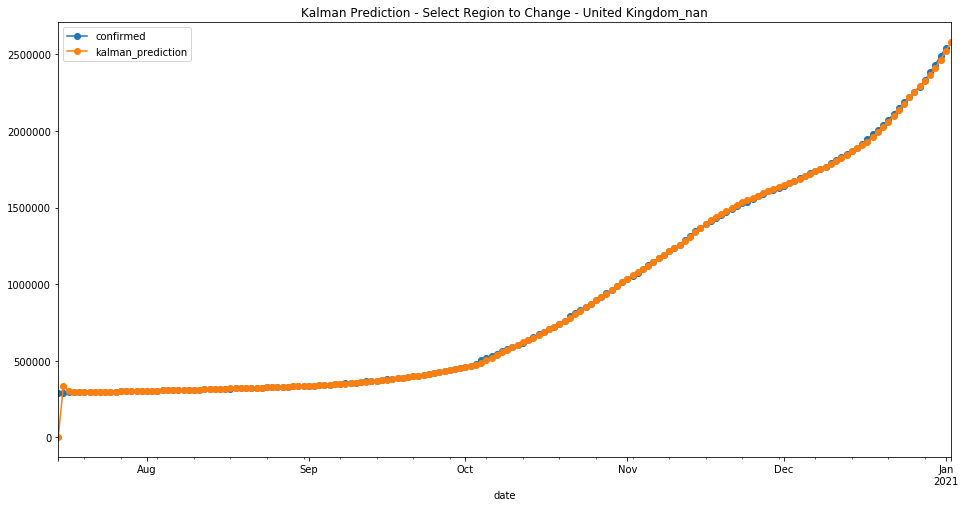

In [44]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [45]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp4mo7tt3i
  JVM stdout: /tmp/tmp4mo7tt3i/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp4mo7tt3i/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         03 secs
H2O_cluster_timezone:       Etc/GMT
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.1.3
H2O_cluster_version_age:    3 months and 4 days
H2O_cluster_name:           H2O_from_python_unknownUser_f1d350
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.049 Gb
H2O_cluster_total_cores:    10
H2O_cluster_allowed_cores:  10
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.7.7 final
--------------------------  ------------------------------------------------------------------

In [46]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2020-12-25
last_train_date= 2021-01-01
first_bootstrap_date= 2020-12-24
boost_bootstrap_date= 2020-12-29
first_test_date= 2020-12-23
last_test_date= 2021-01-02
first_valid_date= 2020-12-31


In [47]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [48]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [49]:
pred2.iloc[:25]

0  confirmed       date           region
0   50671.0      50655 2020-12-24  Afghanistan_nan
1   50891.0      50810 2020-12-25  Afghanistan_nan
2   51065.0      50886 2020-12-26  Afghanistan_nan
3   51146.0      51039 2020-12-27  Afghanistan_nan
4   51290.0      51280 2020-12-28  Afghanistan_nan
5   51510.0      51350 2020-12-29  Afghanistan_nan
6   51582.0      51405 2020-12-30  Afghanistan_nan
7   51651.0      51526 2020-12-31  Afghanistan_nan
8   51753.0      51526 2021-01-01  Afghanistan_nan
9   51740.0          0 2021-01-02  Afghanistan_nan
10  54978.0      54827 2020-12-24      Albania_nan
11  55447.0      55380 2020-12-25      Albania_nan
12  55978.0      55755 2020-12-26      Albania_nan
13  56349.0      56254 2020-12-27      Albania_nan
14  56850.0      56572 2020-12-28      Albania_nan
15  57153.0      57146 2020-12-29      Albania_nan
16  57722.0      57727 2020-12-30      Albania_nan
17  58279.0      58316 2020-12-31      Albania_nan
18  58894.0      58316 2021-01-01      Albania_nan
19  58937.0          0 2021-01-02      Albania_nan
20  97064.0      97007 2020-12-24      Algeria_nan
21  97516.0      97441 2020-12-25      Algeria_nan
22  97959.0      97857 2020-12-26      Algeria_nan
23  98380.0      98249 2020-12-27      Algeria_nan
24  98772.0      98631 2020-12-28      Algeria_nan

In [50]:
pred2.iloc[175:195]

0  confirmed       date          region
175  217441.0     216584 2020-12-29  Azerbaijan_nan
176  218430.0     217636 2020-12-30  Azerbaijan_nan
177  219264.0     218700 2020-12-31  Azerbaijan_nan
178  220190.0     219041 2021-01-01  Azerbaijan_nan
179  220351.0          0 2021-01-02  Azerbaijan_nan
180    7848.0       7788 2020-12-24     Bahamas_nan
181    7865.0       7788 2020-12-25     Bahamas_nan
182    7865.0       7788 2020-12-26     Bahamas_nan
183    7861.0       7834 2020-12-27     Bahamas_nan
184    7855.0       7834 2020-12-28     Bahamas_nan
185    7907.0       7846 2020-12-29     Bahamas_nan
186    7912.0       7857 2020-12-30     Bahamas_nan
187    7921.0       7871 2020-12-31     Bahamas_nan
188    7934.0       7887 2021-01-01     Bahamas_nan
189    7948.0          0 2021-01-02     Bahamas_nan
190   91371.0      91070 2020-12-24     Bahrain_nan
191   91631.0      91304 2020-12-25     Bahrain_nan
192   91866.0      91518 2020-12-26     Bahrain_nan
193   92095.0      91733 2020-12-27     Bahrain_nan
194   92324.0      91935 2020-12-28     Bahrain_nan

In [51]:
pred2.iloc[220:240]

0  confirmed       date       region
220  181248.0     181113 2020-12-24  Belarus_nan
221  183156.0     183006 2020-12-25  Belarus_nan
222  185054.0     184922 2020-12-26  Belarus_nan
223  186979.0     186747 2020-12-27  Belarus_nan
224  188801.0     188588 2020-12-28  Belarus_nan
225  190650.0     190404 2020-12-29  Belarus_nan
226  192450.0     192361 2020-12-30  Belarus_nan
227  194412.0     194284 2020-12-31  Belarus_nan
228  196319.0     196223 2021-01-01  Belarus_nan
229  198272.0          0 2021-01-02  Belarus_nan
230  635302.0     634904 2020-12-24  Belgium_nan
231  637680.0     637246 2020-12-25  Belgium_nan
232  640067.0     638030 2020-12-26  Belgium_nan
233  640709.0     638877 2020-12-27  Belgium_nan
234  641599.0     639734 2020-12-28  Belgium_nan
235  642115.0     641411 2020-12-29  Belgium_nan
236  643625.0     644242 2020-12-30  Belgium_nan
237  646391.0     646496 2020-12-31  Belgium_nan
238  648498.0     648289 2021-01-01  Belgium_nan
239  650440.0          0 2021-01-02  Belgium_nan

In [52]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [53]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  2181276729.7666903
# MSE on the validation data =  5306870275466.648
# R^2 on the training data =  0.9995766040550877
# R^2 on the validation data =  0.4543066476146239


In [54]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1609598520807_1


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              500.0                     500.0           22342854.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       21.0       23.0      22.988      2624.0      3637.0       3496.5



ModelMetricsRegression: drf
** Reported on train data. **

MSE: 2181276729.7666903
RMSE: 46704.140392118235
MAE: 5122.2871447324005
RMSLE: 0.24096714083490775
Mean Residual Deviance: 2181276729.7666903

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 5306870275466.648
RMSE: 2303664.5318853715
MAE: 598629.1985524775
RMSLE: 7.348608185746579
Mean Residual Deviance: 5306870275466.648

Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2021-01-02 14:42:13   0.167 sec              0.0            NaN   
1     2021-01-02 14:42:14   0.927 sec              1.0   96559.301968   
2     2021-01-02 14:42:14   1.451 sec              2.0   79529.757908   
3     2021-01-02 14:42:14   1.640 sec              3.0   94497.631107   
4     2021-01-02 14:42:15   1.792 sec              4.0   72740.426675   
5     2021-01-02 14:42:15   1.944 sec              5.0   98745.005262   
6     2021-01-02 14:42:15   2.311 sec              6.0   97810.832145   
7     2021-01-02 14:42:15   2.772 sec              7.0   83149.507216   
8     2021-01-02 14:42:16   3.085 sec              8.0   82901.685900   
9     2021-01-02 14:42:16   3.371 sec              9.0   79754.914704   
10    2021-01-02 14:42:16   3.688 sec             10.0   71666.288657   
11    2021-01-02 14:42:17   4.031 sec             11.0   67545.558725   
12    2021-01-02 14:42:21   8.081 sec             40.0   53595.702361   
13    2021-01-02 14:42:25  12.093 sec            109.0   50209.677437   
14    2021-01-02 14:42:29  16.130 sec            171.0   49431.781974   
15    2021-01-02 14:42:33  20.155 sec            228.0   48307.399984   
16    2021-01-02 14:42:37  24.161 sec            287.0   48248.705983   
17    2021-01-02 14:42:41  28.162 sec            350.0   46848.017578   
18    2021-01-02 14:42:47  33.942 sec            425.0   46366.252423   
19    2021-01-02 14:42:52  39.307 sec            500.0   46704.140392   

    training_mae  training_deviance  validation_rmse  validation_mae  \
0            NaN                NaN              NaN             NaN   
1   18105.432292       9.323699e+09     2.341700e+06   585823.920045   
2   14616.768793       6.324982e+09     2.609794e+06   684867.829121   
3   15218.583755       8.929802e+09     2.495519e+06   650584.538729   
4   13124.285769       5.291170e+09     2.438174e+06   634177.970101   
5   14140.758458       9.750576e+09     2.412580e+06   624136.825560   
6   13857.133974       9.566959e+09     2.388141e+06   617440.711956   
7   13343.812565       6.913841e+09     2.380613e+06   612526.597084   
8   13125.354967       6.872690e+09     2.375130e+06   610079.046142   
9   12563.035263       6.360846e+09     2.363248e+06   607413.763909   
10  11663.219606       5.136057e+09     2.360344e+06   604953.827851   
11  10912.731444       4.562403e+09     2.343405e+06   603483.606161   
12   7303.760196       2.872499e+09     2.316283e+06   590875.875855   
13   6290.503377       2.521012e+09     2.300781e+06   595767.347020   
14   5839.691202       2.443501e+09     2.297283e+06   597673.787935   
15   5583.225694       2.333605e+09     2.296501e+06   596871.249824   
16   5482.696340       2.327938e+09     2.298387e+06   599477.100119   
17   5305.549584       2.194737e+09     2.297037e+06   598743.755056   
18   5183.255778       2.149829e+09     2.303353e+06   599404.595227   
19   5122.287145       2.181277e+09     2.303665e+06   598629.198552   

    validation_deviance  
0                   NaN  
1          5.483560e+12  
2          6.811026e+12  
3          6.227618e+12  
4          5.944691e+12  
5          5.820542e+12  
6          5.703219e+12  
7          5.667320e+12  
8          5.641244e+12  
9          5.584943e+12  
10         5.571222e+12  
11         5.491547e+12  
12         5.365168e+12  
13         5.293591e+12  
14         5.277509e+12  
15         5.273916e+12  
16         5.282581e+12  
17         5.276378e+12  
18         5.305437e+12  
19         5.306870e+12


Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0   kalman_prediction         5.376561e+18           1.000000    0.349599
1            last_day         4.277579e+18           0.795598    0.278140
2              region         2.172049e+18           0.403985    0.141233
3        7_day_change         1.409508e+18           0.262158    0.091650
4        3_day_change         8.697018e+17           0.161758    0.056551
5        1_day_change         6.185257e+17           0.115041    0.040218
6       infected_rate         4.434179e+17           0.082472    0.028832
7                 min         6.218724e+16           0.011566    0.004044
8                 max         5.686570e+16           0.010577    0.003698
9   7_day_change_rate         4.689964e+16           0.008723    0.003050
10  3_day_change_rate         2.697402e+16           0.005017    0.001754
11  1_day_change_rate         1.893559e+16           0.003522    0.001231

In [55]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0   kalman_prediction         5.376561e+18           1.000000    0.349599
1            last_day         4.277579e+18           0.795598    0.278140
2              region         2.172049e+18           0.403985    0.141233
3        7_day_change         1.409508e+18           0.262158    0.091650
4        3_day_change         8.697018e+17           0.161758    0.056551
5        1_day_change         6.185257e+17           0.115041    0.040218
6       infected_rate         4.434179e+17           0.082472    0.028832
7                 min         6.218724e+16           0.011566    0.004044
8                 max         5.686570e+16           0.010577    0.003698
9   7_day_change_rate         4.689964e+16           0.008723    0.003050
10  3_day_change_rate         2.697402e+16           0.005017    0.001754
11  1_day_change_rate         1.893559e+16           0.003522    0.001231

In [56]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


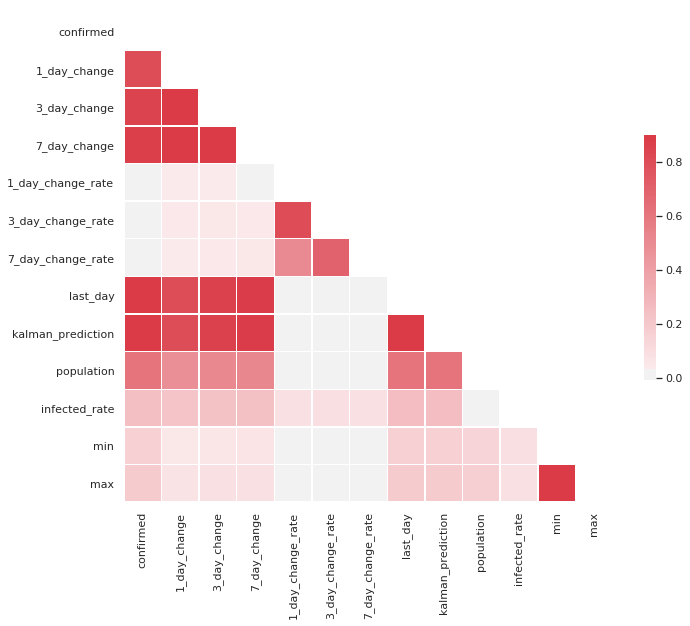

In [57]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [58]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.801572
3_day_change         0.853042
7_day_change         0.875273
1_day_change_rate    0.027202
3_day_change_rate    0.028083
7_day_change_rate    0.023164
last_day             0.989592
kalman_prediction    0.989924
population           0.614307
infected_rate        0.254696
min                  0.163959
max                  0.185852
Name: confirmed, dtype: float64


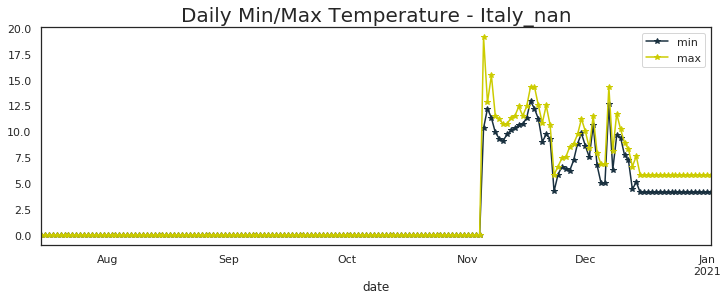

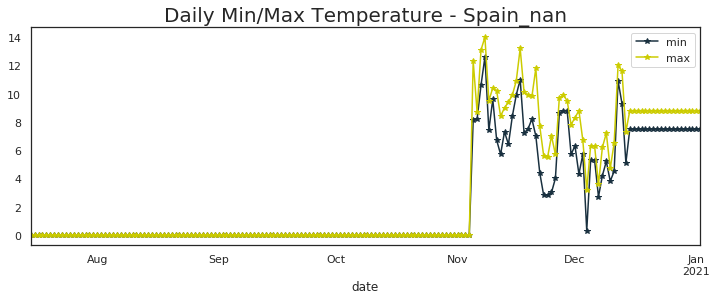

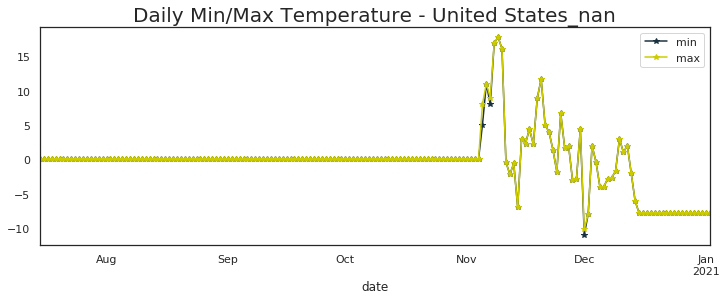

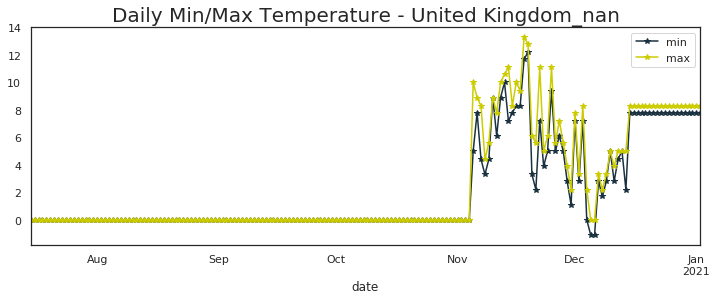

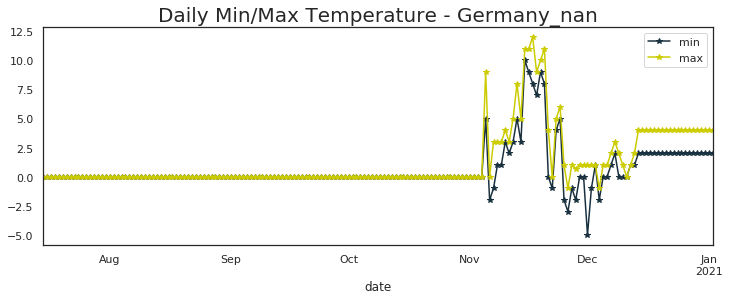

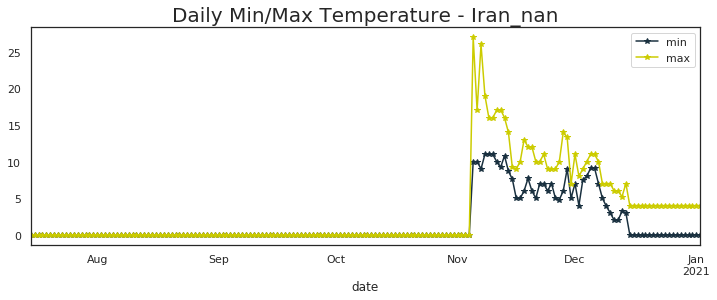

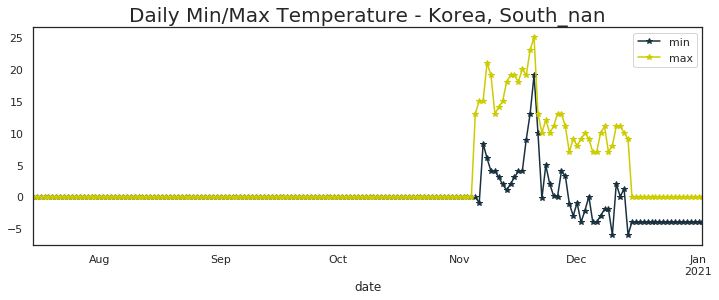

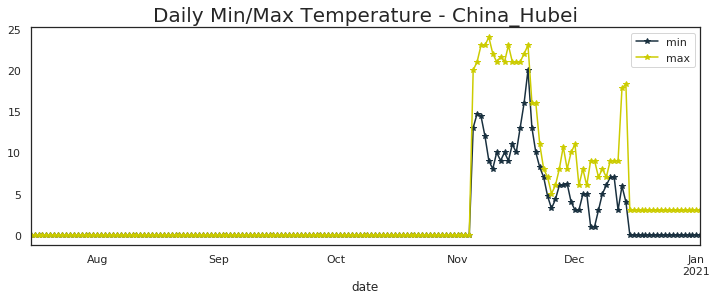

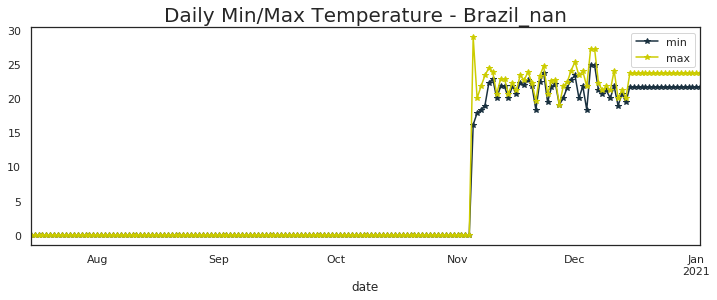

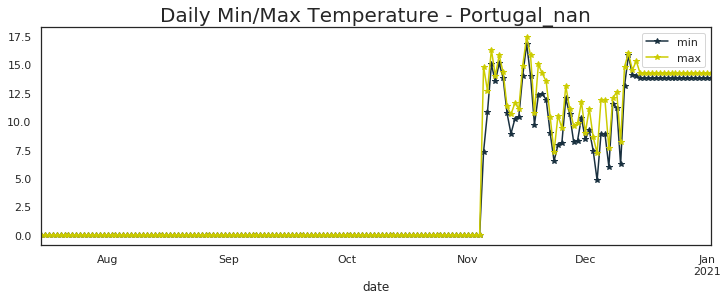

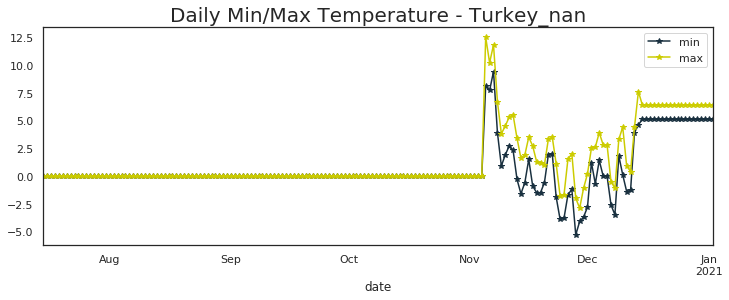

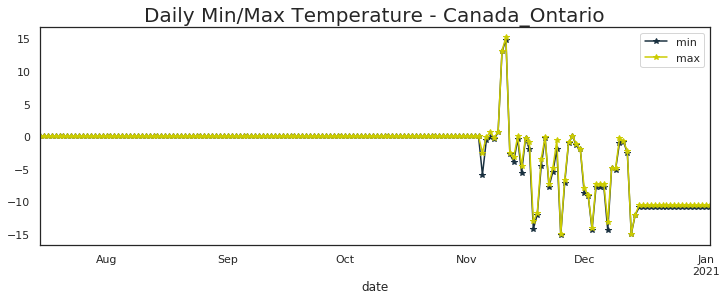

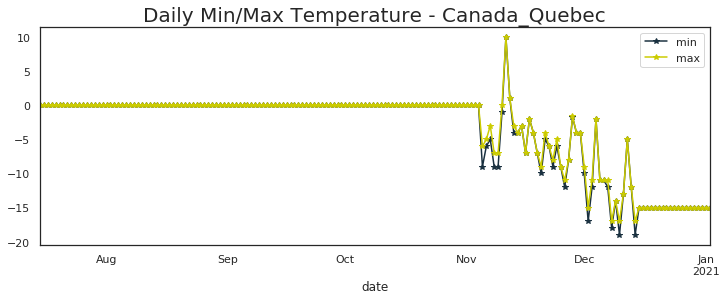

In [59]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [60]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                             min   max
region                                
United States_nan           17.8  17.8
India_nan                   22.0  31.0
Brazil_nan                  24.8  28.9
Russia_nan                   0.0   4.0
France_nan                  12.1  13.3
United Kingdom_nan          12.2  13.3
Turkey_nan                   9.4  12.5
Italy_nan                   12.9  19.1
Spain_nan                   12.6  14.0
Germany_nan                 10.0  12.0
Colombia_nan                 0.0   0.0
Argentina_nan                0.0   0.0
Mexico_nan                  15.1  15.1
Poland_nan                   8.9  10.6
Iran_nan                    11.0  27.0
Ukraine_nan                  0.0   0.0
South Africa_nan             0.0   0.0
Peru_nan                    24.6  29.9
Netherlands_nan             14.4  16.1
Indonesia_nan                0.0   0.0
Czechia_nan                  0.0   0.0
Belgium_nan                 13.7  14.5
Romania_nan                 

### Kalman X Days Ahead Prediction

In [61]:
%%R

#install.packages('reshape')

NULL


In [62]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [63]:
all_new=%R all_new

In [64]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

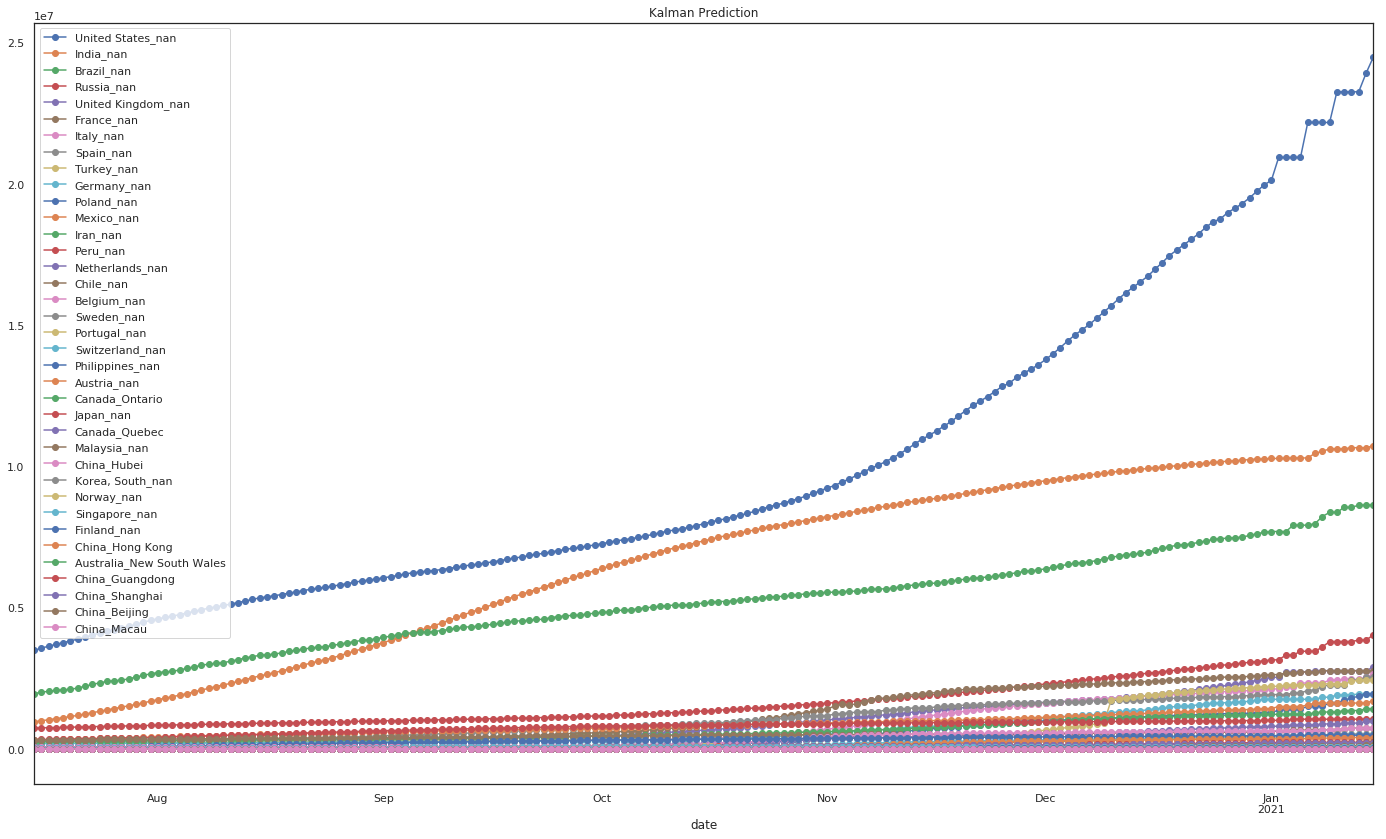

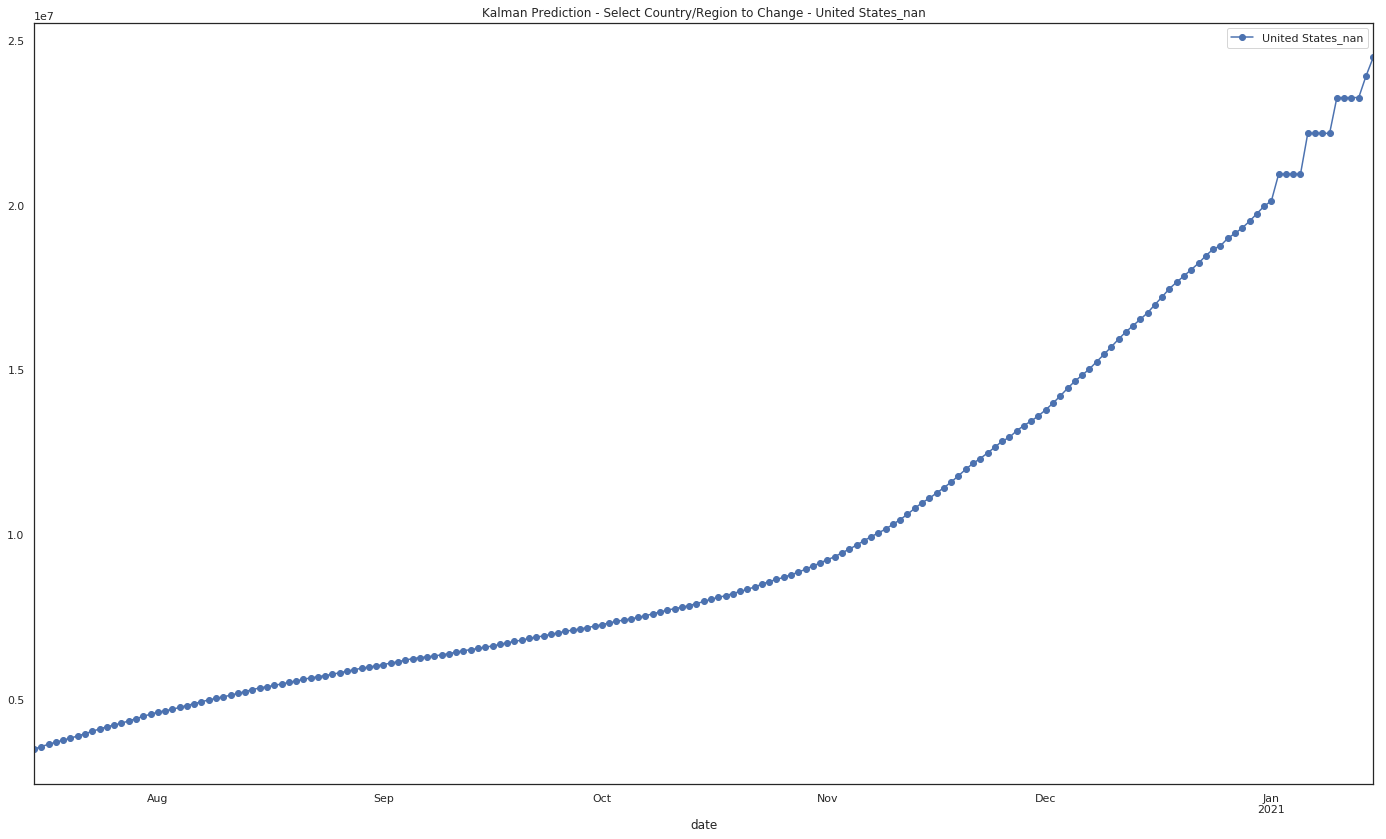

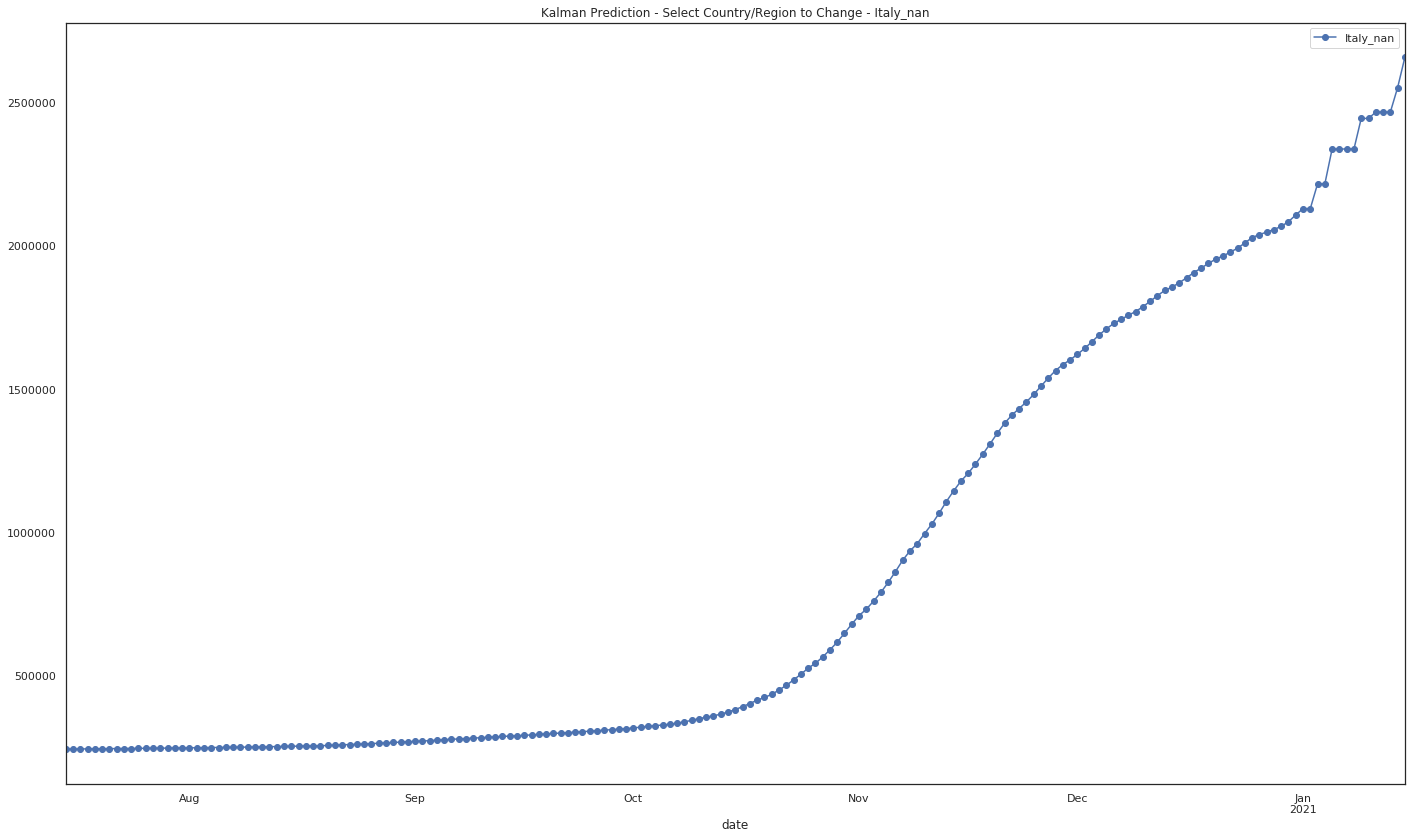

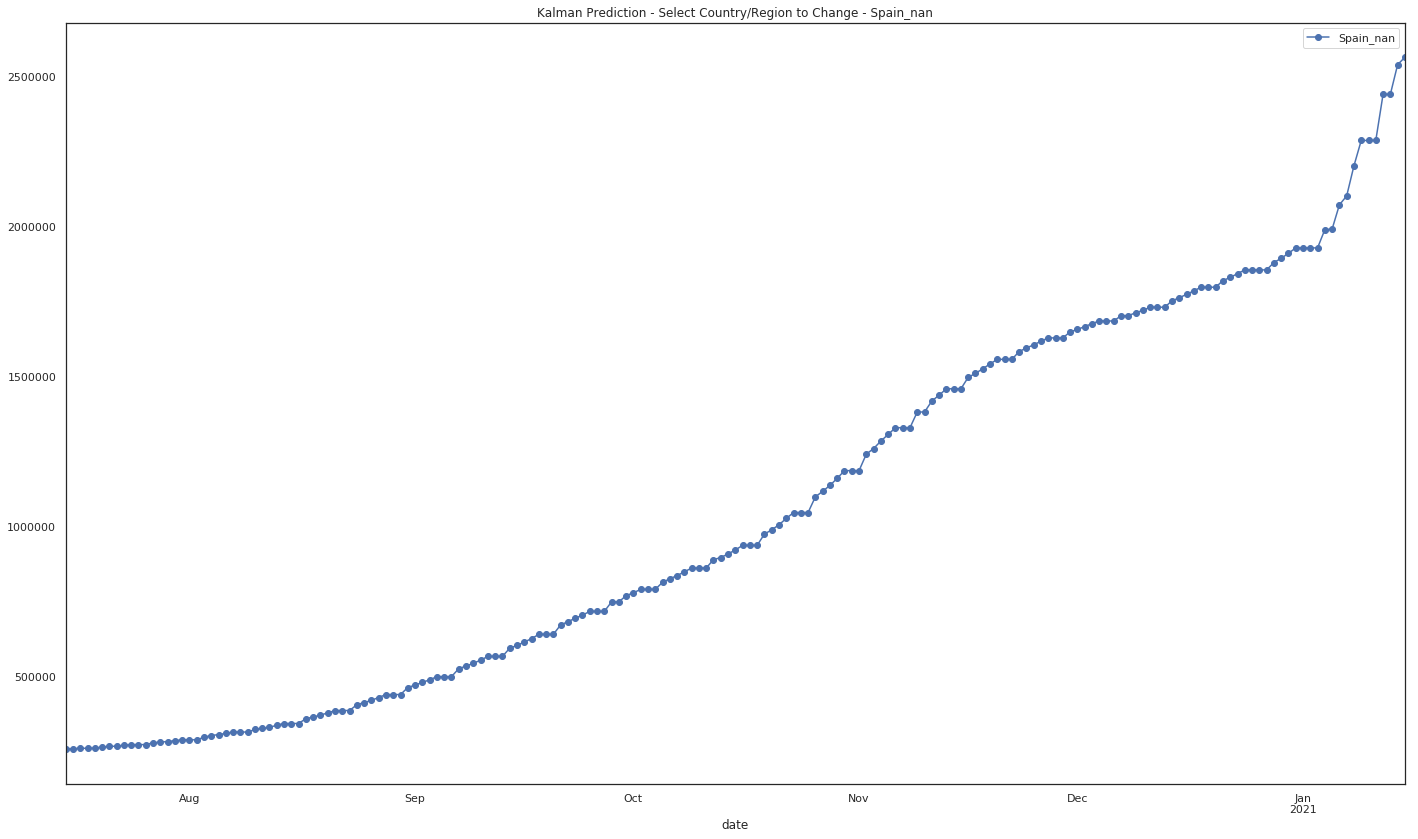

In [65]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


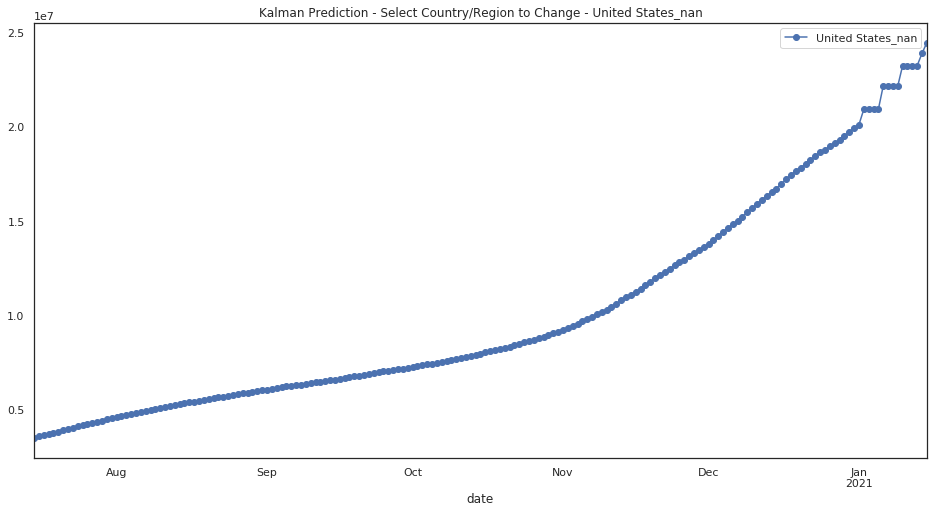

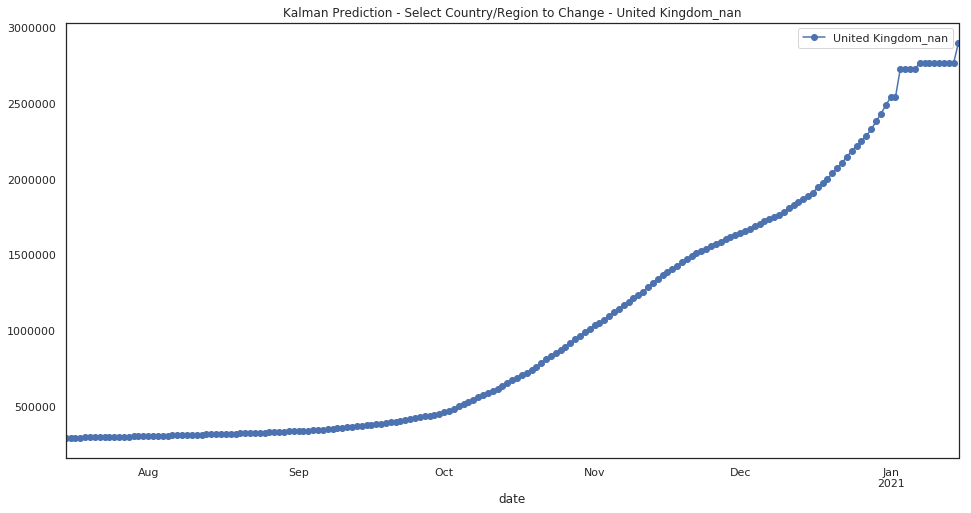

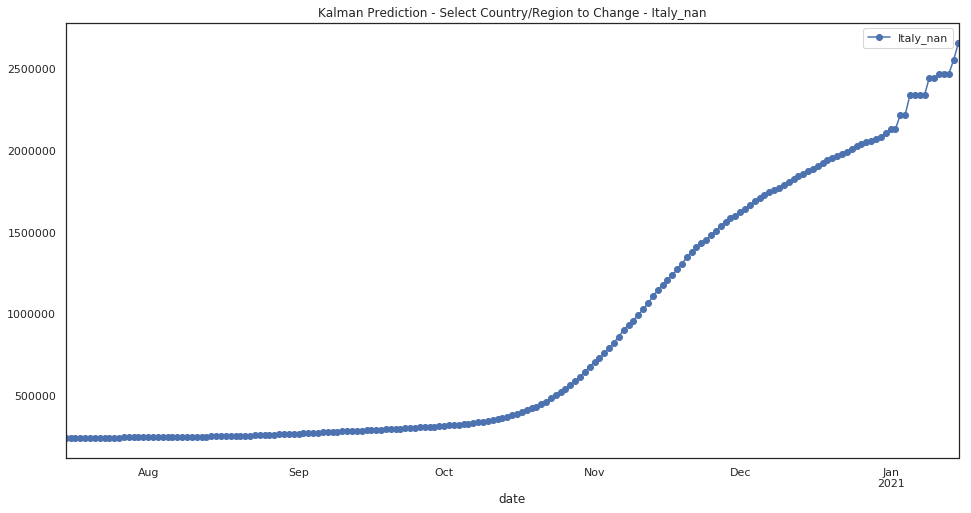

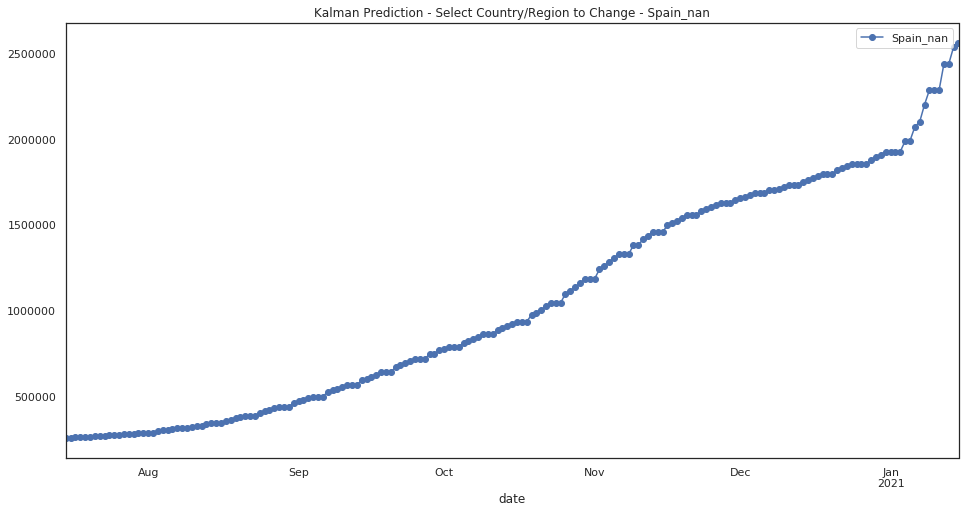

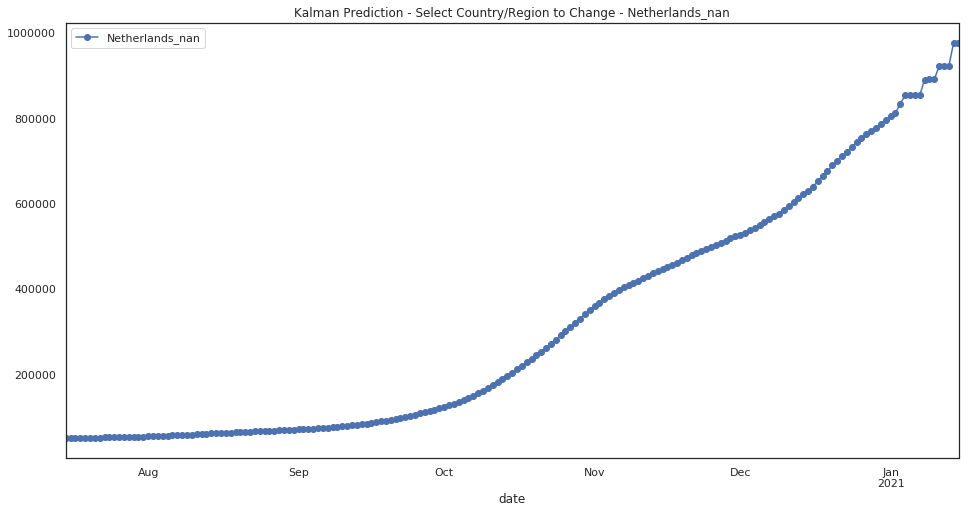

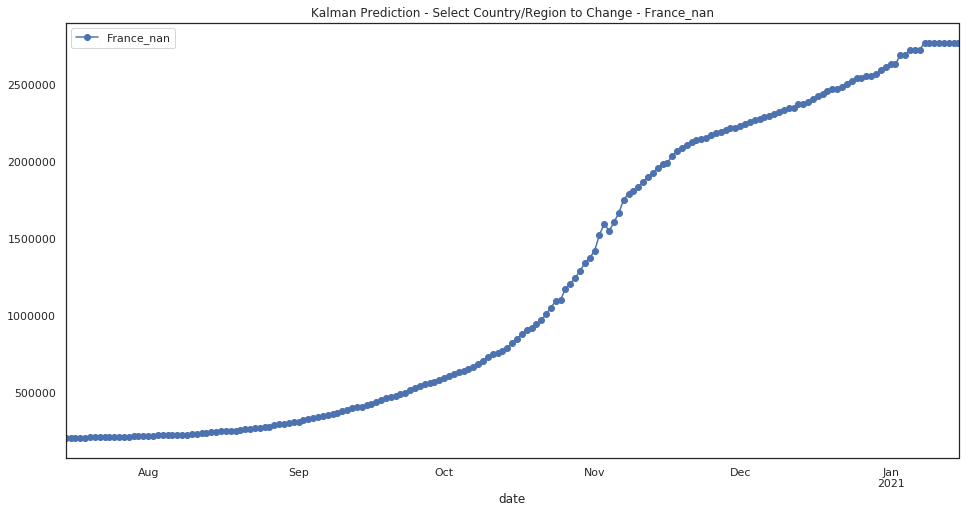

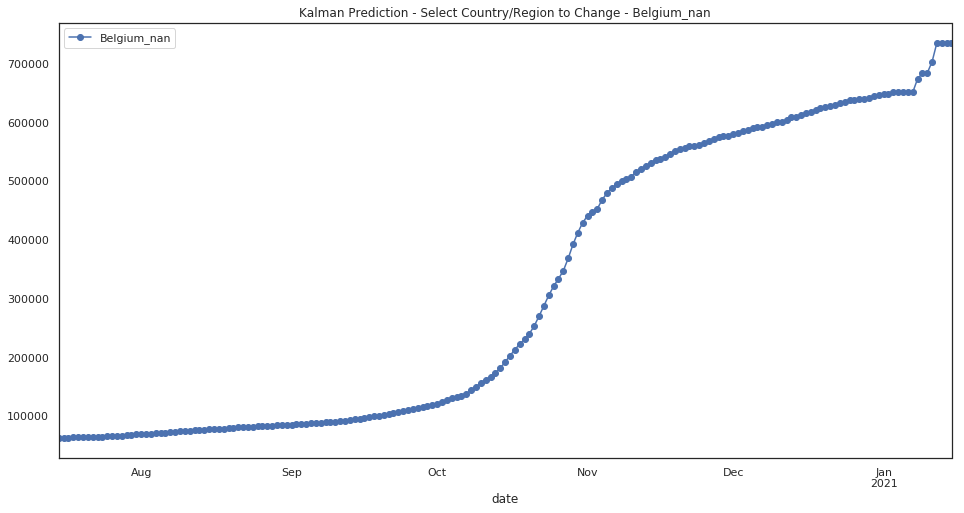

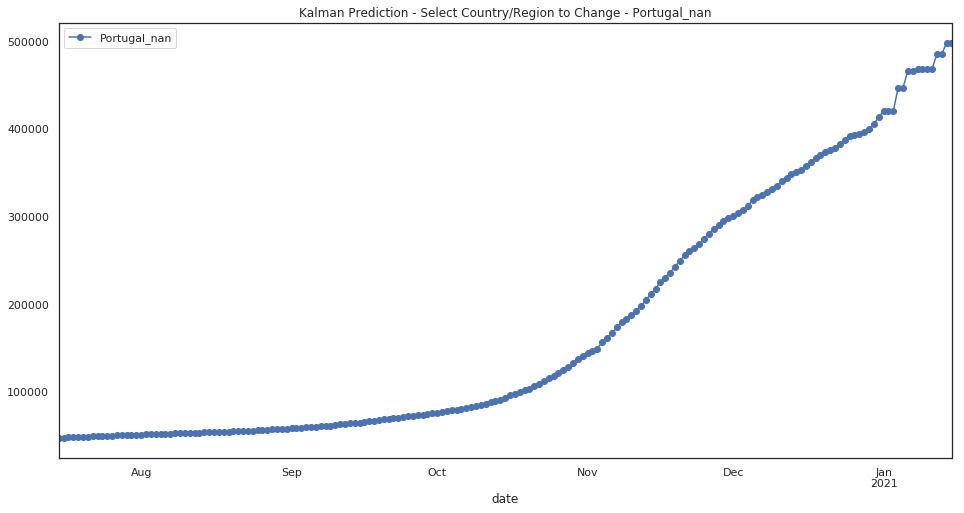

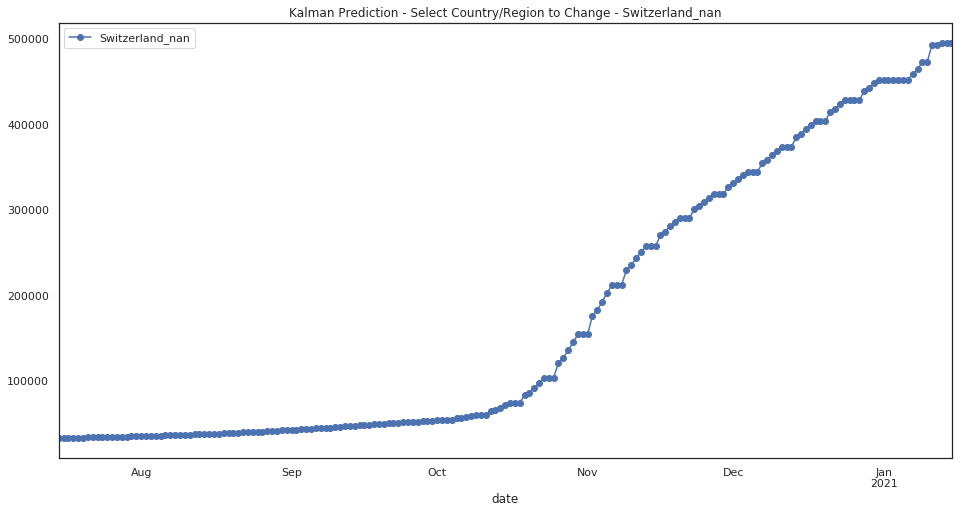

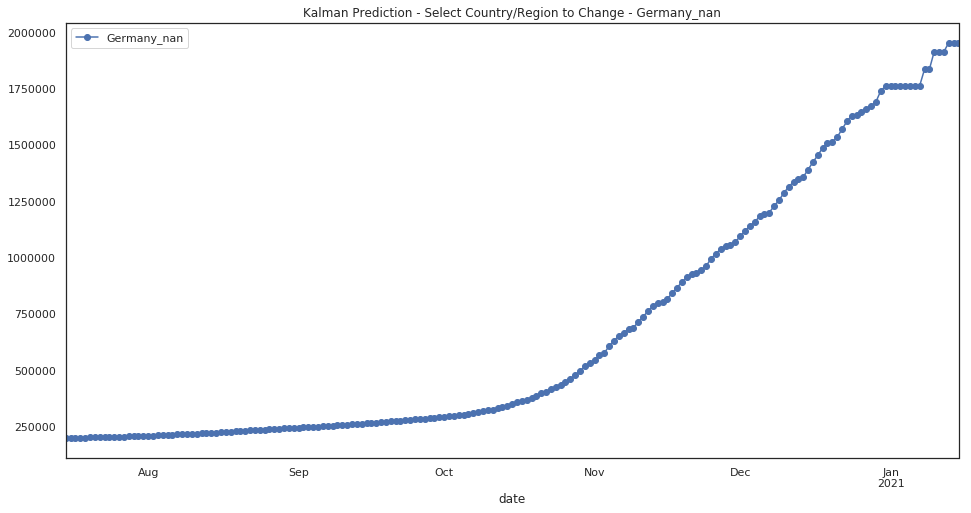

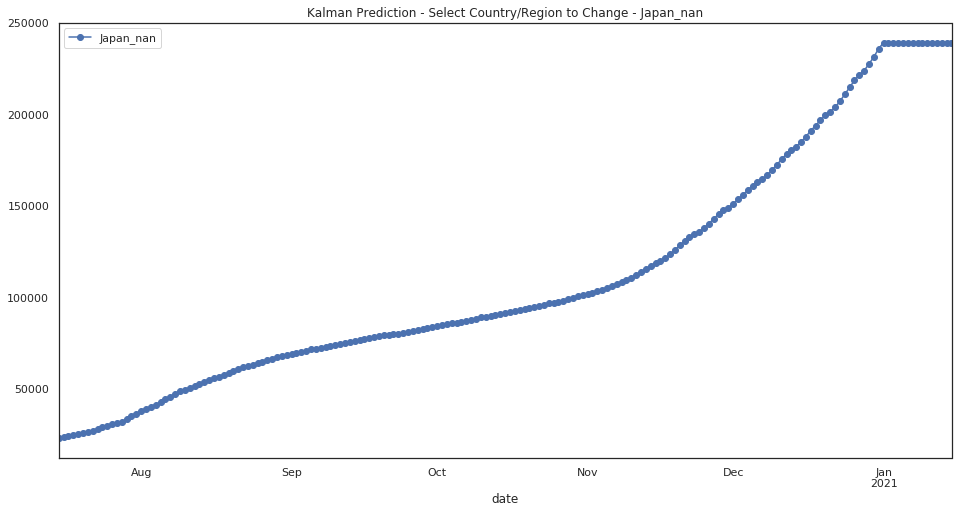

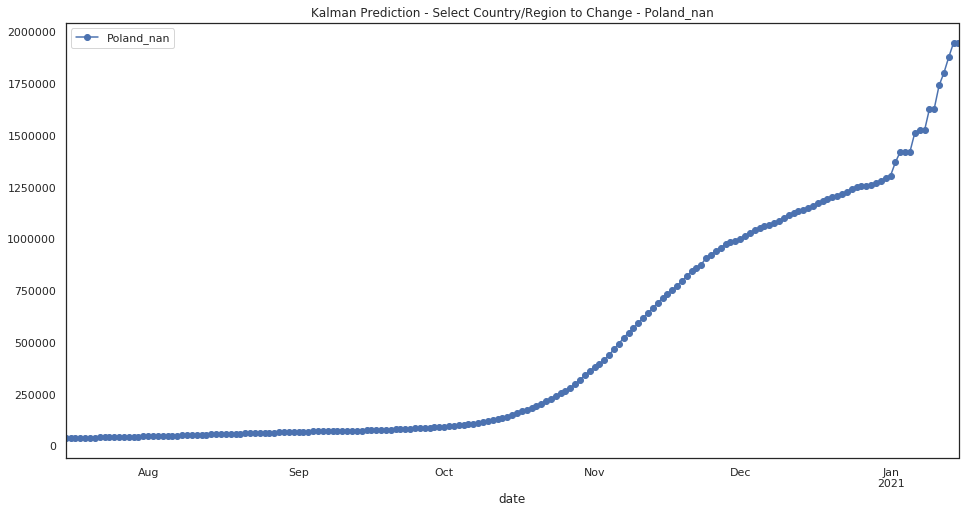

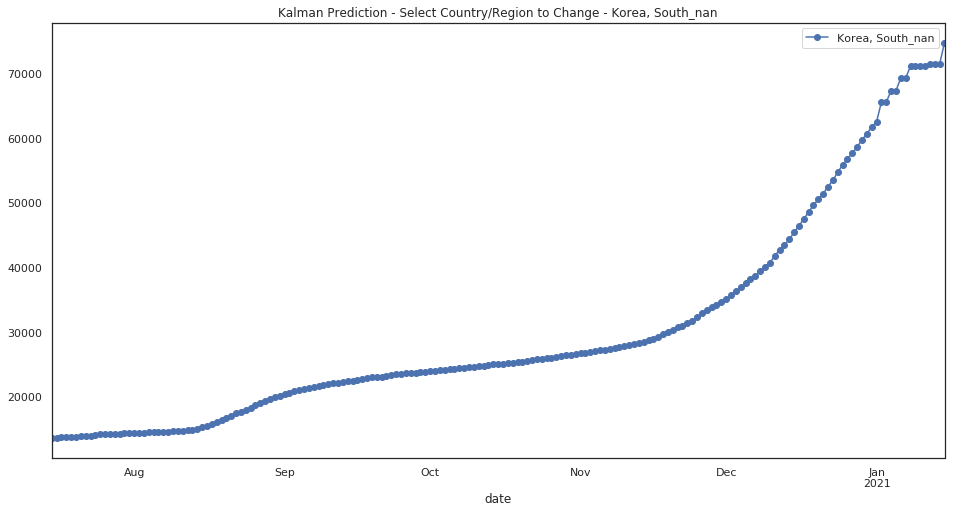

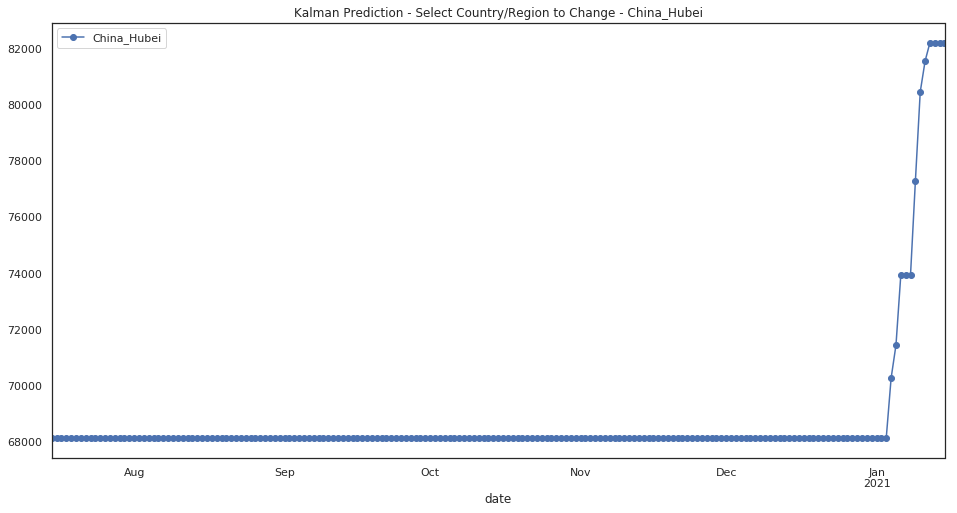

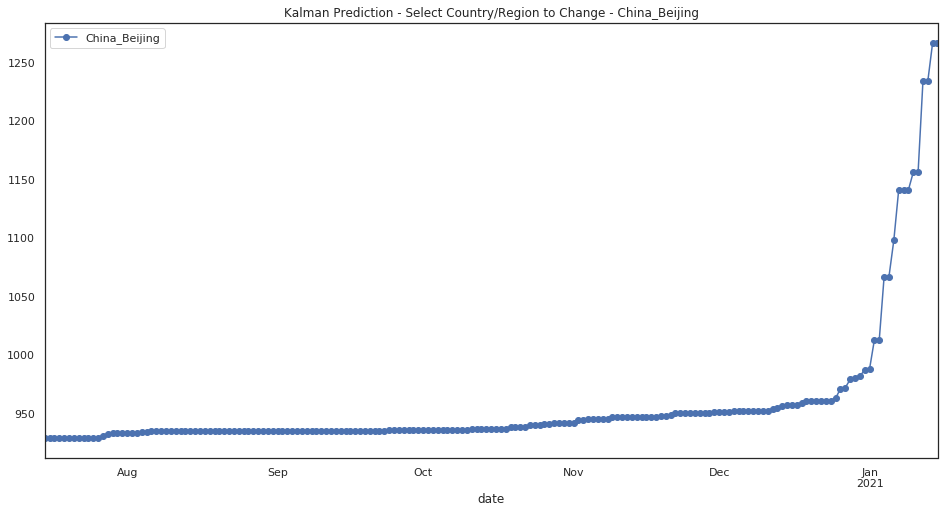

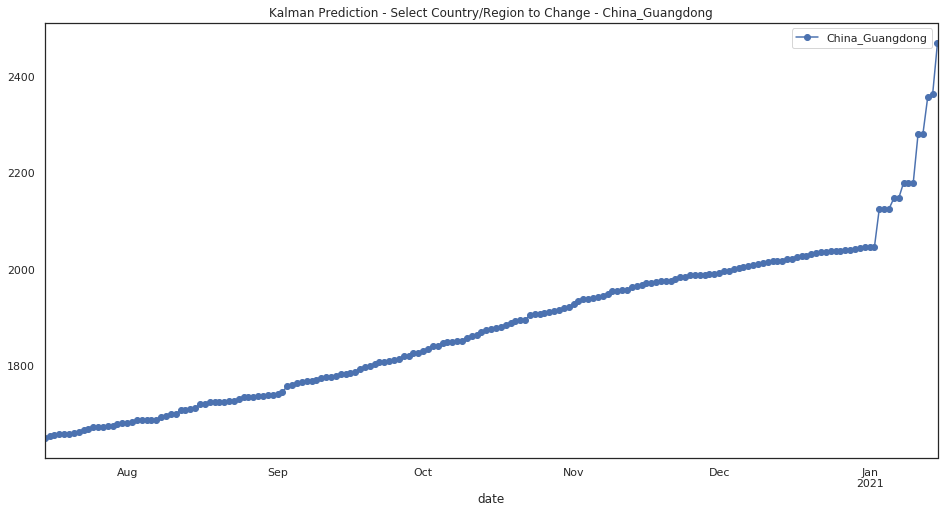

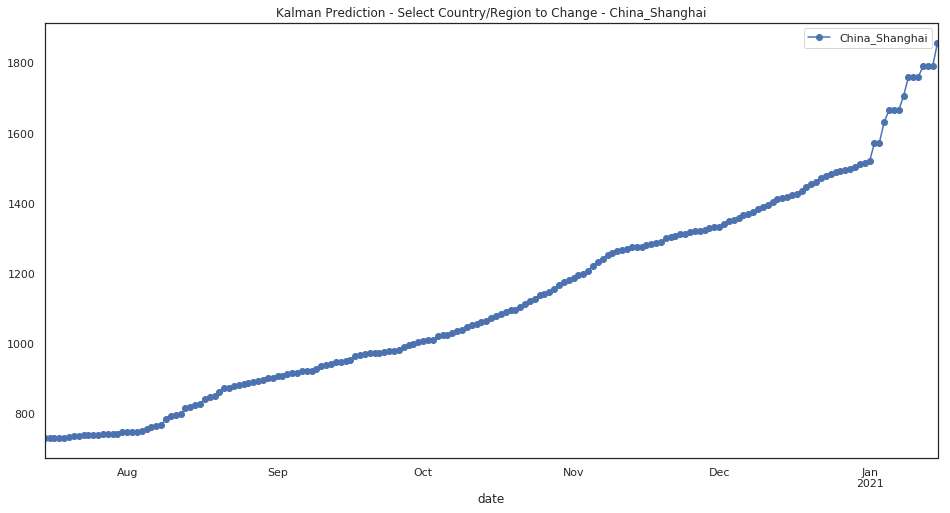

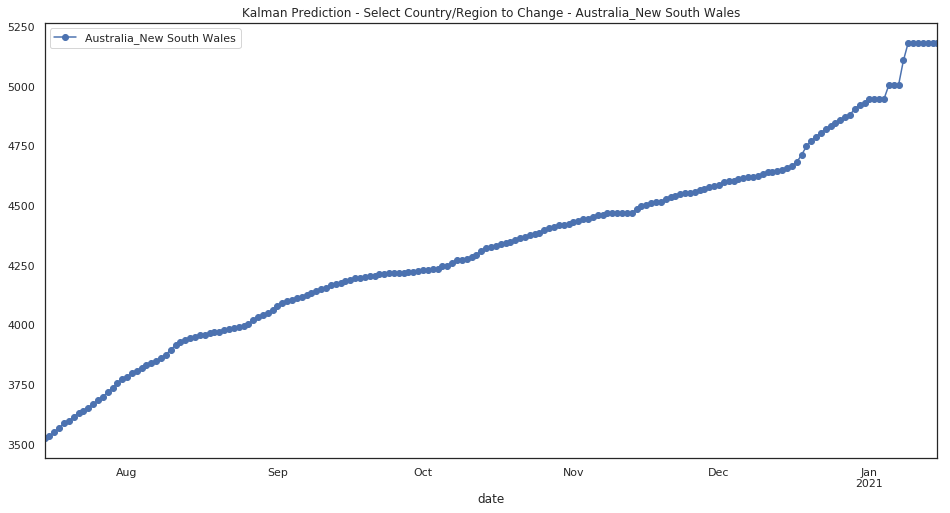

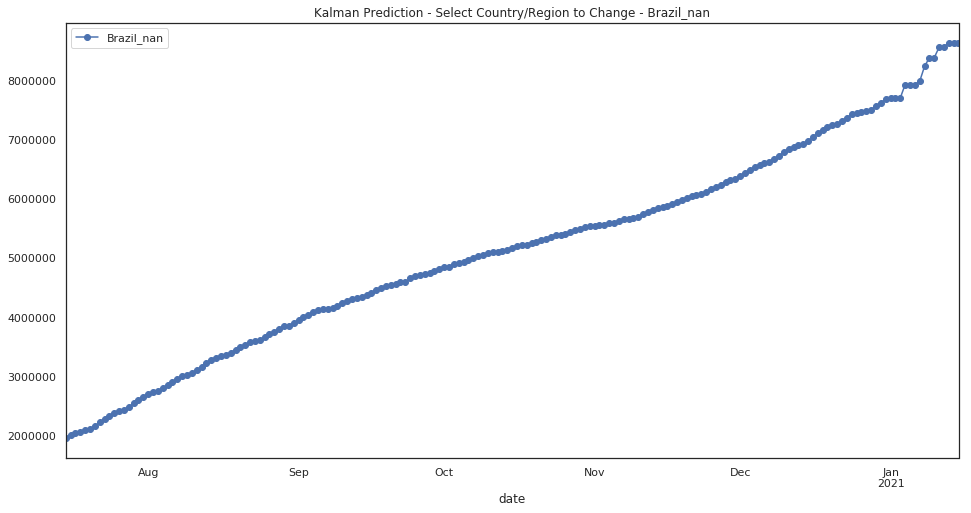

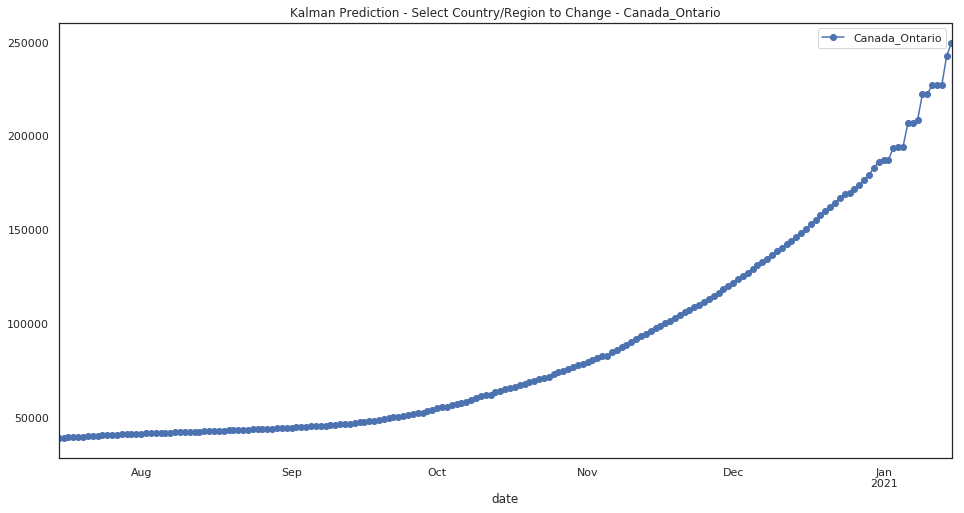

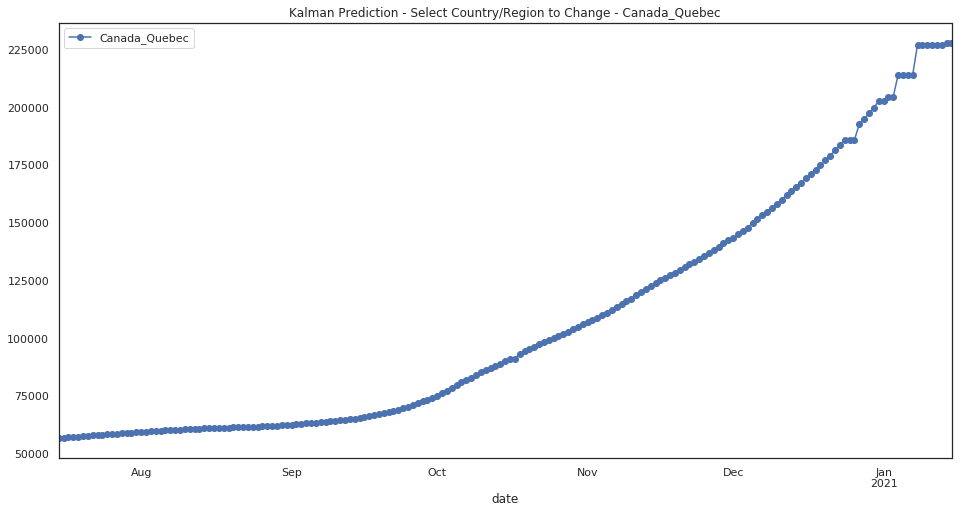

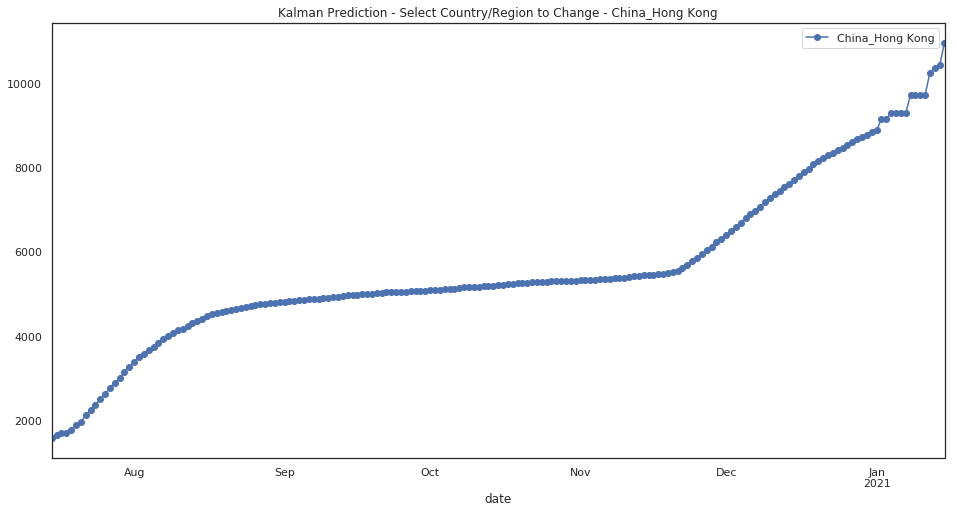

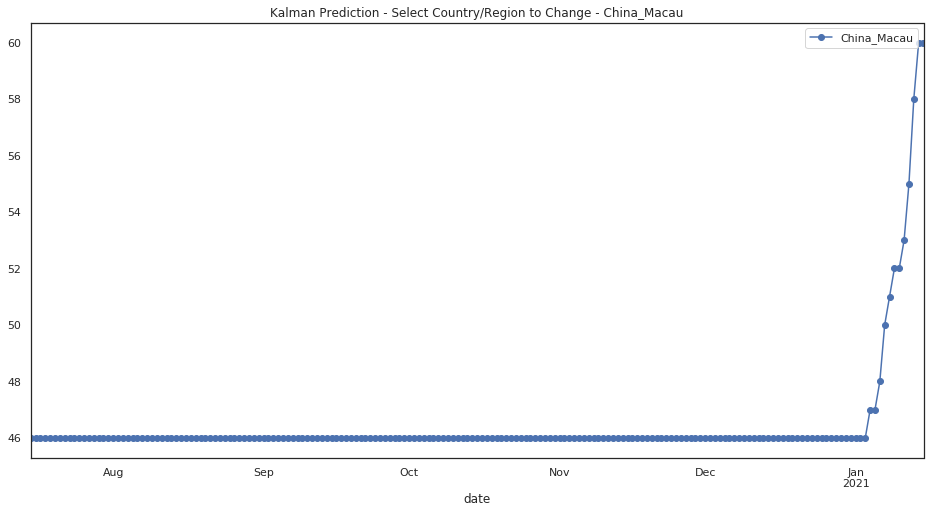

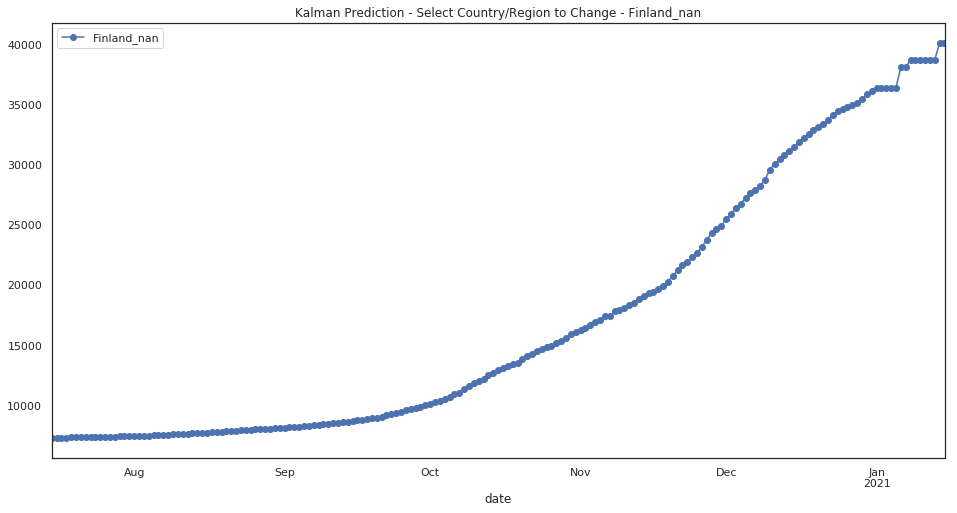

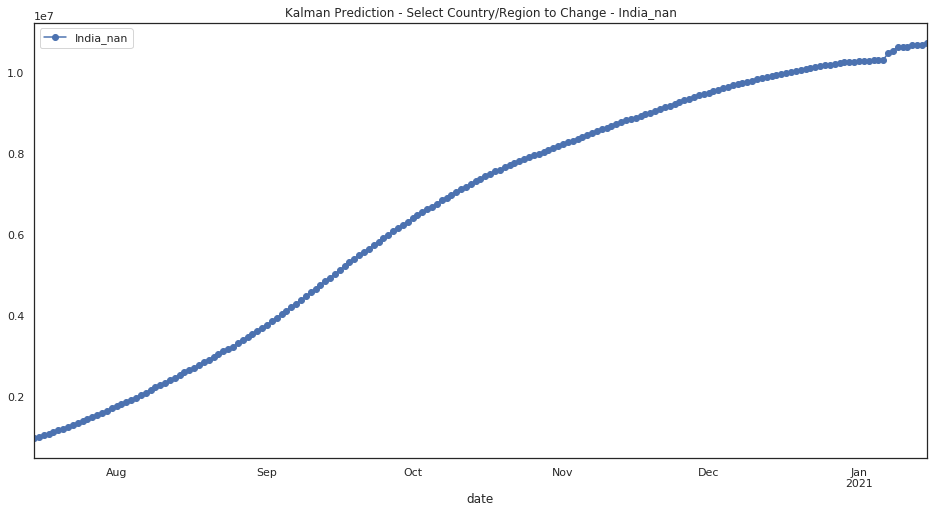

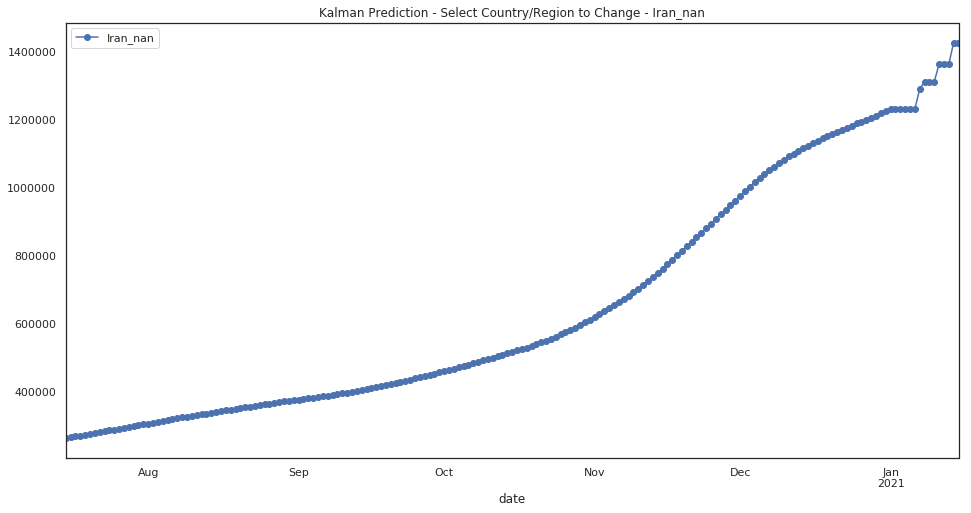

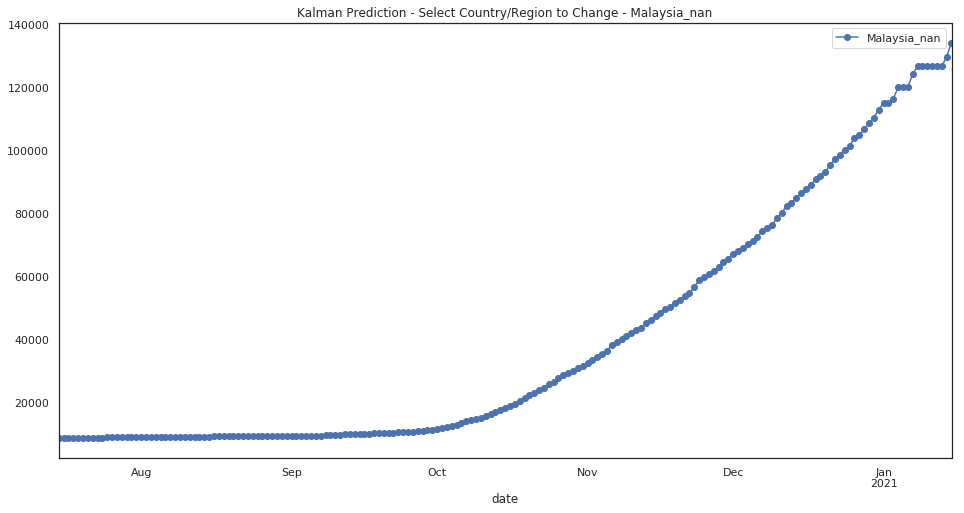

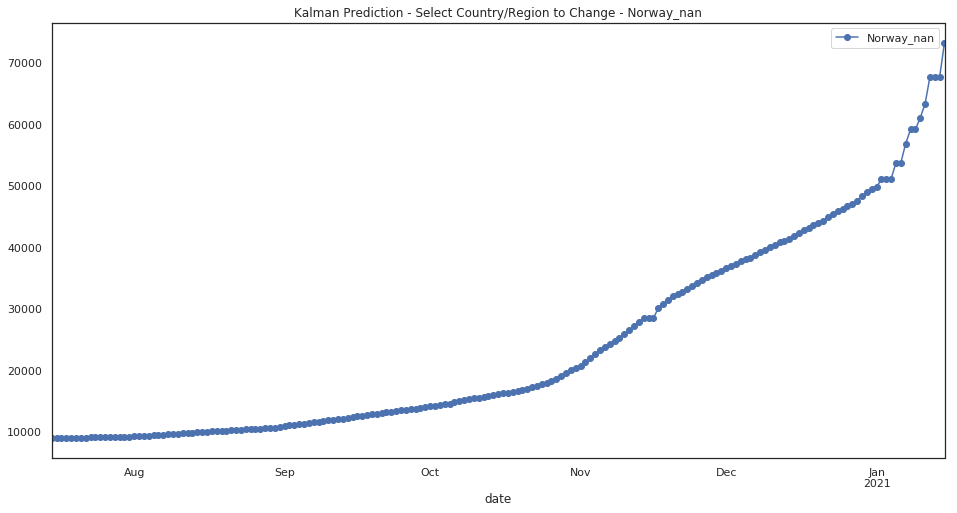

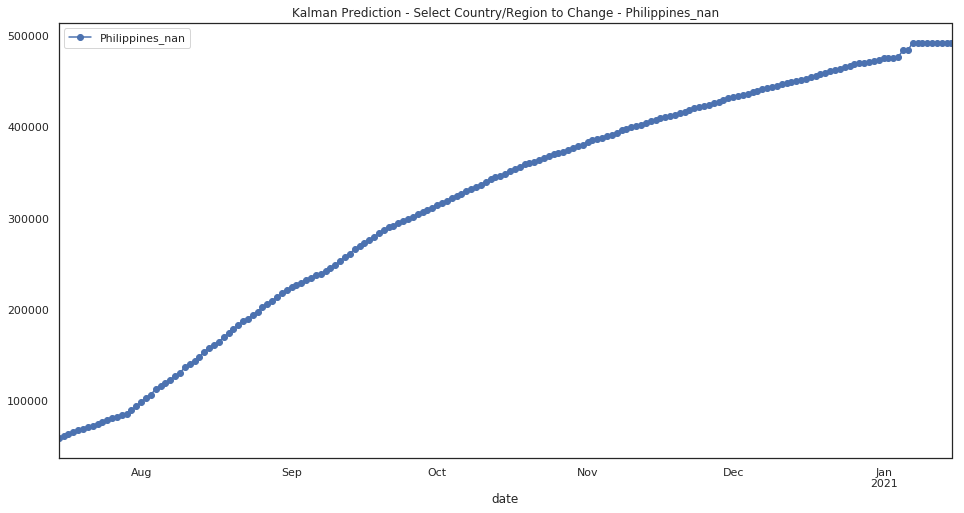

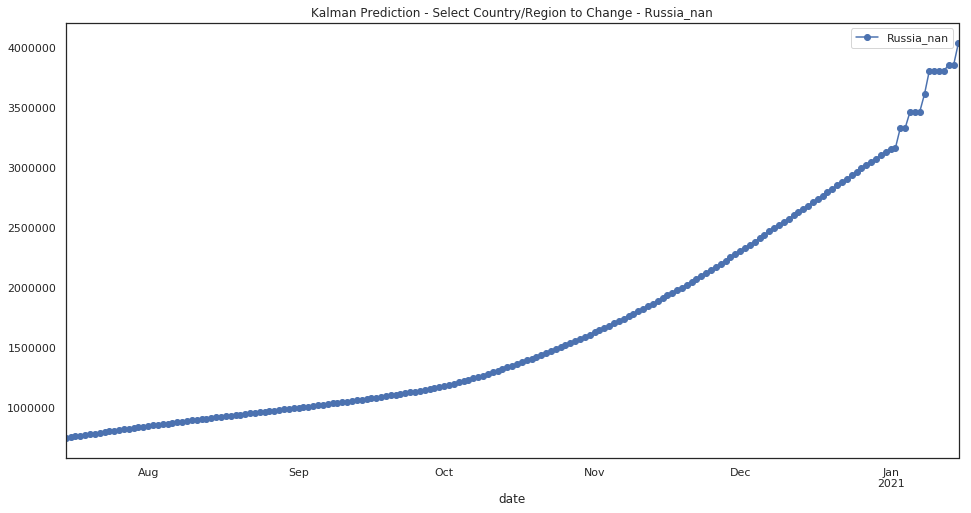

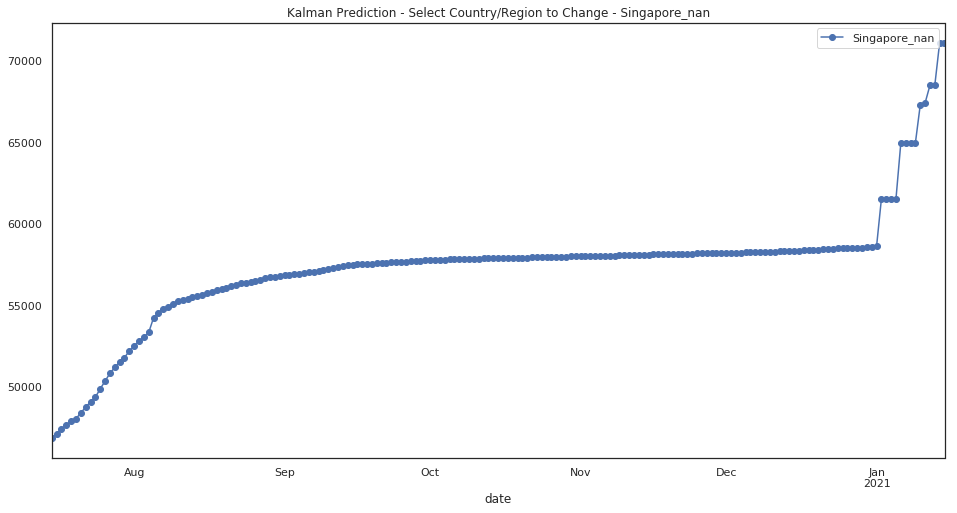

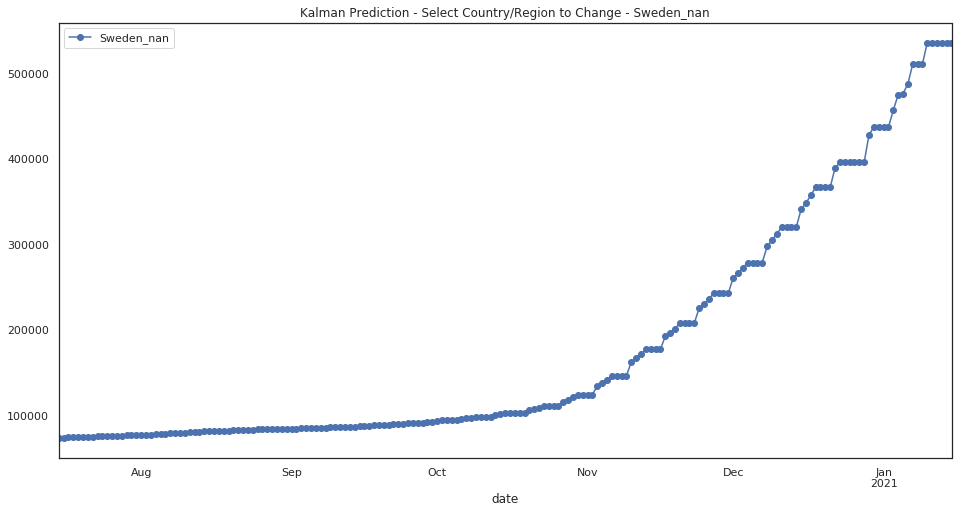

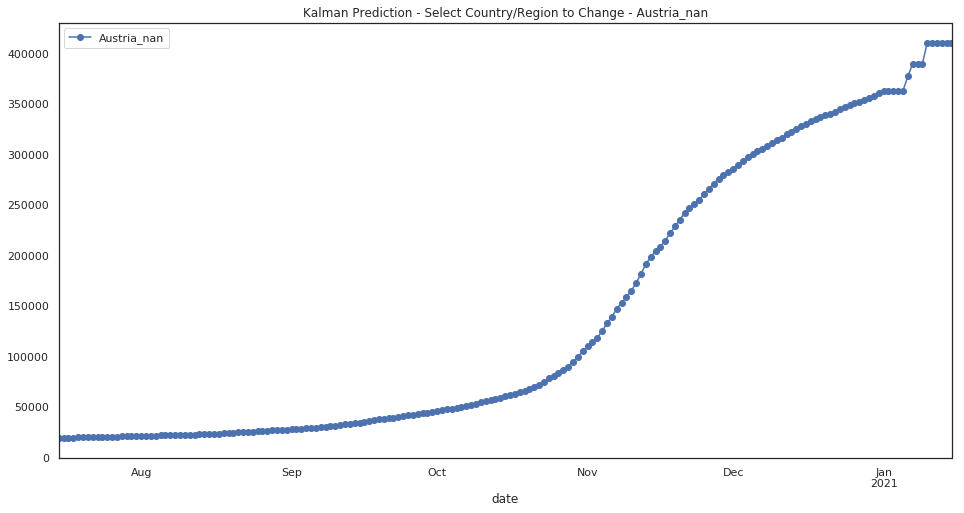

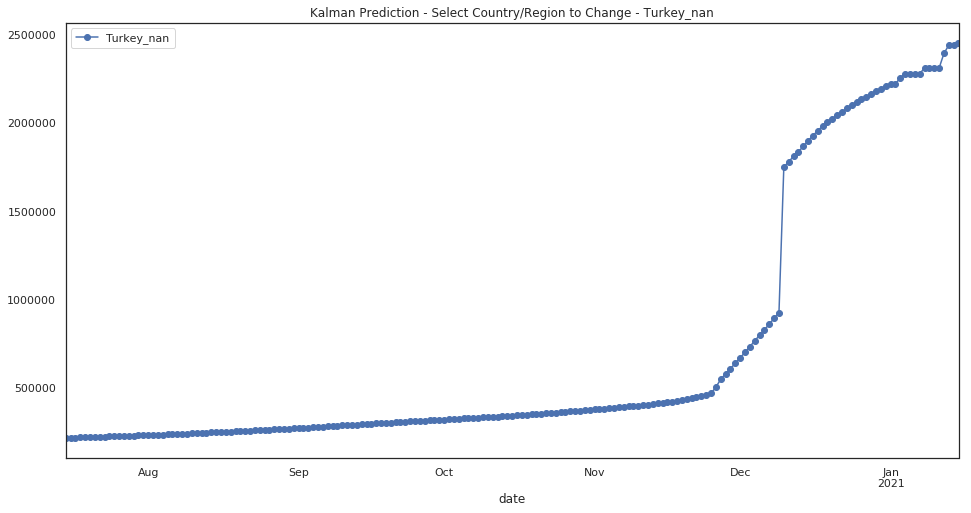

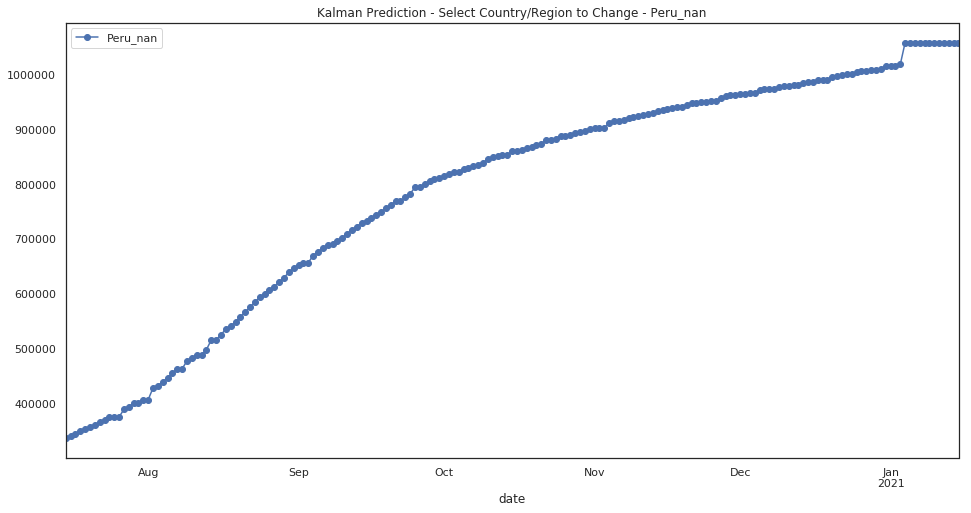

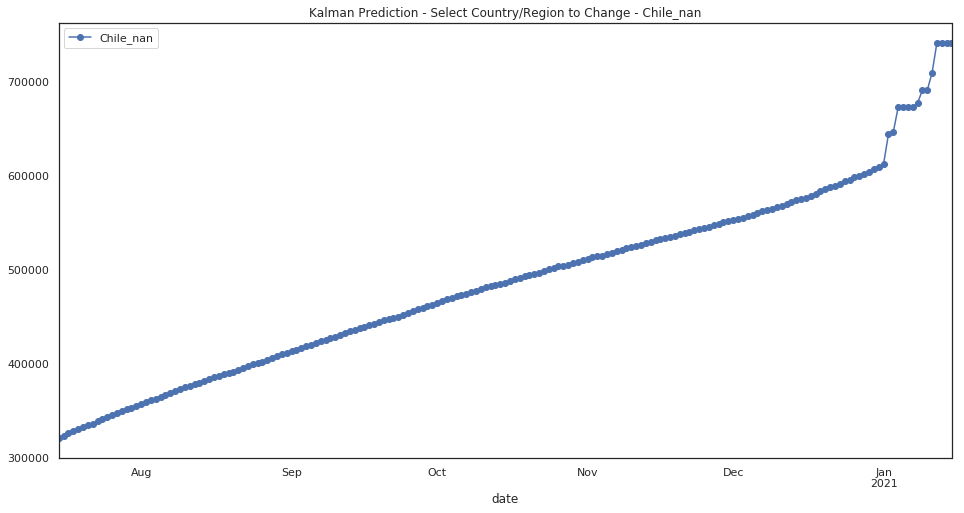

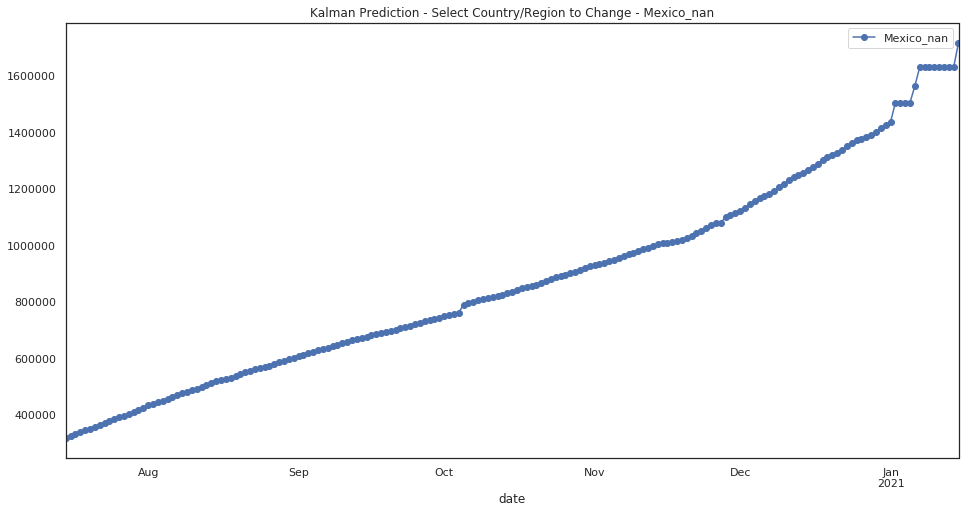

In [66]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [67]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2021-01-15 00:00:00
dtype: object


0  pred_confirmed
United States_nan                           NaN      24487179.0
India_nan                                   NaN      10734489.0
Brazil_nan                                  NaN       8633879.0
Russia_nan                                  NaN       4041030.0
United Kingdom_nan                          NaN       2903947.0
France_nan                                  NaN       2776296.0
Italy_nan                                   NaN       2657561.0
Spain_nan                                   NaN       2563799.0
Turkey_nan                                  NaN       2454716.0
Colombia_nan                                NaN       1968424.0
Argentina_nan                               NaN       1965696.0
Germany_nan                                 NaN       1953924.0
Poland_nan                                  NaN       1948139.0
Mexico_nan                                  NaN       1717726.0
Iran_nan                                    NaN       1427140.0
Ukraine_nan                                 NaN       1252515.0
South Africa_nan                            NaN       1195091.0
Peru_nan                                    NaN       1058094.0
Netherlands_nan                             NaN        977327.0
Indonesia_nan                               NaN        944983.0
Czechia_nan                                 NaN        785931.0
Romania_nan                                 NaN        758403.0
Chile_nan                                   NaN        741643.0
Belgium_nan                                 NaN        735448.0
Iraq_nan                                    NaN        691719.0
Pakistan_nan                                NaN        612454.0
Bangladesh_nan                              NaN        578648.0
Sweden_nan                                  NaN        536331.0
Morocco_nan                                 NaN        499992.0
Portugal_nan                                NaN        498794.0
...                                         ...             ...
Australia_Australian Capital Territory      NaN           122.0
Canada_Prince Edward Island                 NaN           103.0
United Kingdom_British Virgin Islands       NaN           101.0
Dominica_nan                                NaN            93.0
China_Ningxia                               NaN            90.0
Australia_Northern Territory                NaN            82.0
Canada_Yukon                                NaN            67.0
China_Macau                                 NaN            60.0
Fiji_nan                                    NaN            54.0
Timor-Leste_nan                             NaN            50.0
Laos_nan                                    NaN            48.0
France_New Caledonia                        NaN            41.0
Saint Kitts and Nevis_nan                   NaN            38.0
Denmark_Greenland                           NaN            34.0
United Kingdom_Falkland Islands (Malvinas)  NaN            31.0
Holy See_nan                                NaN            29.0
Canada_Northwest Territories                NaN            24.0
Solomon Islands_nan                         NaN            21.0
China_Qinghai                               NaN            19.0
France_Saint Pierre and Miquelon            NaN            18.0
United Kingdom_Montserrat                   NaN            15.0
Canada_Repatriated Travellers               NaN            14.0
United Kingdom_Anguilla                     NaN            14.0
Canada_Grand Princess                       NaN            14.0
MS Zaandam_nan                              NaN             9.0
Marshall Islands_nan                        NaN             4.0
Samoa_nan                                   NaN             2.0
China_Tibet                                 NaN             1.0
Vanuatu_nan                                 NaN             1.0
Canada_Diamond Princess                     NaN             0.0

[271 rows x 2 columns]

In [68]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [69]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [70]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [71]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [72]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [73]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-07-15          39920.0      12745.0      27553.0      10231.0   
2020-07-16          39986.0      12831.0      28062.0      10244.0   
2020-07-17          35060.0       3851.0      21355.0        877.0   
2020-07-18          35219.0       3906.0      21948.0        880.0   
2020-07-19          35279.0       4008.0      22934.0        880.0   
2020-07-20          35453.0       4090.0      23532.0        880.0   
2020-07-21          35493.0       4171.0      24130.0        884.0   
2020-07-22          35605.0       4290.0      24726.0        884.0   
2020-07-23          35963.0       4452.0      25411.0        958.0   
2020-07-24          36063.0       4487.0      26081.0       1014.0   
2020-07-25          36087.0       4570.0      26706.0        934.0   
2020-07-26          36192.0       4755.0      27299.0       1020.0   
2020-07-27          36313.0       4773.0      27909.0       1028.0   
2020-07-28          36414.0       4914.0      28547.0        922.0   
2020-07-29          36524.0       5039.0      29170.0       1043.0   
2020-07-30          36597.0       5147.0      29774.0        938.0   
2020-07-31          36720.0       5250.0      30343.0       1016.0   
2020-08-01          36778.0       5378.0      30897.0       1028.0   
2020-08-02          36759.0       5442.0      31417.0       1051.0   
2020-08-03          36787.0       5551.0      31919.0       1058.0   
2020-08-04          36828.0       5717.0      32450.0        940.0   
2020-08-05          36878.0       5818.0      33010.0       1052.0   
2020-08-06          36988.0       5941.0      33590.0       1074.0   
2020-08-07          37085.0       6099.0      34137.0       1026.0   
2020-08-08          37131.0       6218.0      34671.0        974.0   
2020-08-09          37160.0       6366.0      35150.0       1091.0   
2020-08-10          37217.0       6481.0      35675.0       1094.0   
2020-08-11          37323.0       6633.0      36191.0       1007.0   
2020-08-12          37411.0       6762.0      36674.0       1103.0   
2020-08-13          37491.0       6917.0      37171.0        979.0   
...                     ...          ...          ...          ...   
2020-12-18          49691.0      52097.0      94428.0       8020.0   
2020-12-19          49770.0      52583.0      94853.0       8044.0   
2020-12-20          49838.0      53061.0      95269.0       8074.0   
2020-12-21          50053.0      53467.0      95728.0       8122.0   
2020-12-22          50246.0      53856.0      96162.0       8142.0   
2020-12-23          50488.0      54355.0      96620.0       8172.0   
2020-12-24          50737.0      54912.0      97109.0       8204.0   
2020-12-25          50896.0      55489.0      97536.0       8266.0   
2020-12-26          50969.0      55915.0      97947.0       8301.0   
2020-12-27          51076.0      56349.0      98331.0       8332.0   
2020-12-28          51322.0      56726.0      98704.0       8409.0   
2020-12-29          51442.0      57204.0      99063.0       8423.0   
2020-12-30          51458.0      57864.0      99381.0       8495.0   
2020-12-31          51572.0      58456.0      99678.0       8555.0   
2021-01-01          51606.0      58550.0      99964.0       8626.0   
2021-01-02          52497.0      60877.0     100003.0       8641.0   
2021-01-03          52939.0      62132.0     102499.0       8688.0   
2021-01-04          52638.0      61230.0     104015.0       8679.0   
2021-01-05          52655.0      61253.0     102880.0       8671.0   
2021-01-06          52585.0      63946.0     106562.0       8966.0   
2021-01-07          52589.0      65452.0     108532.0       8800.0   
2021-01-08          52598.0      64476.0     107087.0       9074.0   
2021-01-09          52598.0      64476.0     107087.0       9194.0   
2021-01-10          52674.0      67212.0     110638.0       9206.0   
2021-01-11

In [74]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [75]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'Russia_nan',
 'United Kingdom_nan',
 'France_nan',
 'Italy_nan',
 'Spain_nan',
 'Turkey_nan',
 'Colombia_nan',
 'Argentina_nan',
 'Germany_nan',
 'Poland_nan',
 'Mexico_nan',
 'Iran_nan',
 'Ukraine_nan',
 'South Africa_nan',
 'Peru_nan',
 'Netherlands_nan',
 'Indonesia_nan',
 'Czechia_nan',
 'Romania_nan',
 'Chile_nan',
 'Belgium_nan',
 'Iraq_nan',
 'Pakistan_nan',
 'Bangladesh_nan',
 'Sweden_nan',
 'Morocco_nan',
 'Portugal_nan',
 'Switzerland_nan',
 'Philippines_nan',
 'Israel_nan',
 'Serbia_nan',
 'Austria_nan',
 'Saudi Arabia_nan',
 'Jordan_nan',
 'Hungary_nan',
 'Panama_nan',
 'Azerbaijan_nan',
 'Nepal_nan',
 'Ecuador_nan',
 'United Arab Emirates_nan',
 'Kazakhstan_nan',
 'Canada_Ontario',
 'Croatia_nan',
 'Georgia_nan',
 'Bulgaria_nan',
 'Japan_nan',
 'Slovakia_nan',
 'Lebanon_nan',
 'Canada_Quebec',
 'Belarus_nan',
 'Costa Rica_nan',
 'Kuwait_nan',
 'Denmark_nan',
 'Dominican Republic_nan',
 'Bolivia_nan',
 'Egypt_nan',
 'Arme

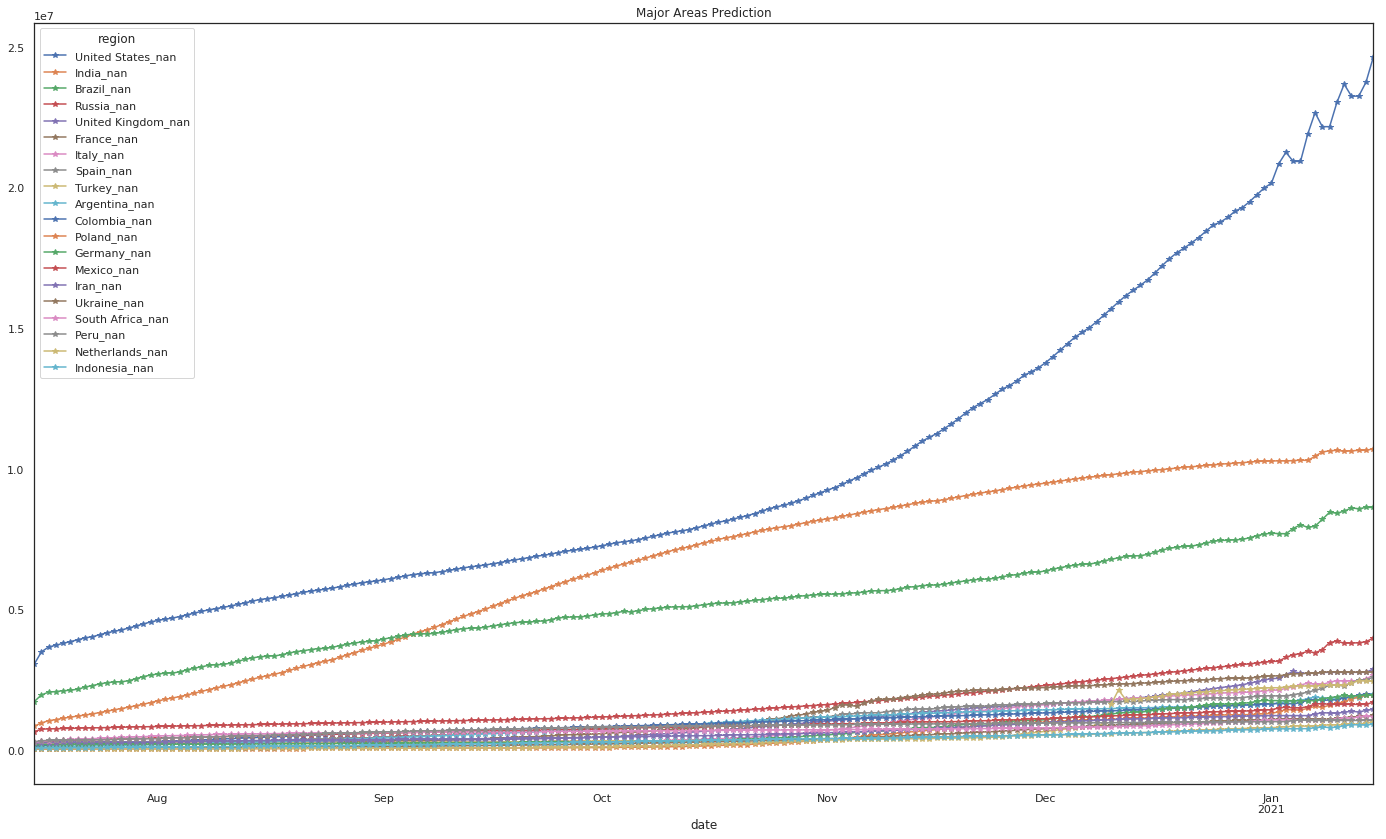

In [76]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

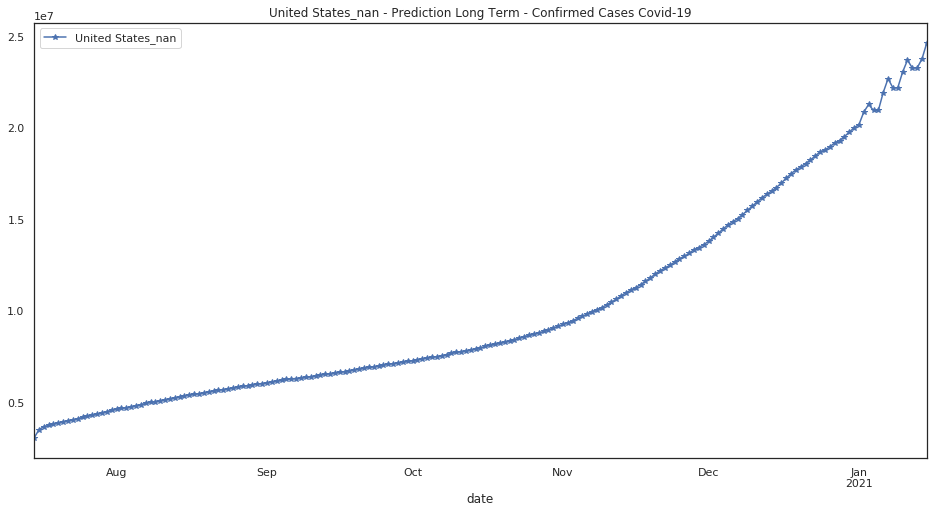

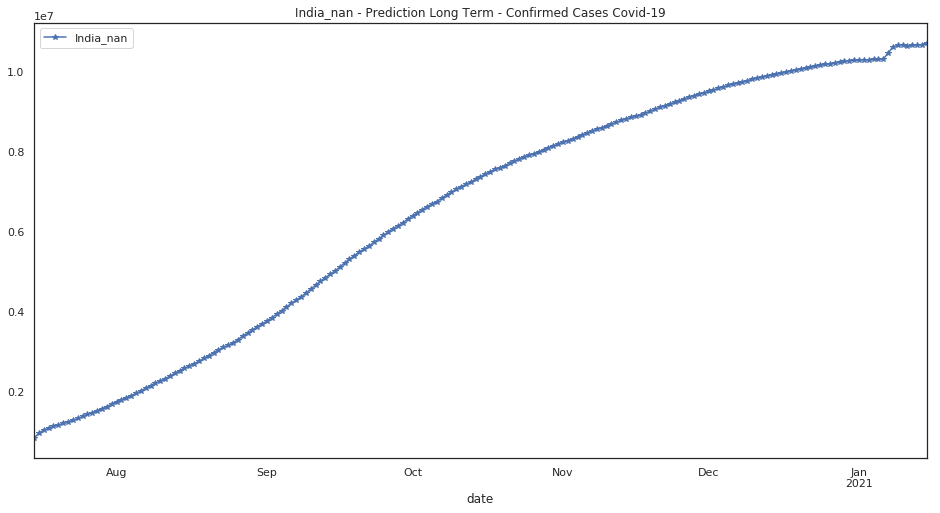

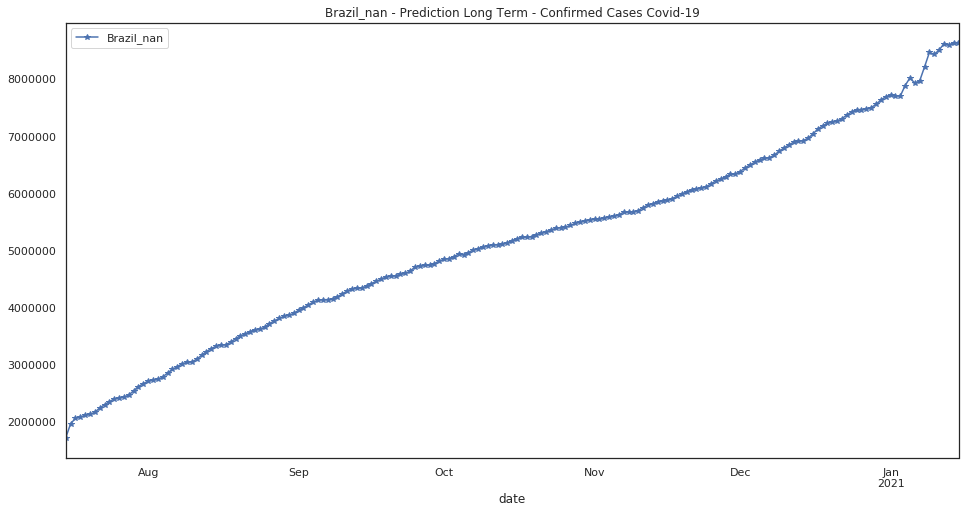

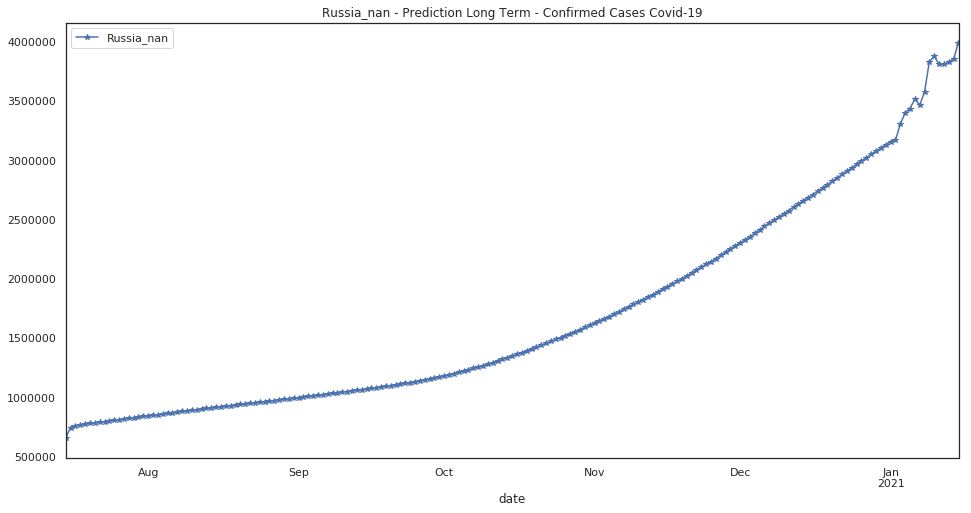

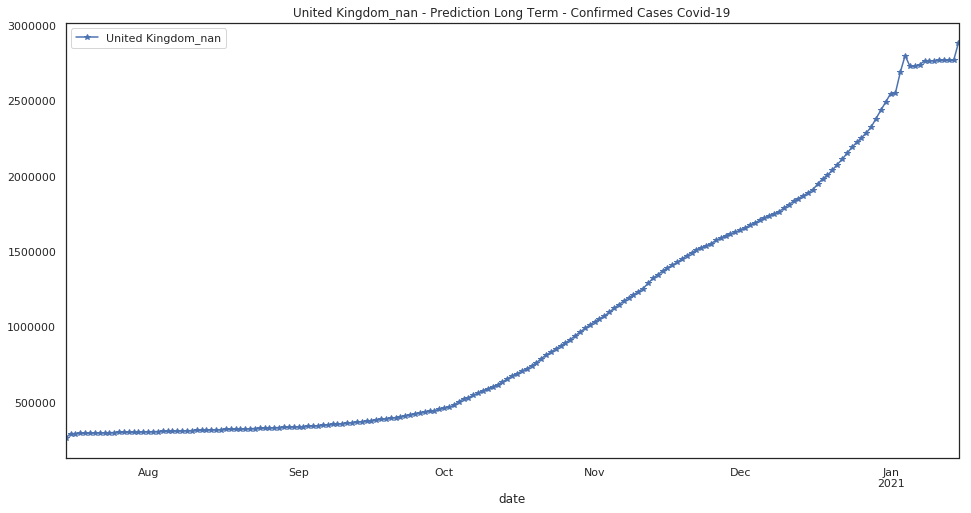

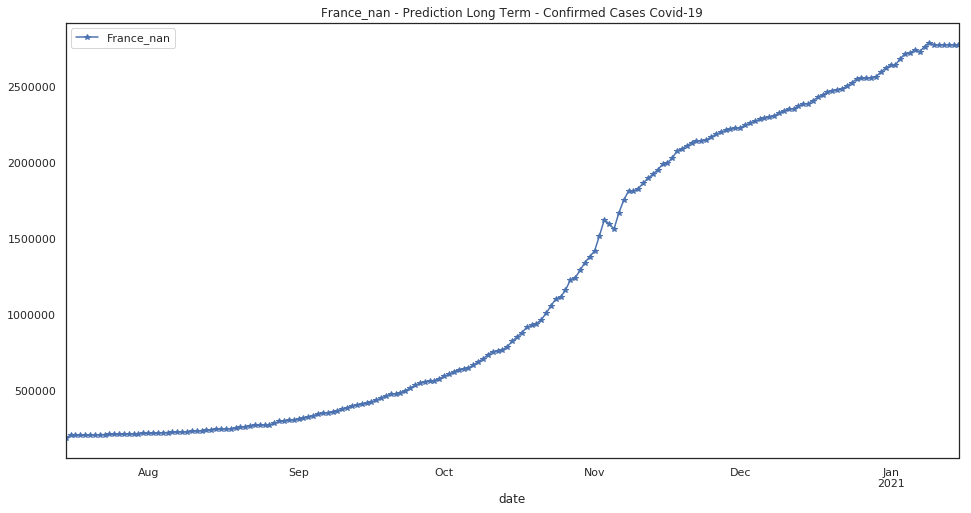

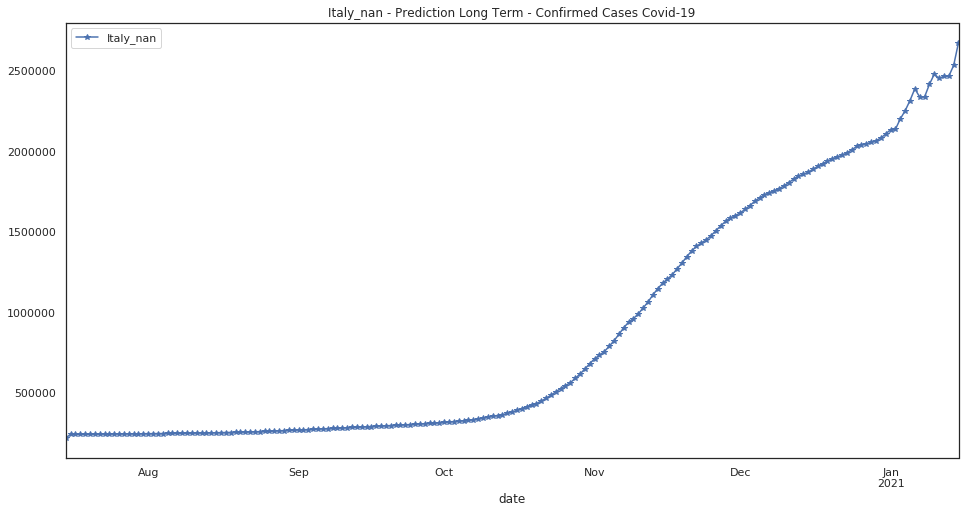

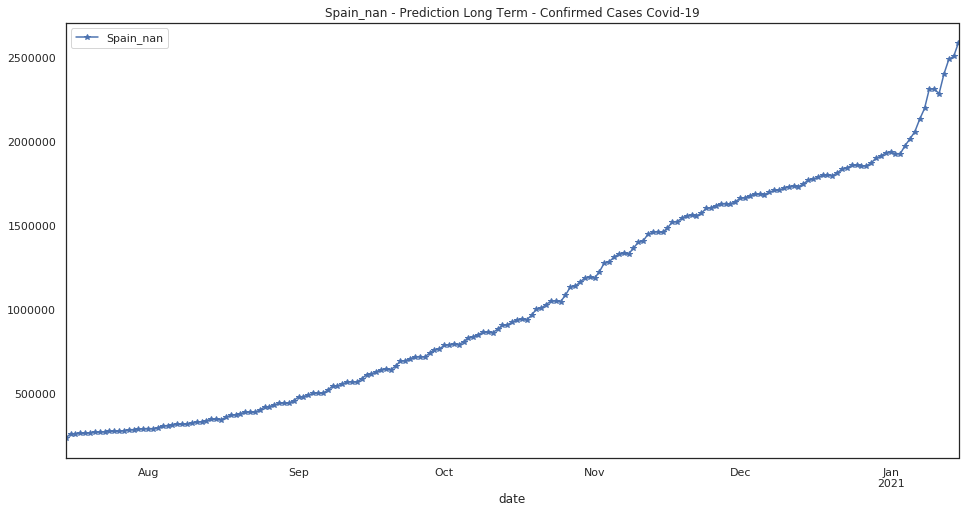

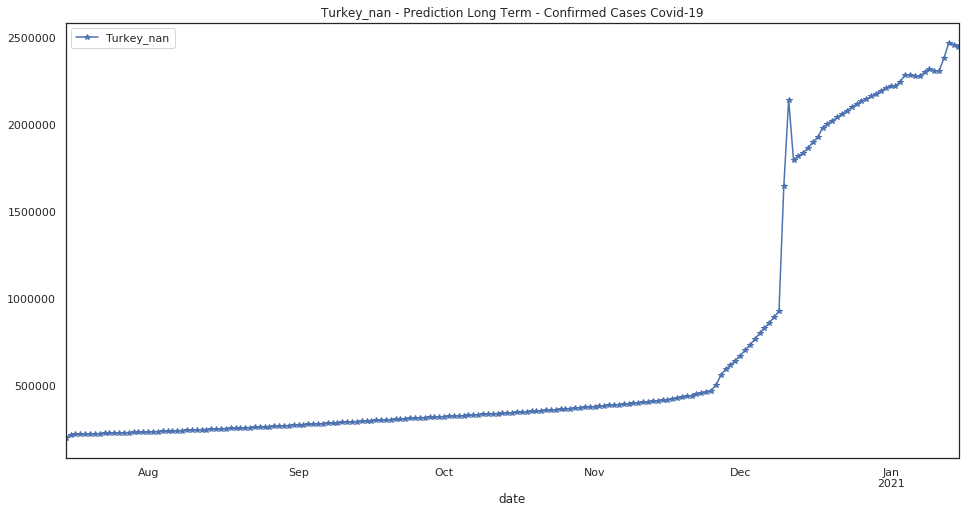

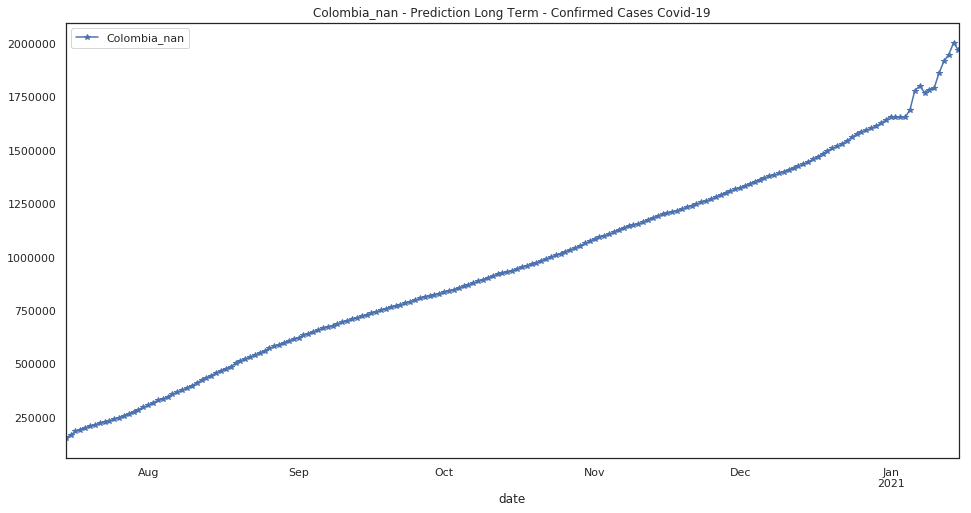

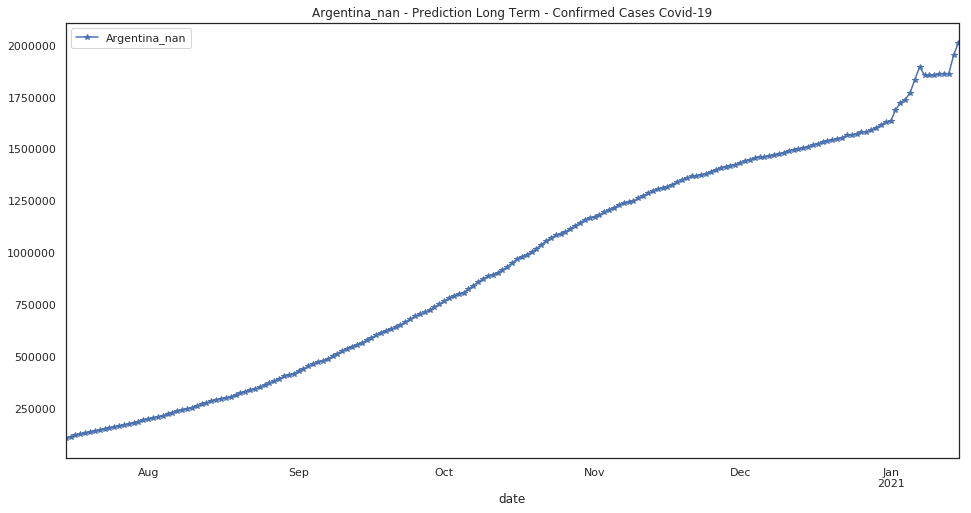

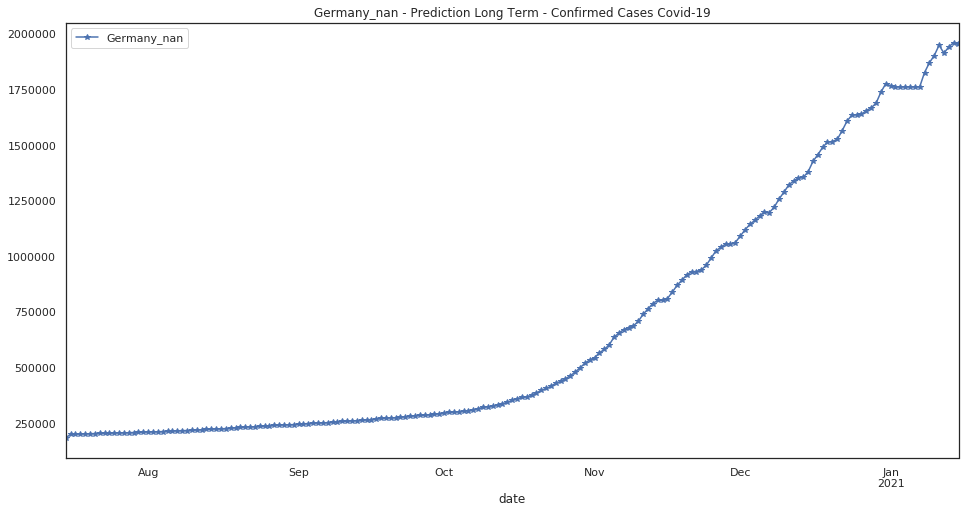

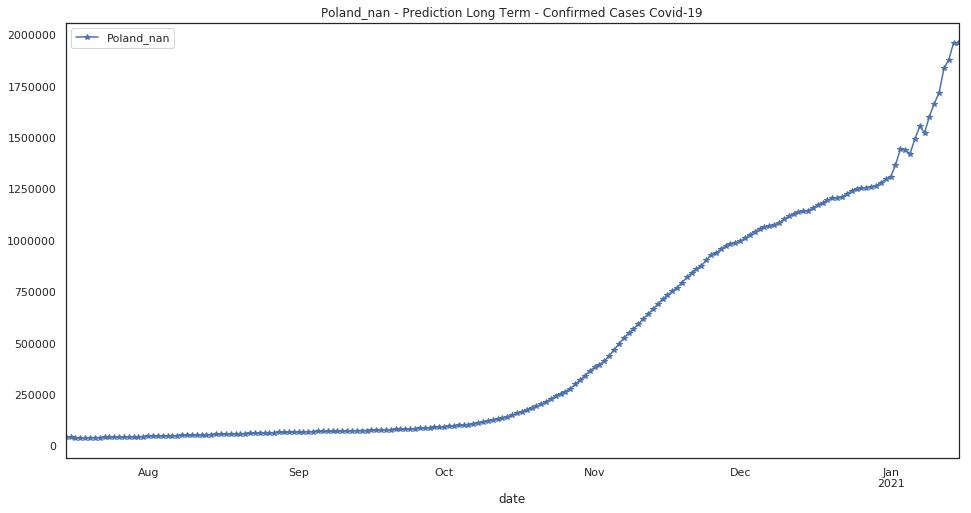

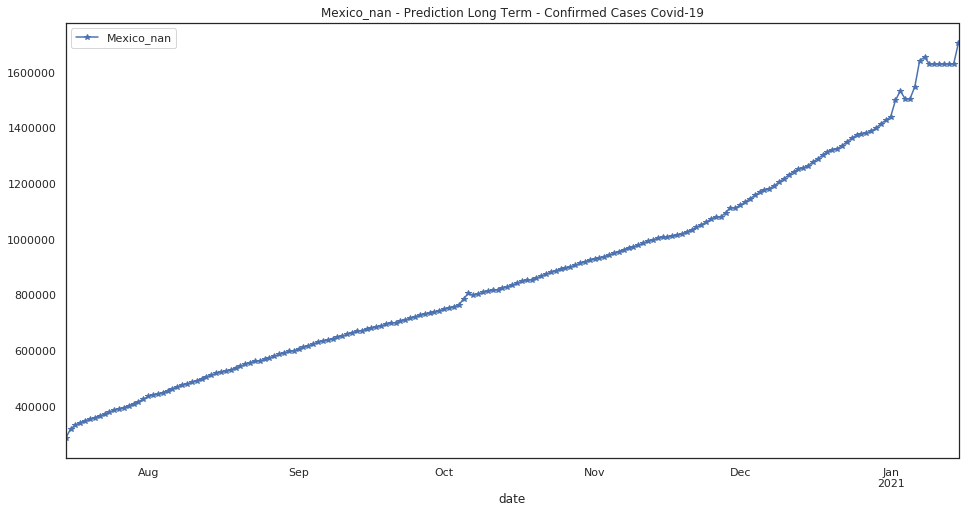

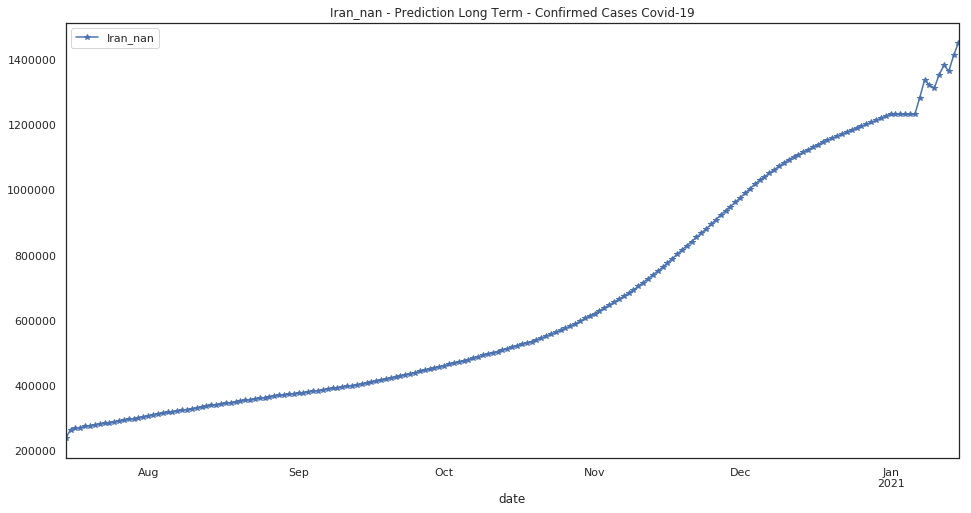

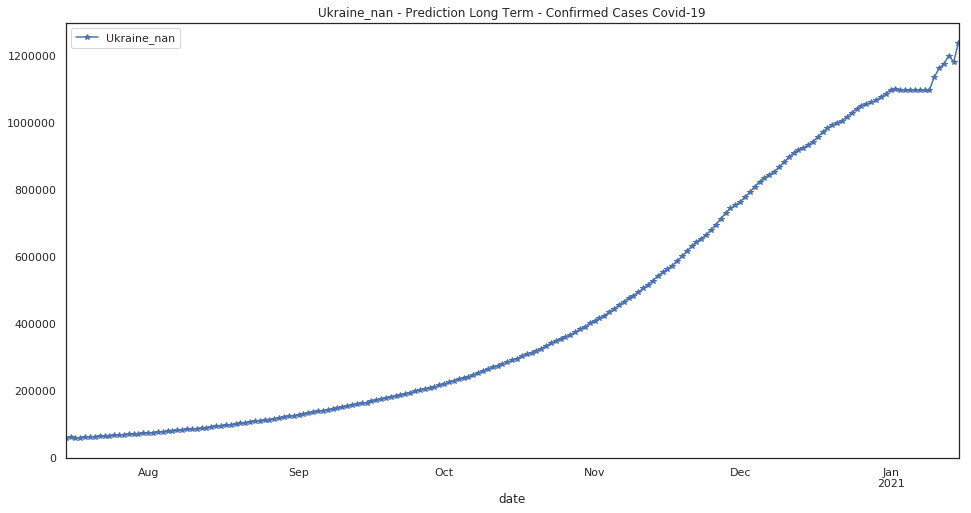

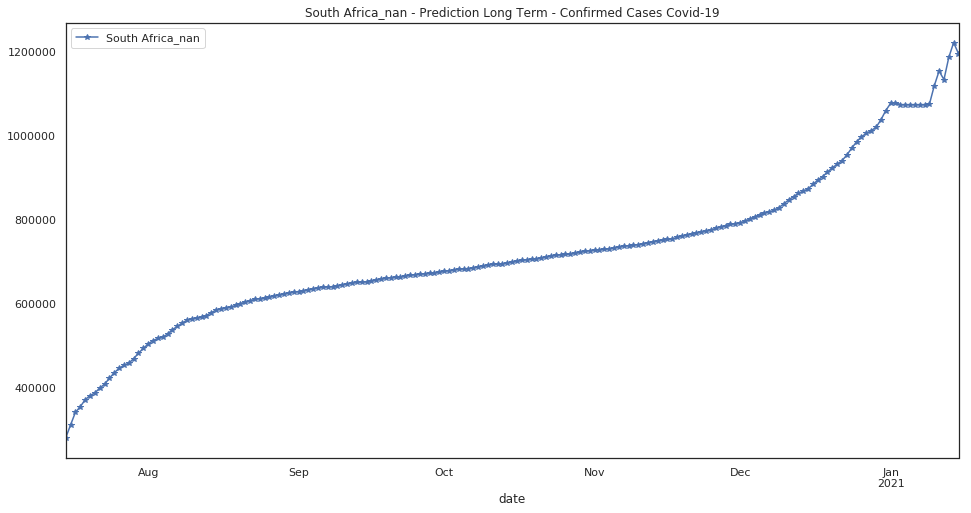

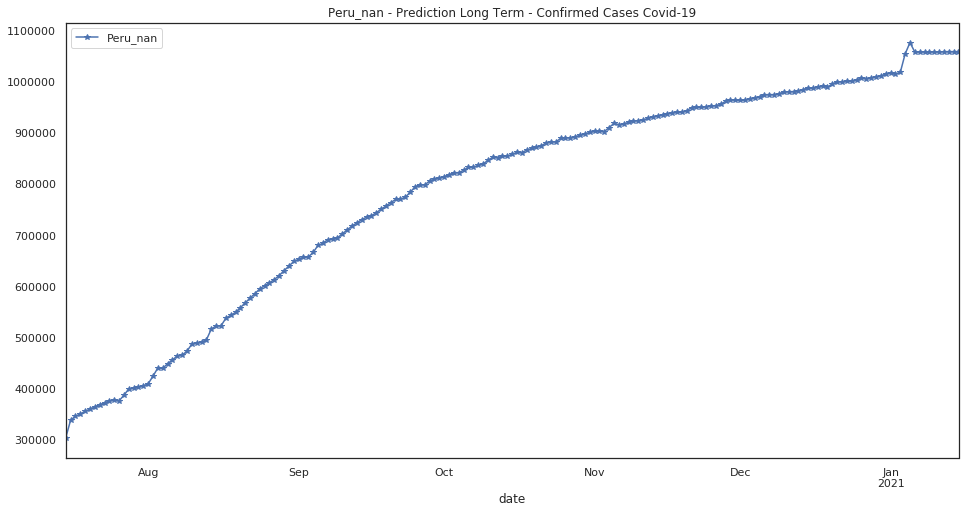

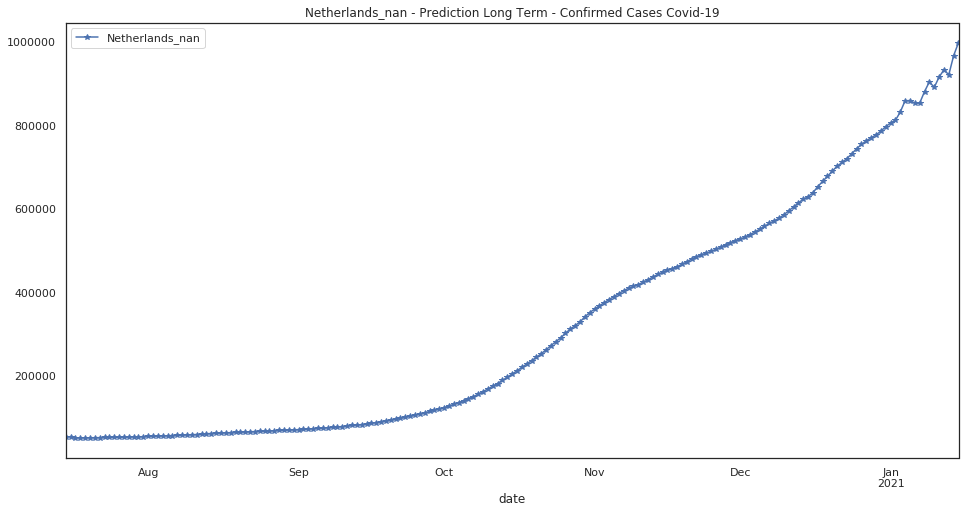

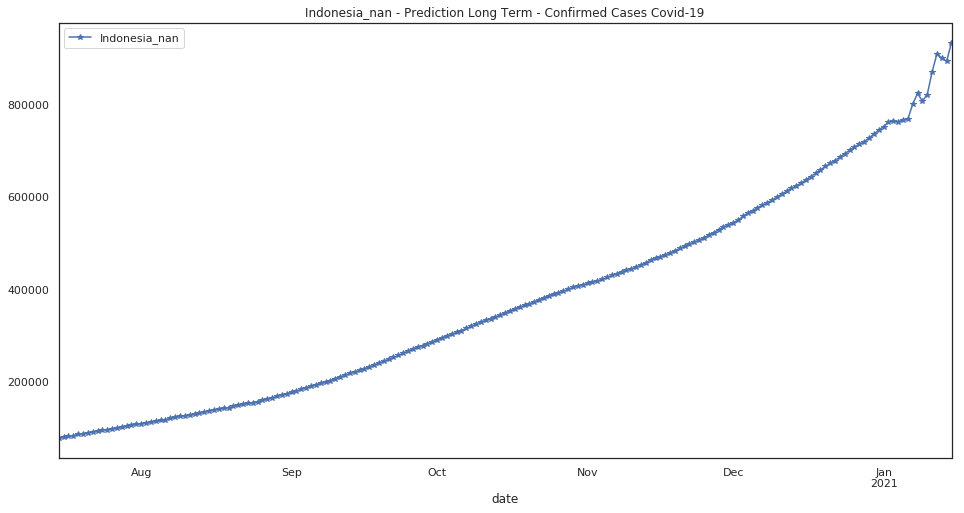

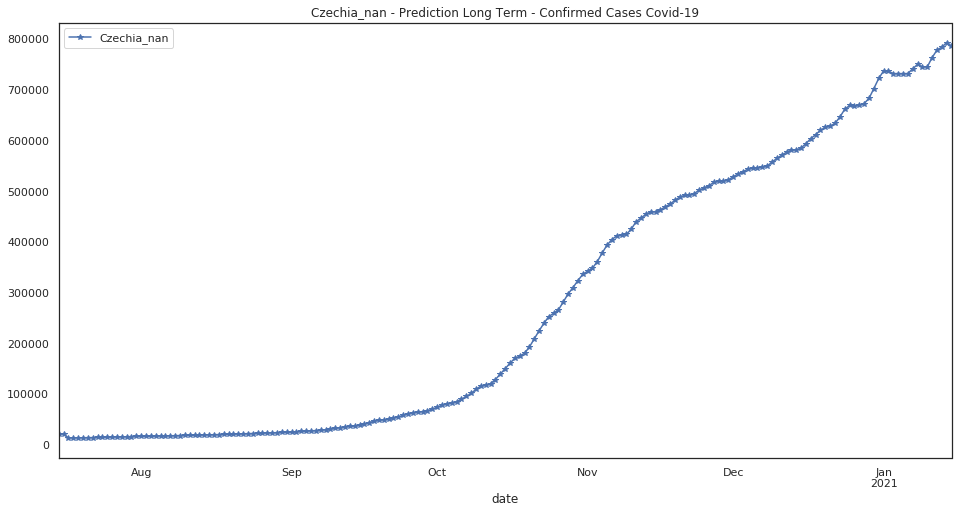

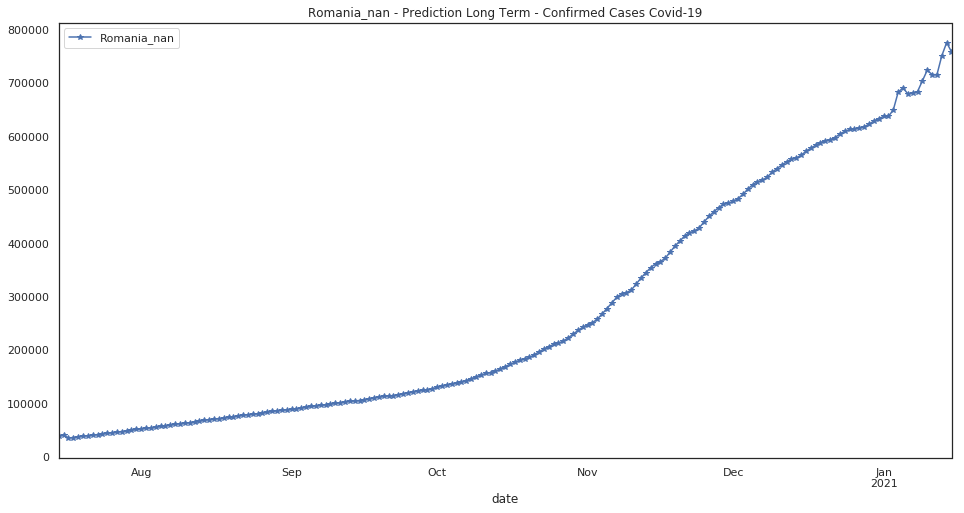

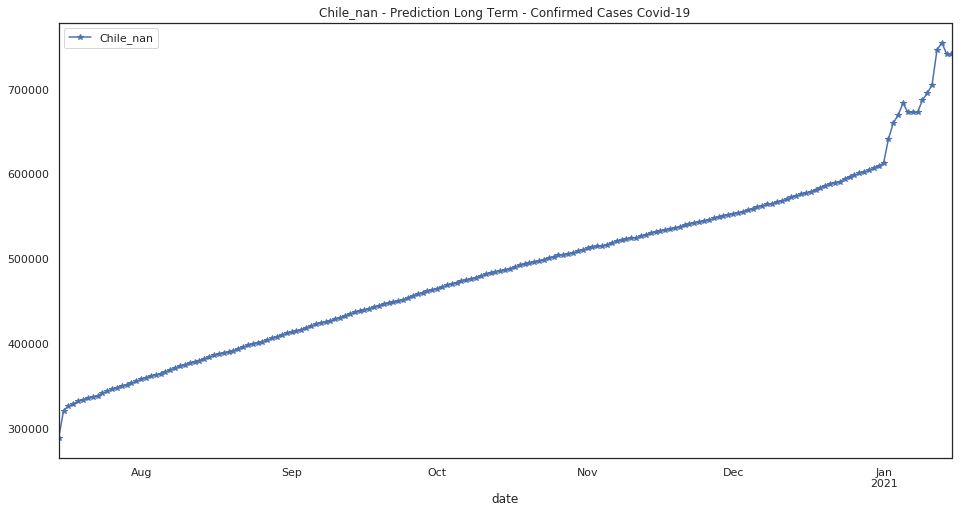

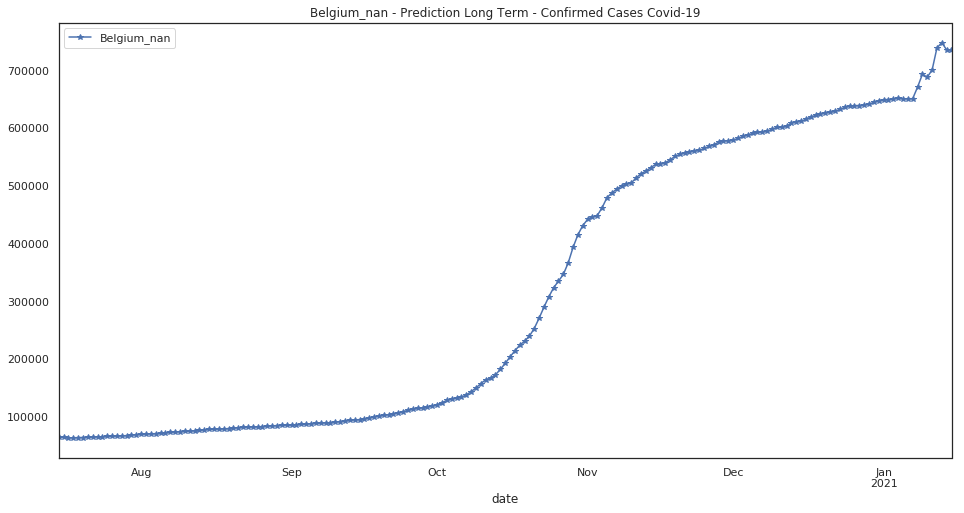

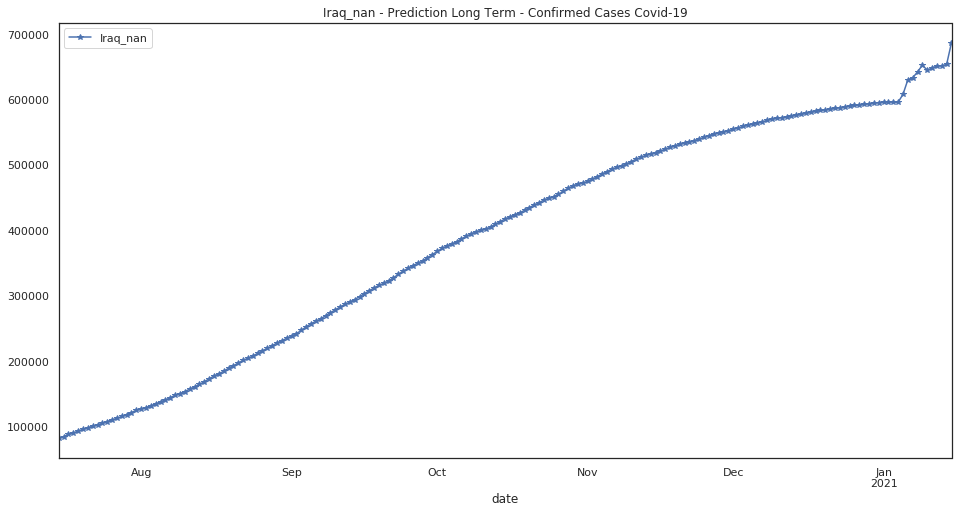

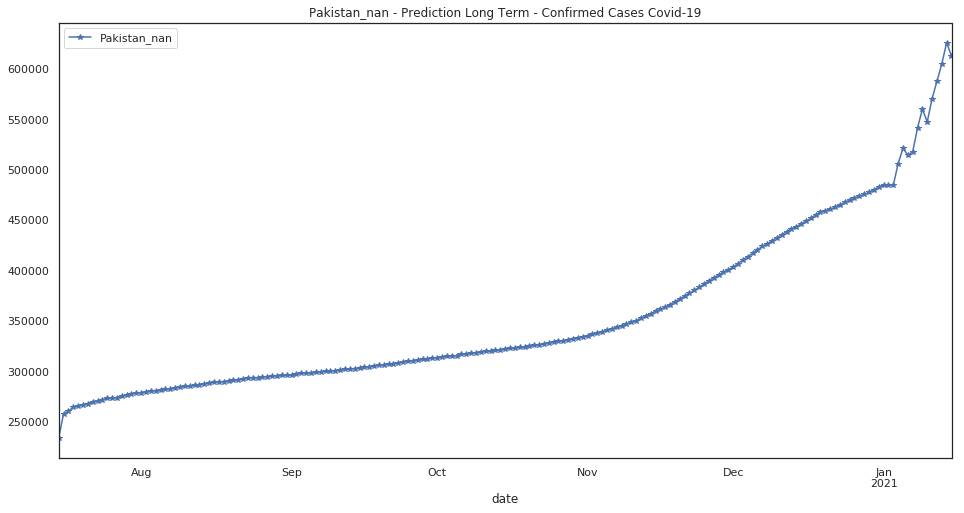

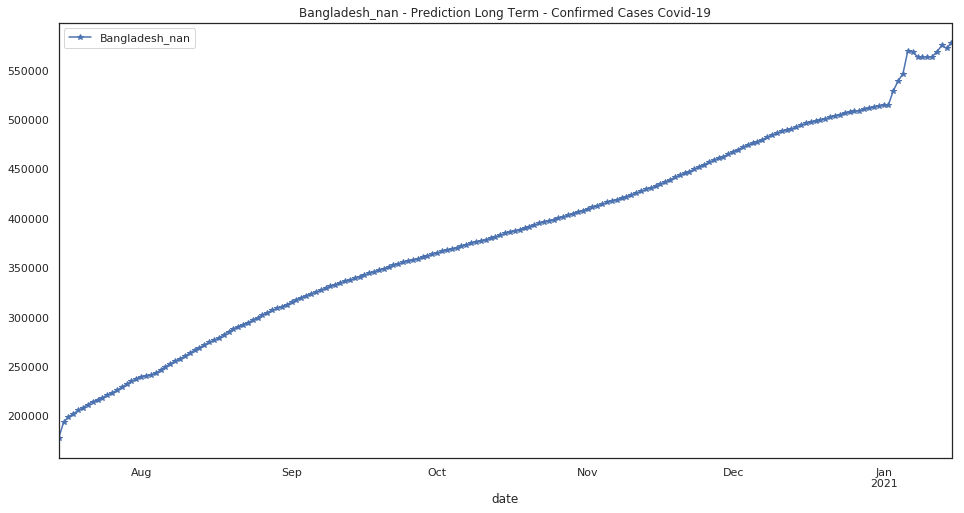

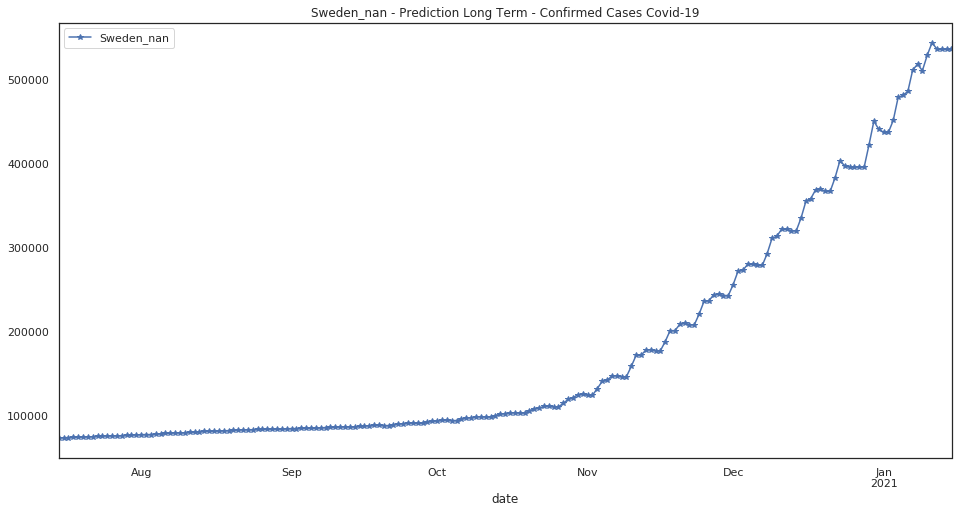

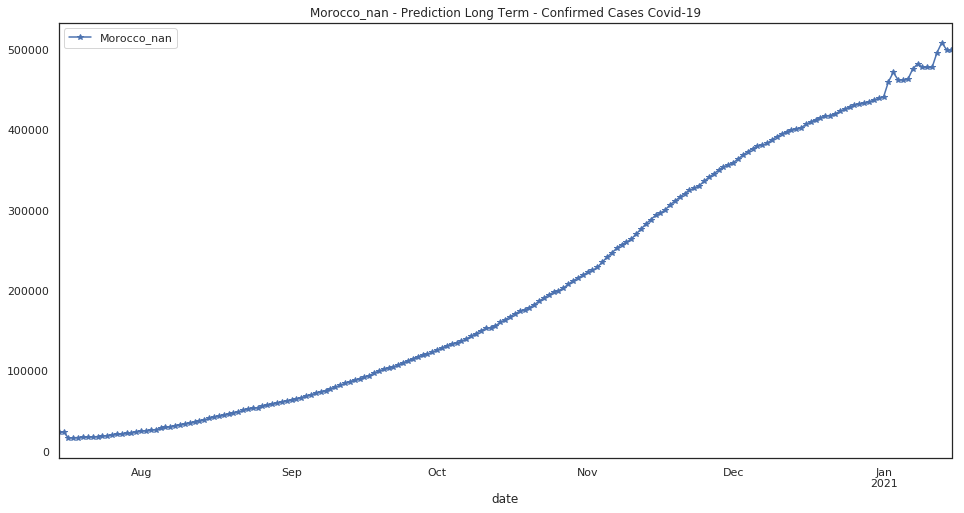

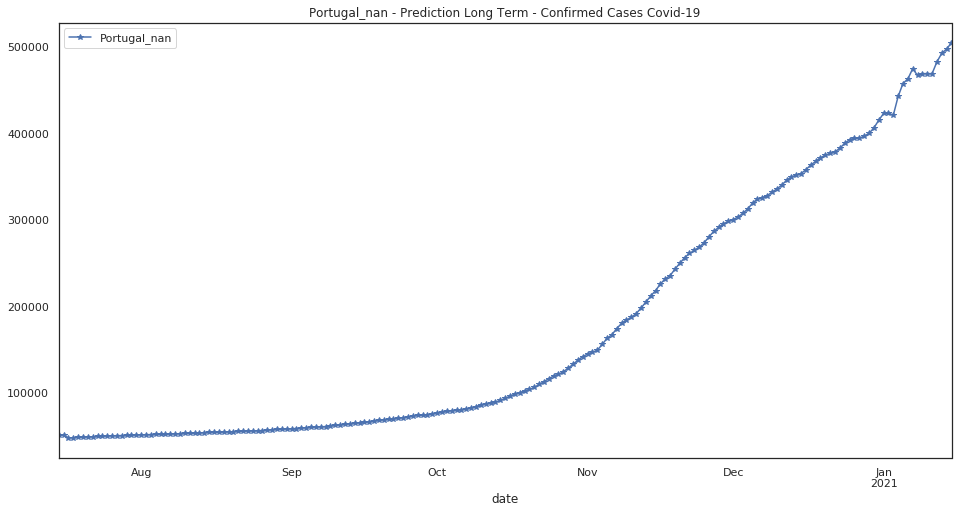

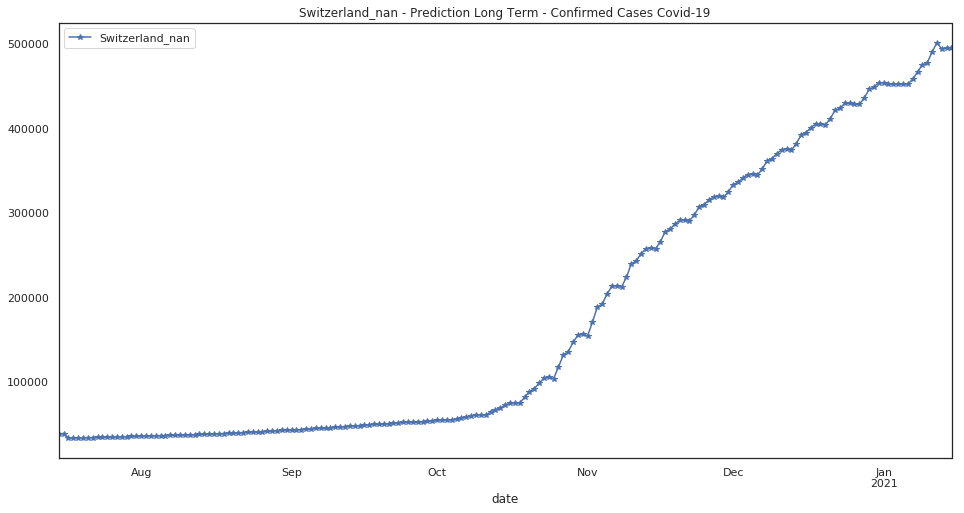

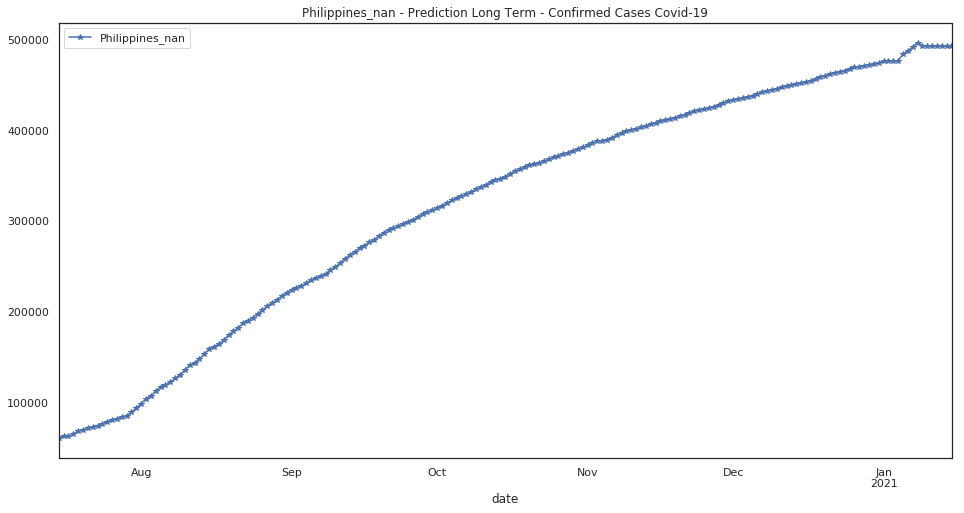

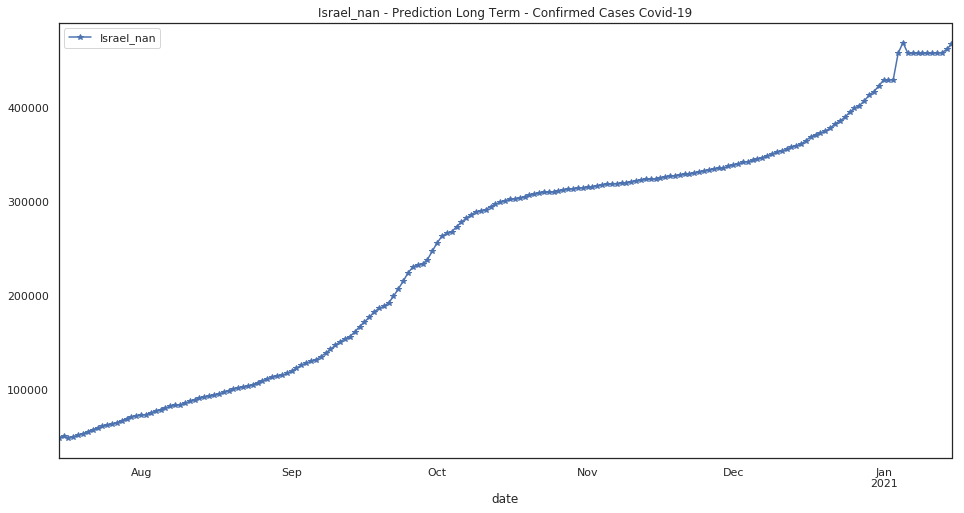

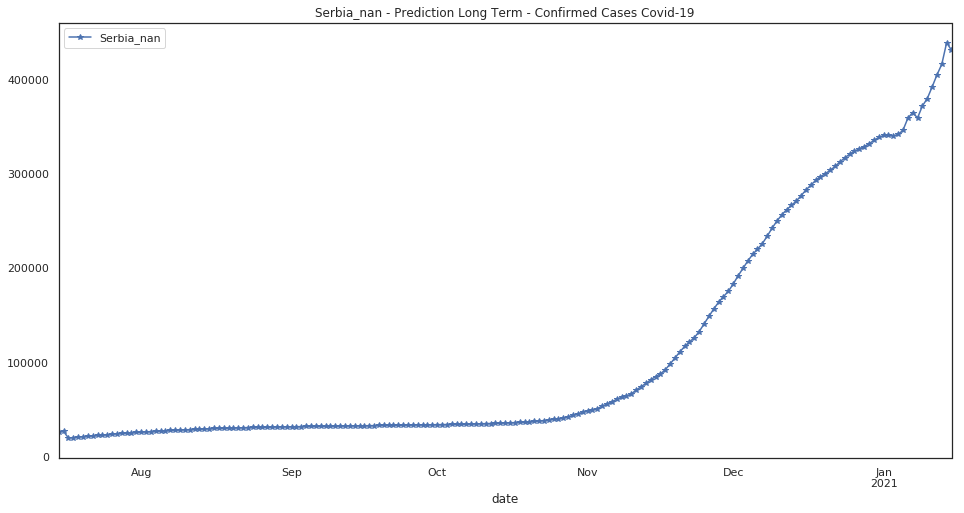

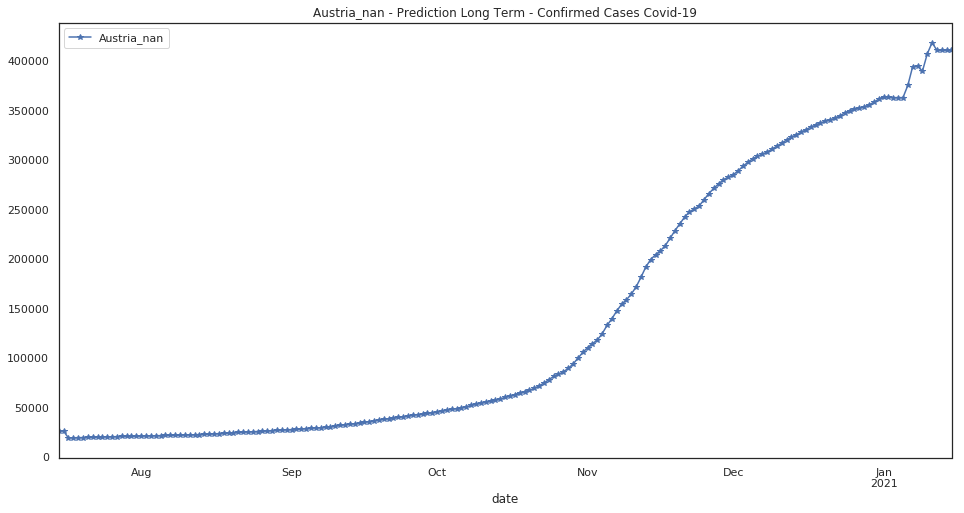

In [77]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

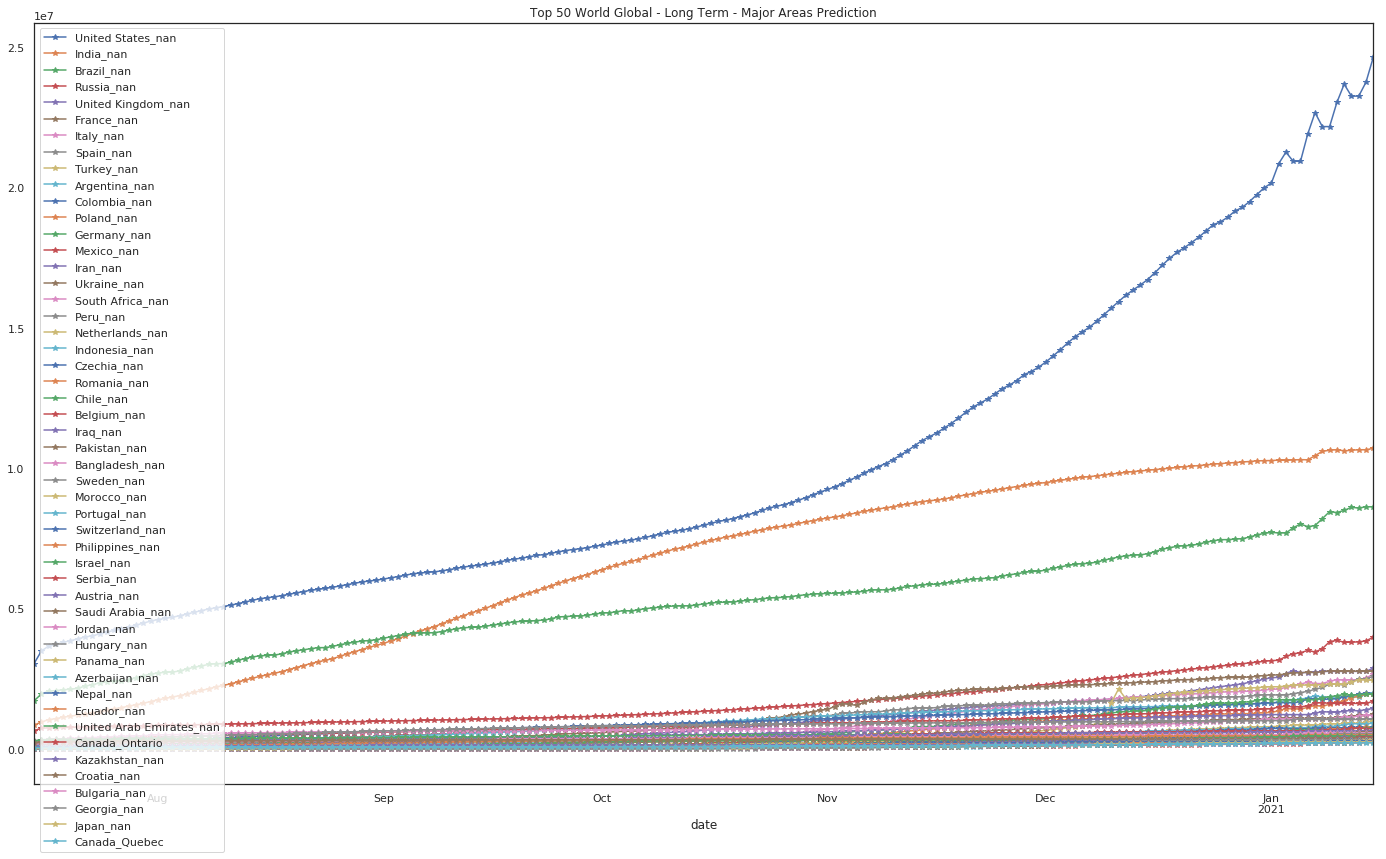

In [78]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

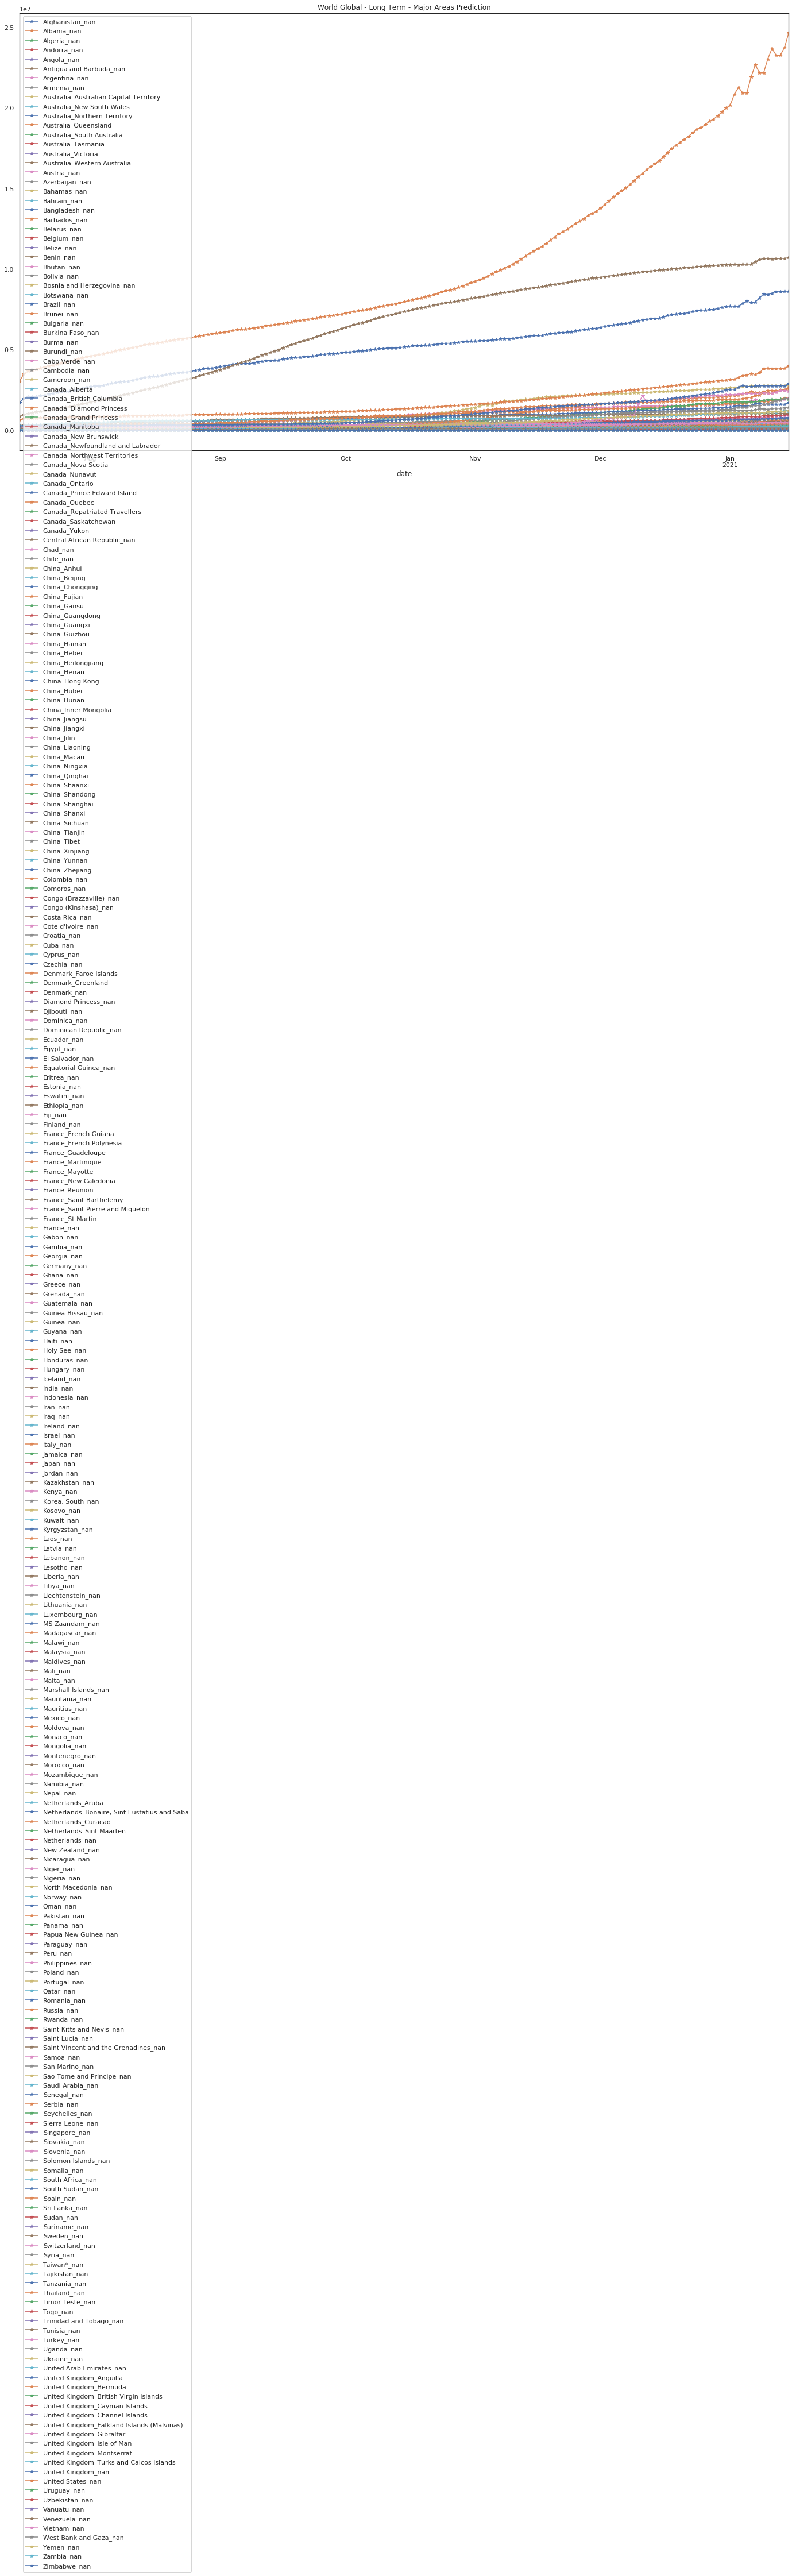

In [79]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [80]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [81]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-08-29          38204.0       9289.0      43805.0       1124.0   
2020-08-30          38223.0       9397.0      44171.0       1286.0   
2020-08-31          38236.0       9509.0      44518.0       1332.0   
2020-09-01          38265.0       9593.0      44855.0       1176.0   
2020-09-02          38320.0       9741.0      45180.0       1330.0   
2020-09-03          38371.0       9845.0      45491.0       1279.0   
2020-09-04          38391.0       9971.0      45796.0       1380.0   
2020-09-05          38402.0      10105.0      46097.0       1254.0   
2020-09-06          38467.0      10250.0      46393.0       1375.0   
2020-09-07          38570.0      10396.0      46686.0       1415.0   
2020-09-08          38610.0      10549.0      46974.0       1261.0   
2020-09-09          38620.0      10703.0      47255.0       1475.0   
2020-09-10          38645.0      10856.0      47528.0       1301.0   
2020-09-11          38675.0      11014.0      47794.0       1520.0   
2020-09-12          38711.0      11177.0      48049.0       1344.0   
2020-09-13          38780.0      11345.0      48297.0       1534.0   
2020-09-14          38851.0      11513.0      48539.0       1616.0   
2020-09-15          38896.0      11669.0      48778.0       1438.0   
2020-09-16          38933.0      11820.0      49012.0       1711.0   
2020-09-17          38949.0      11956.0      49242.0       1483.0   
2020-09-18          38966.0      12084.0      49463.0       1758.0   
2020-09-19          38989.0      12236.0      49674.0       1564.0   
2020-09-20          39100.0      12385.0      49877.0       1798.0   
2020-09-21          39169.0      12539.0      50075.0       1899.0   
2020-09-22          39174.0      12681.0      50267.0       1681.0   
2020-09-23          39219.0      12810.0      50454.0       2002.0   
2020-09-24          39247.0      12943.0      50635.0       1753.0   
2020-09-25          39258.0      13063.0      50811.0       2063.0   
2020-09-26          39263.0      13176.0      50974.0       1836.0   
2020-09-27          39290.0      13289.0      51125.0       2081.0   
...                     ...          ...          ...          ...   
2020-12-17          49448.0      51430.0      93991.0       7932.0   
2020-12-18          49691.0      52097.0      94428.0       8020.0   
2020-12-19          49770.0      52583.0      94853.0       8044.0   
2020-12-20          49838.0      53061.0      95269.0       8074.0   
2020-12-21          50053.0      53467.0      95728.0       8122.0   
2020-12-22          50246.0      53856.0      96162.0       8142.0   
2020-12-23          50488.0      54355.0      96620.0       8172.0   
2020-12-24          50737.0      54912.0      97109.0       8204.0   
2020-12-25          50896.0      55489.0      97536.0       8266.0   
2020-12-26          50969.0      55915.0      97947.0       8301.0   
2020-12-27          51076.0      56349.0      98331.0       8332.0   
2020-12-28          51322.0      56726.0      98704.0       8409.0   
2020-12-29          51442.0      57204.0      99063.0       8423.0   
2020-12-30          51458.0      57864.0      99381.0       8495.0   
2020-12-31          51572.0      58456.0      99678.0       8555.0   
2021-01-01          51606.0      58550.0      99964.0       8626.0   
2021-01-02          52497.0      60877.0     100003.0       8641.0   
2021-01-03          52939.0      62132.0     102499.0       8688.0   
2021-01-04          52638.0      61230.0     104015.0       8679.0   
2021-01-05          52655.0      61253.0     102880.0       8671.0   
2021-01-06          52585.0      63946.0     106562.0       8966.0   
2021-01-07          52589.0      65452.0     108532.0       8800.0   
2021-01-08          52598.0      64476.0     107087.0       9074.0   
2021-01-09          52598.0      64476.0     107087.0       9194.0   
2021-01-10

In [82]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [83]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [84]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [85]:
heatmap_m[:]

region        Lat        Long  \
0                               Afghanistan_nan  33.939110   67.709953   
1                                   Albania_nan  41.153300   20.168300   
2                                   Algeria_nan  28.033900    1.659600   
3                                   Andorra_nan  42.506300    1.521800   
4                                    Angola_nan -11.202700   17.873900   
5                       Antigua and Barbuda_nan  17.060800  -61.796400   
6                                 Argentina_nan -38.416100  -63.616700   
7                                   Armenia_nan  40.069100   45.038200   
8        Australia_Australian Capital Territory -35.473500  149.012400   
9                     Australia_New South Wales -33.868800  151.209300   
10                 Australia_Northern Territory -12.463400  130.845600   
11                         Australia_Queensland -27.469800  153.025100   
12                    Australia_South Australia -34.928500  138.600700   
13                           Australia_Tasmania -42.882100  147.327200   
14                           Australia_Victoria -37.813600  144.963100   
15                  Australia_Western Australia -31.950500  115.860500   
16                                  Austria_nan  47.516200   14.550100   
17                               Azerbaijan_nan  40.143100   47.576900   
18                                  Bahamas_nan  25.025885  -78.035889   
19                                  Bahrain_nan  26.027500   50.550000   
20                               Bangladesh_nan  23.685000   90.356300   
21                                 Barbados_nan  13.193900  -59.543200   
22                                  Belarus_nan  53.709800   27.953400   
23                                  Belgium_nan  50.833300    4.469936   
24                                   Belize_nan  17.189900  -88.497600   
25                                    Benin_nan   9.307700    2.315800   
26                                   Bhutan_nan  27.514200   90.433600   
27                                  Bolivia_nan -16.290200  -63.588700   
28                   Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                 Botswana_nan -22.328500   24.684900   
..                                          ...        ...         ...   
247                                Thailand_nan  15.870032  100.992541   
248                             Timor-Leste_nan  -8.874217  125.727539   
249                                    Togo_nan   8.619500    0.824800   
250                     Trinidad and Tobago_nan  10.691800  -61.222500   
251                                 Tunisia_nan  33.886917    9.537499   
252                                  Turkey_nan  38.963700   35.243300   
253                           United States_nan  40.000000 -100.000000   
254                                  Uganda_nan   1.373333   32.290275   
255                                 Ukraine_nan  48.379400   31.165600   
256                    United Arab Emirates_nan  23.424076   53.847818   
257                     United Kingdom_Anguilla  18.220600  -63.068600   
258                      United Kingdom_Bermuda  32.307800  -64.750500   
259       United Kingdom_British Virgin Islands  18.420700  -64.640000   
260               United Kingdom_Cayman Islands  19.313300  -81.254600   
261              United Kingdom_Channel Islands  49.372300   -2.364400   
262  United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
263                    United Kingdom_Gibraltar  36.140800   -5.353600   
264                  United Kingdom_Isle of Man  54.236100   -4.548100   
265                   United Kingdom_Montserrat  16.742498  -62.187366   
266     United Kingdom_Turks and Caicos Islands  21.694000  -71.797900   
267                          United Kingdom_nan  55.378100   -3.436000   
268                                 Uruguay_nan -32.522800  -55.765800   
269                              Uzbekistan_n

In [86]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat,lng,num,totpred,ldaygrowth in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]],  (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg ):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred))+' 1DayChangePred='+str(round(ldaygrowth))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

ValueError: Location values cannot contain NaNs.

In [87]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                    region        Lat        Long  \
0       6             Argentina_nan -38.416100  -63.616700   
1      16               Austria_nan  47.516200   14.550100   
2      17            Azerbaijan_nan  40.143100   47.576900   
3      20            Bangladesh_nan  23.685000   90.356300   
4      23               Belgium_nan  50.833300    4.469936   
5      30                Brazil_nan -14.235000  -51.925300   
6      32              Bulgaria_nan  42.733900   25.485800   
7      51            Canada_Ontario  51.253800  -85.323200   
8      59                 Chile_nan -35.675100  -71.543000   
9      93              Colombia_nan   4.570900  -74.297300   
10     99               Croatia_nan  45.100000   15.200000   
11    102               Czechia_nan  49.817500   15.473000   
12    110               Ecuador_nan  -1.831200  -78.183400   
13    130                France_nan  46.227600    2.213700   
14    133               Georgia_nan  42.315400   43.356900   
15    134               Georgia_nan  42.315400   43.356900   
16    135               Germany_nan  51.165691   10.451526   
17    147               Hungary_nan  47.162500   19.503300   
18    149                 India_nan  20.593684   78.962880   
19    150             Indonesia_nan  -0.789300  113.921300   
20    151                  Iran_nan  32.427908   53.688046   
21    152                  Iraq_nan  33.223191   43.679291   
22    154                Israel_nan  31.046051   34.851612   
23    155                Israel_nan  31.046051   34.851612   
24    156                 Italy_nan  41.871940   12.567380   
25    158                 Japan_nan  36.204824  138.252924   
26    159                Jordan_nan  31.240000   36.510000   
27    160            Kazakhstan_nan  48.019600   66.923700   
28    186                Mexico_nan  23.634500 -102.552800   
29    191               Morocco_nan  31.791700   -7.092600   
30    194                 Nepal_nan  28.166700   84.250000   
31    199           Netherlands_nan  52.132600    5.291300   
32    207              Pakistan_nan  30.375300   69.345100   
33    208                Panama_nan   8.538000  -80.782100   
34    211                  Peru_nan  -9.190000  -75.015200   
35    212           Philippines_nan  12.879721  121.774017   
36    213                Poland_nan  51.919400   19.145100   
37    214              Portugal_nan  39.399900   -8.224500   
38    216               Romania_nan  45.943200   24.966800   
39    217                Russia_nan  61.524010  105.318756   
40    225          Saudi Arabia_nan  23.885942   45.079162   
41    227                Serbia_nan  44.016500   21.005900   
42    231              Slovakia_nan  48.669000   19.699000   
43    235          South Africa_nan -30.559500   22.937500   
44    237                 Spain_nan  40.463667   -3.749220   
45    241                Sweden_nan  60.128161   18.643501   
46    242           Switzerland_nan  46.818200    8.227500   
47    252                Turkey_nan  38.963700   35.243300   
48    253         United States_nan  40.000000 -100.000000   
49    255               Ukraine_nan  48.379400   31.165600   
50    256  United Arab Emirates_nan  23.424076   53.847818   
51    267        United Kingdom_nan  55.378100   -3.436000   

    2020-07-15 00:00:00  2020-07-16 00:00:00  2020-07-17 00:00:00  \
0              106189.0             111146.0             119209.0   
1               26146.0              26247.0              19270.0   
2               31818.0              32247.0              26165.0   
3              177923.0             193590.0             199249.0   
4               64185.0              64504.0              63238.0   
5             1720747.0            1966748.0            2064103.0   
6               16334.0              16567.0               8144.0   
7               43343.0              43452.0              39043.0   
8              288961.0             321205.0             326466.0   
9              153194.0    

In [88]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat2,lng2,num2,totpred2,ldaygrowth2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg ):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred2))+' 1DayChangePred='+str(round(ldaygrowth2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [89]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [90]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [91]:
exit()